In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import xml.etree.ElementTree as ET
from collections import defaultdict
import pymzml
import re
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

/tmp/ipykernel_132586/3593534661.py:7: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
def get_user_param_value(param):
    if param.attrib['type'] == 'string':
        return param.attrib['value']
    elif param.attrib['type'] == 'int':
        return int(param.attrib['value'])
    elif param.attrib['type'] == 'float':
        return float(param.attrib['value'])
    else:
        assert False, param.attrib['type']

def from_user_param(node):
    r = {}
    for x in node.findall('UserParam'):
        r[x.attrib['name']] = get_user_param_value(x)
    return r

In [4]:
class XMLNode:
    def __init__(self, node):
        self.node = node
        self.d = {}
        self.d.update(node.attrib)
        self.d.update(from_user_param(node))

    def __getattr__(self, attr):
        if attr in self.d:
            return self.d[attr]
        return super().__getattr__(attr)

    def __getitem__(self, item):
        return self.d[item]

In [5]:
class XLMS_res:
    def __init__(self, filename = None):
        self.filename = filename
        if filename:
            self.xml = ET.parse(filename)

    @staticmethod
    def from_old(old):
        new = XLMS_res()
        new.filename = old.filename
        new.xml = old.xml
        return new

    def pep_matches(self):
        return self.xml.findall('IdentificationRun/PeptideIdentification')
        # nodup_res = []
        # peps = set()
        # for pepid in self.xml.findall('IdentificationRun/PeptideIdentification'):
        #     for 

    def all_spectrum(self):
        r = defaultdict(list)
        for pepid in self.pep_matches():
            # pephits = pepid.findall('PeptideHit')
            # # assert 1 <= len(pephits) <= 2, pephits
            # pephits = list(map(PepHit, pephits))
            r[pepid.attrib['spectrum_reference']].append(pepid)
        return r

# res = XLMS_res.from_old(res)
# res

In [8]:
res = XLMS_res('../results/openpepxllf/knime4.6/ALott/M_Ninov_A_Lott_181119_201119_XL_rep1_22.idXML')

In [9]:
psms = res.pep_matches()
len(psms)

86576

In [10]:
pepid = res.all_spectrum()
len(pepid)

8879

In [11]:
pepid['controllerType=0 controllerNumber=1 scan=2831']

[]

## Filter Matches

In [13]:
def apply_pepid_filter(d, f):
    r = {k: [x for x in l if f(x)] for k, l in d.items()}
    return r

def add_mem_var(f):
    mem = set()
    def _f(*args):
        f(args, mem)
    return mem

def filter_dup_pep(x, mem):
    alpha_seq = XMLNode(x.find('PeptideHit')).sequence
    beta_seq = XMLNode(x.find('PeptideHit')).sequence_beta
    pep = (alpha_seq, beta_seq)
    if pep in mem:
        return False
    mem.add(pep)
    return True
filter_dup_pep_gen = lambda mem: lambda x: filter_dup_pep(x, mem)

def filter_top2(x):
    return XMLNode(x).xl_rank <= 2

def apply_spectrum_filter(d, f):
    r = {k: l for k, l in d.items() if f(l)}
    return r

def filter_high_s2(l):
    if len(l) < 2:
        return False
    p2 = l[1]
    return XMLNode(p2.find('PeptideHit'))['OpenPepXL:score'] * 300 > 175

def filter_all_xl(l):
    for x in l:
        if XMLNode(x).xl_type != 'cross-link':
            return False
    return True

In [14]:
pepid_top2 = apply_pepid_filter(pepid, filter_top2)

In [27]:
pepid_top2['controllerType=0 controllerNumber=1 scan=6650']

[<Element 'PeptideIdentification' at 0x7f7f1412d1c0>,
 <Element 'PeptideIdentification' at 0x7f7f1413c180>]

In [16]:
pepid_high_s2 = apply_spectrum_filter(pepid_top2, filter_high_s2)
len(pepid_high_s2)

457

In [17]:
pepid_high_s2 = apply_spectrum_filter(pepid_high_s2, filter_all_xl)
len(pepid_high_s2)

388

In [18]:
pepid_high_s2.keys()

dict_keys(['controllerType=0 controllerNumber=1 scan=2570', 'controllerType=0 controllerNumber=1 scan=2740', 'controllerType=0 controllerNumber=1 scan=2759', 'controllerType=0 controllerNumber=1 scan=2796', 'controllerType=0 controllerNumber=1 scan=2801', 'controllerType=0 controllerNumber=1 scan=2818', 'controllerType=0 controllerNumber=1 scan=2830', 'controllerType=0 controllerNumber=1 scan=2858', 'controllerType=0 controllerNumber=1 scan=2861', 'controllerType=0 controllerNumber=1 scan=2863', 'controllerType=0 controllerNumber=1 scan=2888', 'controllerType=0 controllerNumber=1 scan=2909', 'controllerType=0 controllerNumber=1 scan=2924', 'controllerType=0 controllerNumber=1 scan=2932', 'controllerType=0 controllerNumber=1 scan=2935', 'controllerType=0 controllerNumber=1 scan=2936', 'controllerType=0 controllerNumber=1 scan=2949', 'controllerType=0 controllerNumber=1 scan=2975', 'controllerType=0 controllerNumber=1 scan=2997', 'controllerType=0 controllerNumber=1 scan=3008', 'controll

In [19]:
ns = 'http://psi.hupo.org/ms/mzml'
nsmap = {'': ns}

In [20]:
specref_reg = re.compile('.* scan=(\d+)')

class mzML:
    def __init__(self, filename = None):
        self.filename = filename
        if filename:
            self.mzml = pymzml.run.Reader(filename)

    @staticmethod
    def from_old(old):
        new = mzML()
        new.filename = old.filename
        new.mzml = old.mzml
        return new

    def find(self, spec_ref):
        m = specref_reg.match(spec_ref)
        if not m:
            return None
        id = int(m.group(1))
        return self.mzml[id]



In [21]:
mzml = mzML('../spec/alban/20210702_L1_UM5_alban001_SA_EXT00_Ilse_fbn_dss2_450mm.mzML')
mzml

[Warning] Not index found and build_index_from_scratch is False


In [23]:
mzml = mzML('../spec/ALott/M_Ninov_A_Lott_181119_201119_XL_rep1_22.mzML')
                          #M_Ninov_A_Lott_181119_201119_XL_rep1_22
mzml

[Warning] Not index found and build_index_from_scratch is False


In [28]:
mzml.find('controllerType=0 controllerNumber=1 scan=6650')

<__main__.Spectrum object with native ID 6650 at 0x7f7f805f7610>

## Spectrum

In [25]:
class Spectrum:
    def __init__(self, spec):
        self.spec = spec

    def peaks(self):
        return self.spec.peaks('raw')
        
    def plot(self, xlim, ax = None):
        if not ax:
            plt.figure()
            ax = plt.subplot(1, 1, 1)
        bars = self.peaks()
        ax.bar(bars[:, 0], bars[:, 1], color='red')
        # ax.set_ylim([0, 2.5e5])
        # ax.set_xlim([0, 800])
        ax.set_xlim([0, xlim])

    def plot_ann(self, ann_str, ax = None):
        if not ax:
            plt.figure()
            ax = plt.subplot(1, 1, 1)
        
        frags = []
        for frag in split_string(ann_str):
            x, y, _, label = frag.split(',')
            x = eval(x)
            y = find_intensity(x, spec.peaks())
            frags.append((x, y, eval(label)))

        frags = pd.DataFrame(frags)
        print(frags)
        
        ax.bar(frags[0], frags[1])

        ax.set_ylim([0, frags[1].max()])

        counts = defaultdict(int)
        for i, (x, y, label) in frags.iterrows():
            yoff = counts[x] * 1
            counts[x] += 1
            ax.annotate(label, (x, y), (0, yoff), xycoords='data', textcoords='offset fontsize')


In [30]:
spec = Spectrum(mzml.find('controllerType=0 controllerNumber=1 scan=6650'))
spec

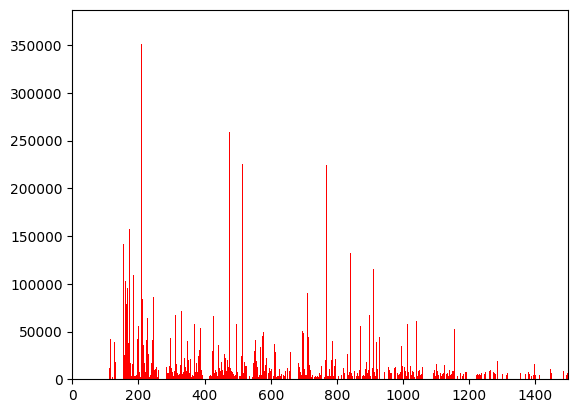

In [35]:
spec.plot(1500)

In [36]:
spec.peaks()[:,1].argmax()

1461

In [37]:
spec.peaks()[169]

array([   181.09739685, 139329.671875  ])

In [201]:
spec.peaks()[:,0]

array([ 120.08093262,  123.17110443,  124.93912506,  126.09191132,
        128.57928467,  129.0660553 ,  129.10247803,  130.0500946 ,
        130.08651733,  130.10585022,  130.11076355,  131.09040833,
        133.04328918,  134.64541626,  135.03924561,  136.07601929,
        139.08731079,  145.23434448,  146.08103943,  147.10694885,
        147.11315918,  148.116745  ,  155.08166504,  156.07699585,
        157.10906982,  157.13383484,  158.09280396,  159.07722473,
        175.07199097,  175.11949158,  176.12333679,  179.04901123,
        195.08818054,  198.12423706,  199.10845947,  201.12388611,
        203.06730652,  207.08795166,  212.10392761,  213.08760071,
        213.12492371,  213.60926819,  216.13517761,  222.12245178,
        222.62425232,  229.11943054,  232.0760498 ,  232.14134216,
        234.1461792 ,  237.09910583,  237.13626099,  241.08345032,
        259.09381104,  261.1567688 ,  262.11791992,  266.12619019,
        267.17184448,  271.12384033,  271.17819214,  272.10705

## Plot XLMS

In [38]:
def split_string(s):
    """
    Splits the string 's' by '|' character, but does not break strings within quotes.
    
    Args:
    s (str): The string to be split.

    Returns:
    List[str]: A list of substrings.
    """
    result = []
    current = ''
    in_quote = False
    escape = False

    for char in s:
        if char == '"' and not escape:
            in_quote = not in_quote
        if char == '|' and not in_quote:
            result.append(current)
            current = ''
        else:
            current += char
        escape = (char == '\\' and not escape)

    # Add the last segment
    if current:
        result.append(current)

    return result


In [39]:
def find_intensity(x, spec):
    y = spec[np.isclose(spec[:, 0], x)][0, 1]
    # print(y)
    return y

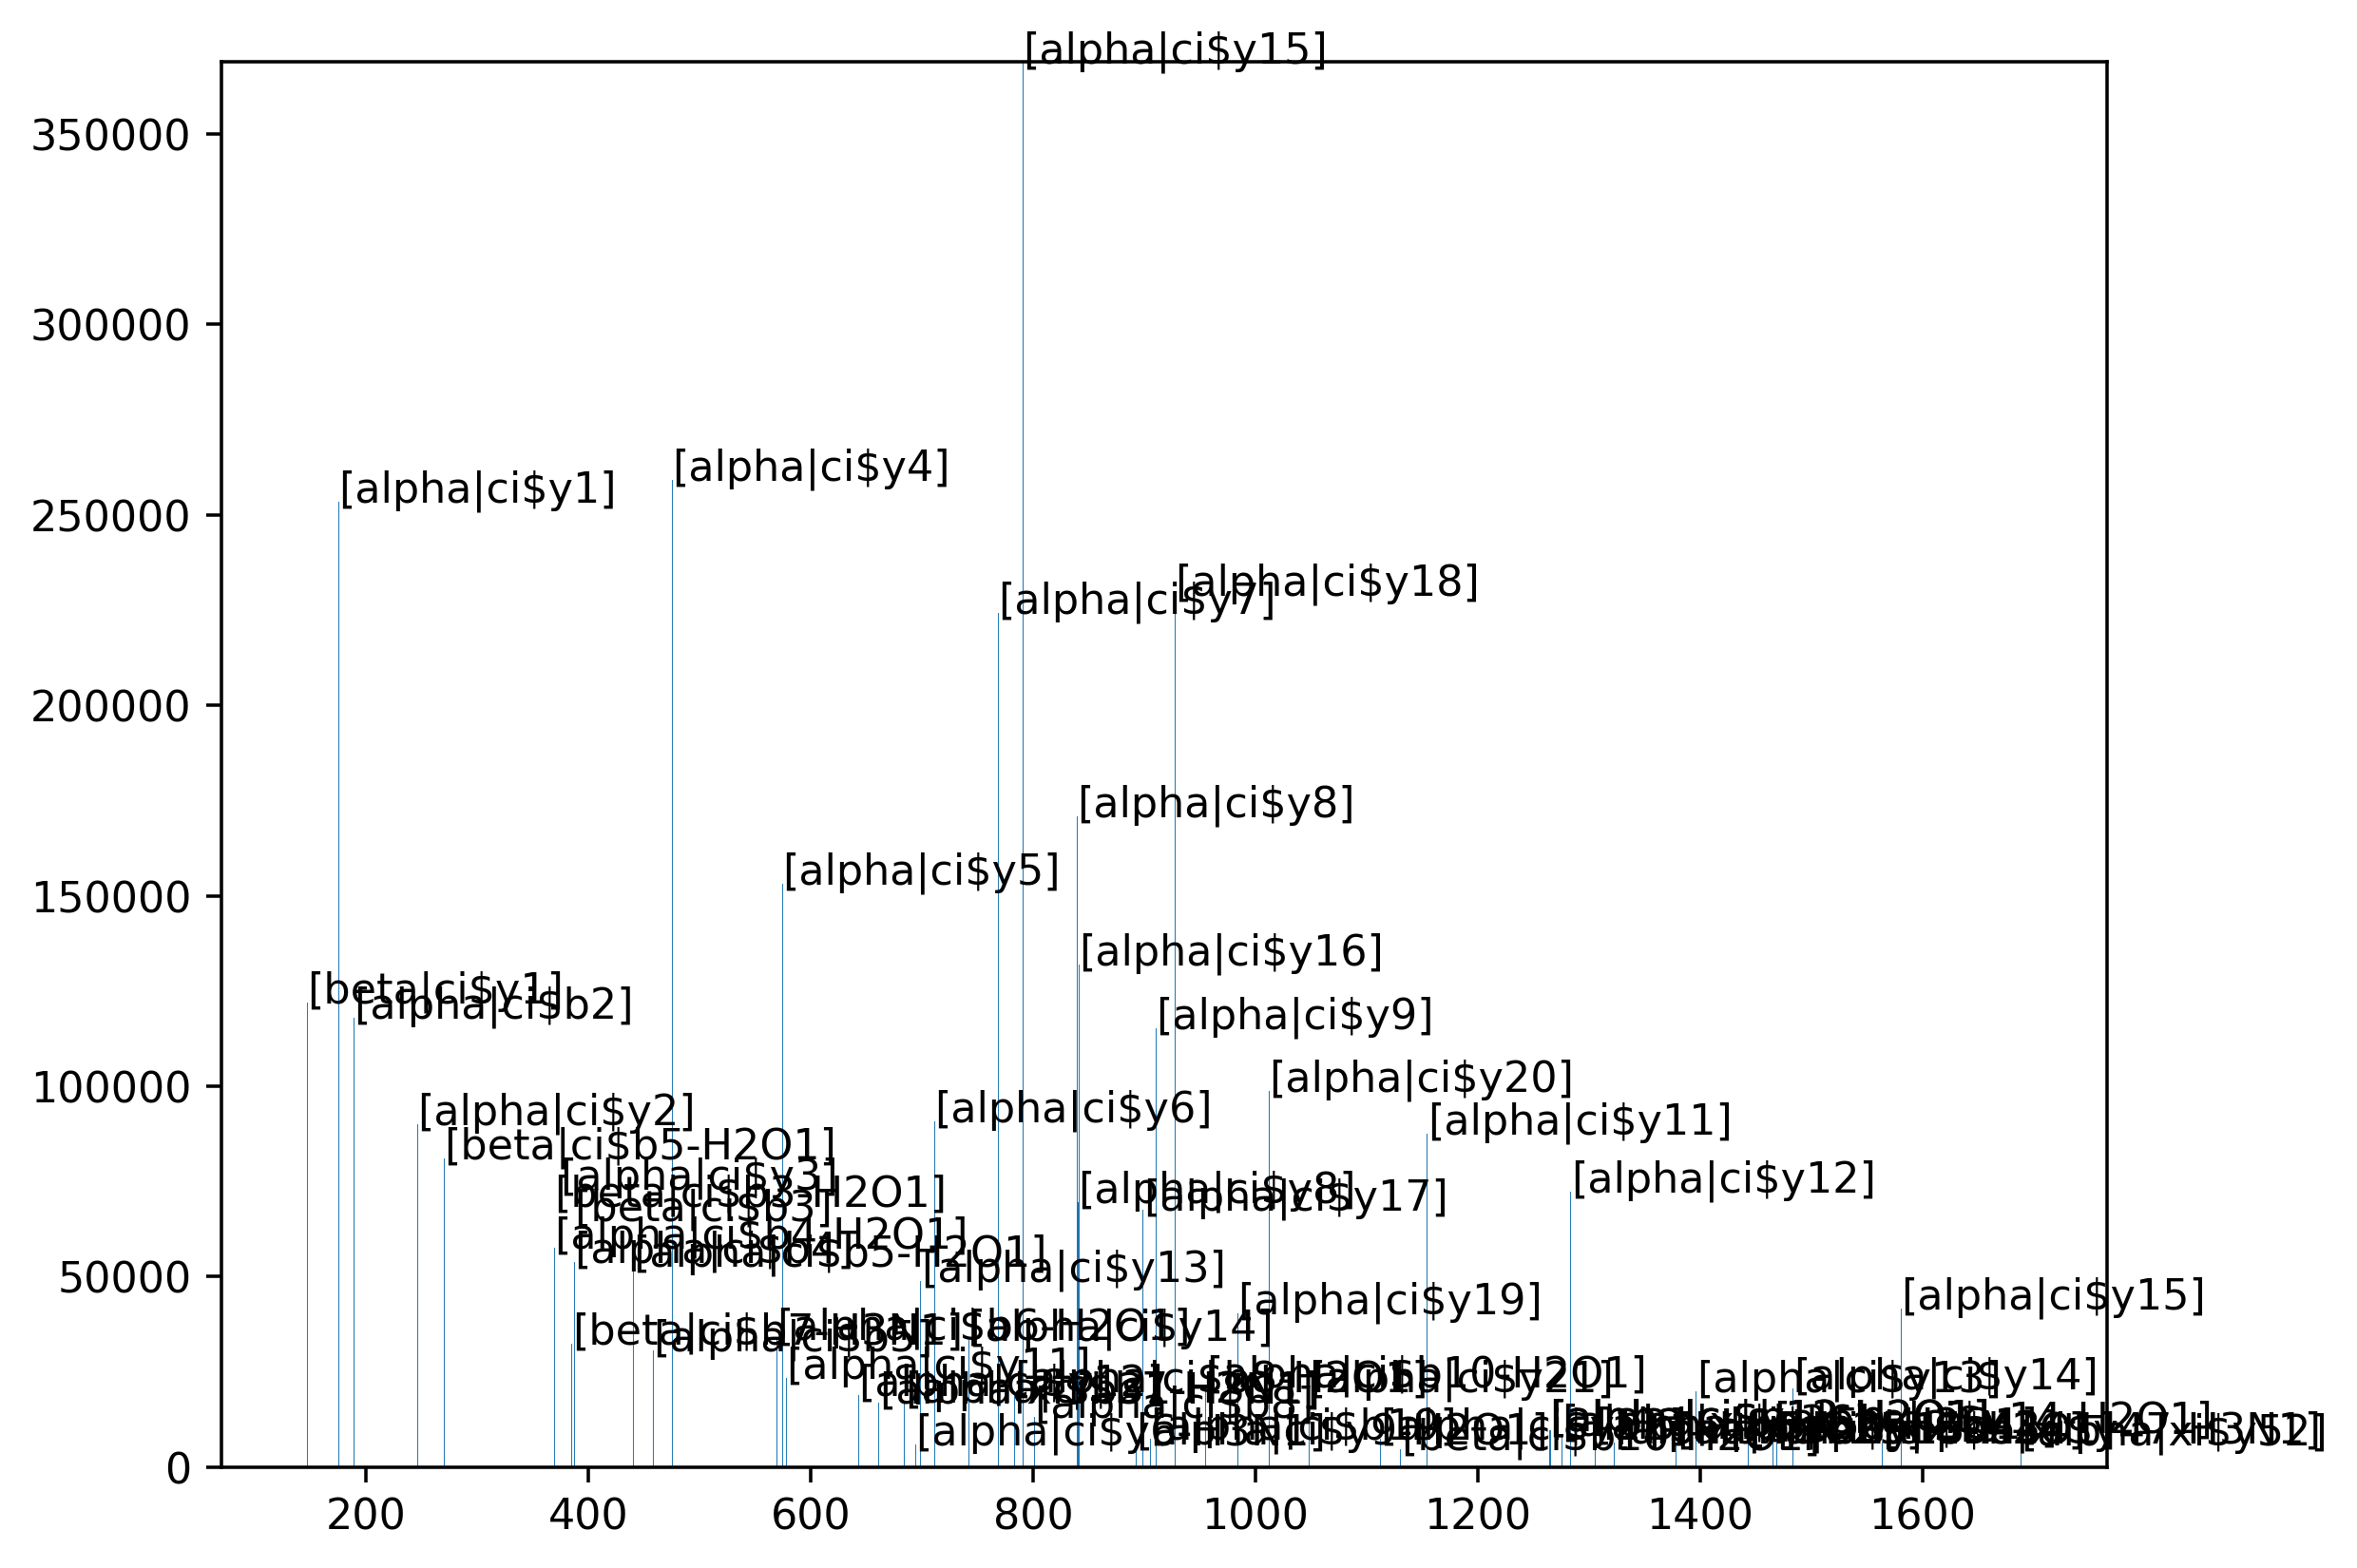

In [54]:
class XLMS_id:
    def __init__(self, pepid):
        self.pepid = pepid

    def plot(self, spec, ax = None):
        if not ax:
            ax = plt.subplot(1, 1, 1)

        alpha = XMLNode(self.pepid.find('PeptideHit[1]'))
        beta = XMLNode(self.pepid.find('PeptideHit[2]'))

        # print(alpha, beta)
        # print(alpha.fragment_annotation)

        frags = []
        for frag in split_string(alpha.fragment_annotation):
            # print(frag)
            x, y, _, label = frag.split(',')
            x = eval(x)
            y = find_intensity(x, spec.peaks())
            frags.append((x, y, eval(label)))

        frags = pd.DataFrame(frags)
        # print(frags)
        
        ax.bar(frags[0], frags[1])

        ax.set_ylim([0, frags[1].max()])

        counts = defaultdict(int)
        for i, (x, y, label) in frags.iterrows():
            yoff = counts[x] * 1
            counts[x] += 1
            ax.annotate(label, (x, y), (0, yoff), xycoords='data', textcoords='offset fontsize')

plt.figure(figsize=[8, 6], dpi=320)
xlms_id = XLMS_id(pepid_high_s2['controllerType=0 controllerNumber=1 scan=6650'][0])
xlms_id.plot(spec)

## Plot Both

              0              1                    2
0    147.112976  121850.835938         [beta|ci$y1]
1    175.119141  253494.406250        [alpha|ci$y1]
2    189.087280  117939.945312        [alpha|ci$b2]
3    246.156723   90138.726562        [alpha|ci$y2]
4    270.145111   80958.085938    [beta|ci$b5-H2O1]
5    369.177765   57534.125000   [alpha|ci$b4-H2O1]
6    369.177765   57534.125000    [beta|ci$b3-H2O1]
7    374.215454   73017.109375        [alpha|ci$y3]
8    385.172485   32370.101562    [beta|ci$b7-H3N1]
9    387.188385   53863.492188        [alpha|ci$b4]
10   387.188385   53863.492188         [beta|ci$b3]
11   440.215729   52938.890625   [alpha|ci$b5-H2O1]
12   458.231262   30606.746094        [alpha|ci$b5]
13   475.263702  259023.312500        [alpha|ci$y4]
14   569.257935   33540.937500   [alpha|ci$b6-H2O1]
15   574.332214  153085.281250        [alpha|ci$y5]
16   577.784119   23362.203125       [alpha|ci$y11]
17   642.804626   18952.597656       [alpha|ci$y12]
18   661.334

<Figure size 640x480 with 0 Axes>

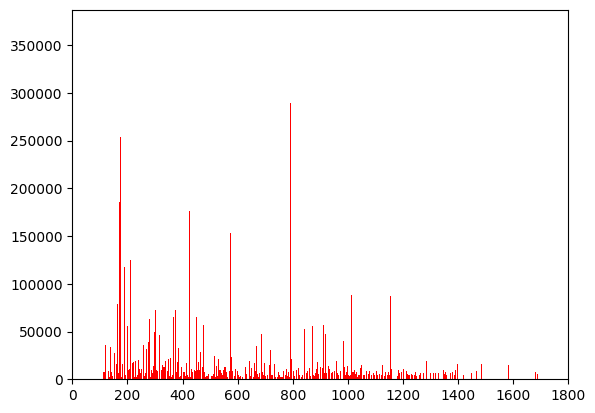

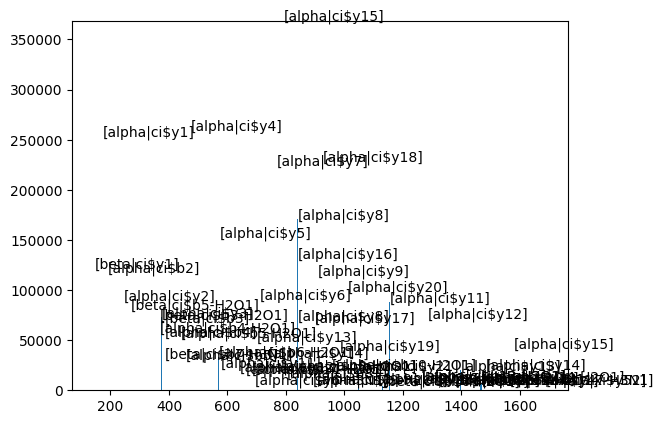

In [44]:
spec_ref = 'controllerType=0 controllerNumber=1 scan=6650'

# ax = plt.subplot(1, 1, 1)
plt.figure()
spec = Spectrum(mzml.find(spec_ref))
spec.plot(1800)

plt.figure()
xlms_id = XLMS_id(pepid_high_s2[spec_ref][0])
xlms_id.plot(spec)

In [45]:
XMLNode(pepid_high_s2[spec_ref][1].find('PeptideHit'))['OpenPepXL:score'] * 300

180.951453874131

In [47]:
XMLNode(pepid_high_s2[spec_ref][0].find('PeptideHit[1]')).d

{'score': '0.610411639586962',
 'sequence': 'STPTAEDVTAPLVDEGAPGKQAAAQPHTEIPEGTTAEEAGIGDTPSLEDEAAGHVTQAR',
 'charge': '7',
 'aa_before': 'K',
 'aa_after': 'M',
 'start': '67',
 'end': '125',
 'protein_refs': 'PH_3',
 'fragment_annotation': '147.11297607421875,0.330428957939148,1,"[beta|ci$y1]"|175.119140625,0.687413394451141,1,"[alpha|ci$y1]"|189.0872802734375,0.348306834697723,1,"[alpha|ci$b2]"|246.156723022460938,0.244433671236038,1,"[alpha|ci$y2]"|270.145111083984375,0.219538062810898,2,"[beta|ci$b5-H2O1]"|369.177764892578125,0.156018152832985,1,"[alpha|ci$b4-H2O1]"|369.177764892578125,0.156018152832985,1,"[beta|ci$b3-H2O1]"|374.2154541015625,0.259393662214279,1,"[alpha|ci$y3]"|385.1724853515625,0.087779611349106,2,"[beta|ci$b7-H3N1]"|387.188385009765625,0.188750565052032,1,"[alpha|ci$b4]"|387.188385009765625,0.188750565052032,1,"[beta|ci$b3]"|440.215728759765625,0.192918971180916,1,"[alpha|ci$b5-H2O1]"|458.23126220703125,0.082997836172581,1,"[alpha|ci$b5]"|475.263702392578125,0.916

In [48]:
XMLNode(pepid_high_s2[spec_ref][1].find('PeptideHit[1]')).d

{'score': '0.60317151291377',
 'sequence': 'STPTAEDVTAPLVDEGAPGKQAAAQPHTEIPEGTTAEEAGIGDTPSLEDEAAGHVTQAR',
 'charge': '7',
 'aa_before': 'K',
 'aa_after': 'M',
 'start': '67',
 'end': '125',
 'protein_refs': 'PH_3',
 'fragment_annotation': '147.11297607421875,0.330428957939148,1,"[beta|ci$y1]"|175.119140625,0.687413394451141,1,"[alpha|ci$y1]"|189.0872802734375,0.348306834697723,1,"[alpha|ci$b2]"|246.156723022460938,0.244433671236038,1,"[alpha|ci$y2]"|270.145111083984375,0.219538062810898,2,"[beta|ci$b5-H2O1]"|369.177764892578125,0.156018152832985,1,"[alpha|ci$b4-H2O1]"|369.177764892578125,0.156018152832985,1,"[beta|ci$b3-H2O1]"|374.2154541015625,0.259393662214279,1,"[alpha|ci$y3]"|385.1724853515625,0.087779611349106,2,"[beta|ci$b7-H3N1]"|387.188385009765625,0.188750565052032,1,"[alpha|ci$b4]"|387.188385009765625,0.188750565052032,1,"[beta|ci$b3]"|440.215728759765625,0.192918971180916,1,"[alpha|ci$b5-H2O1]"|458.23126220703125,0.082997836172581,1,"[alpha|ci$b5]"|475.263702392578125,0.9161

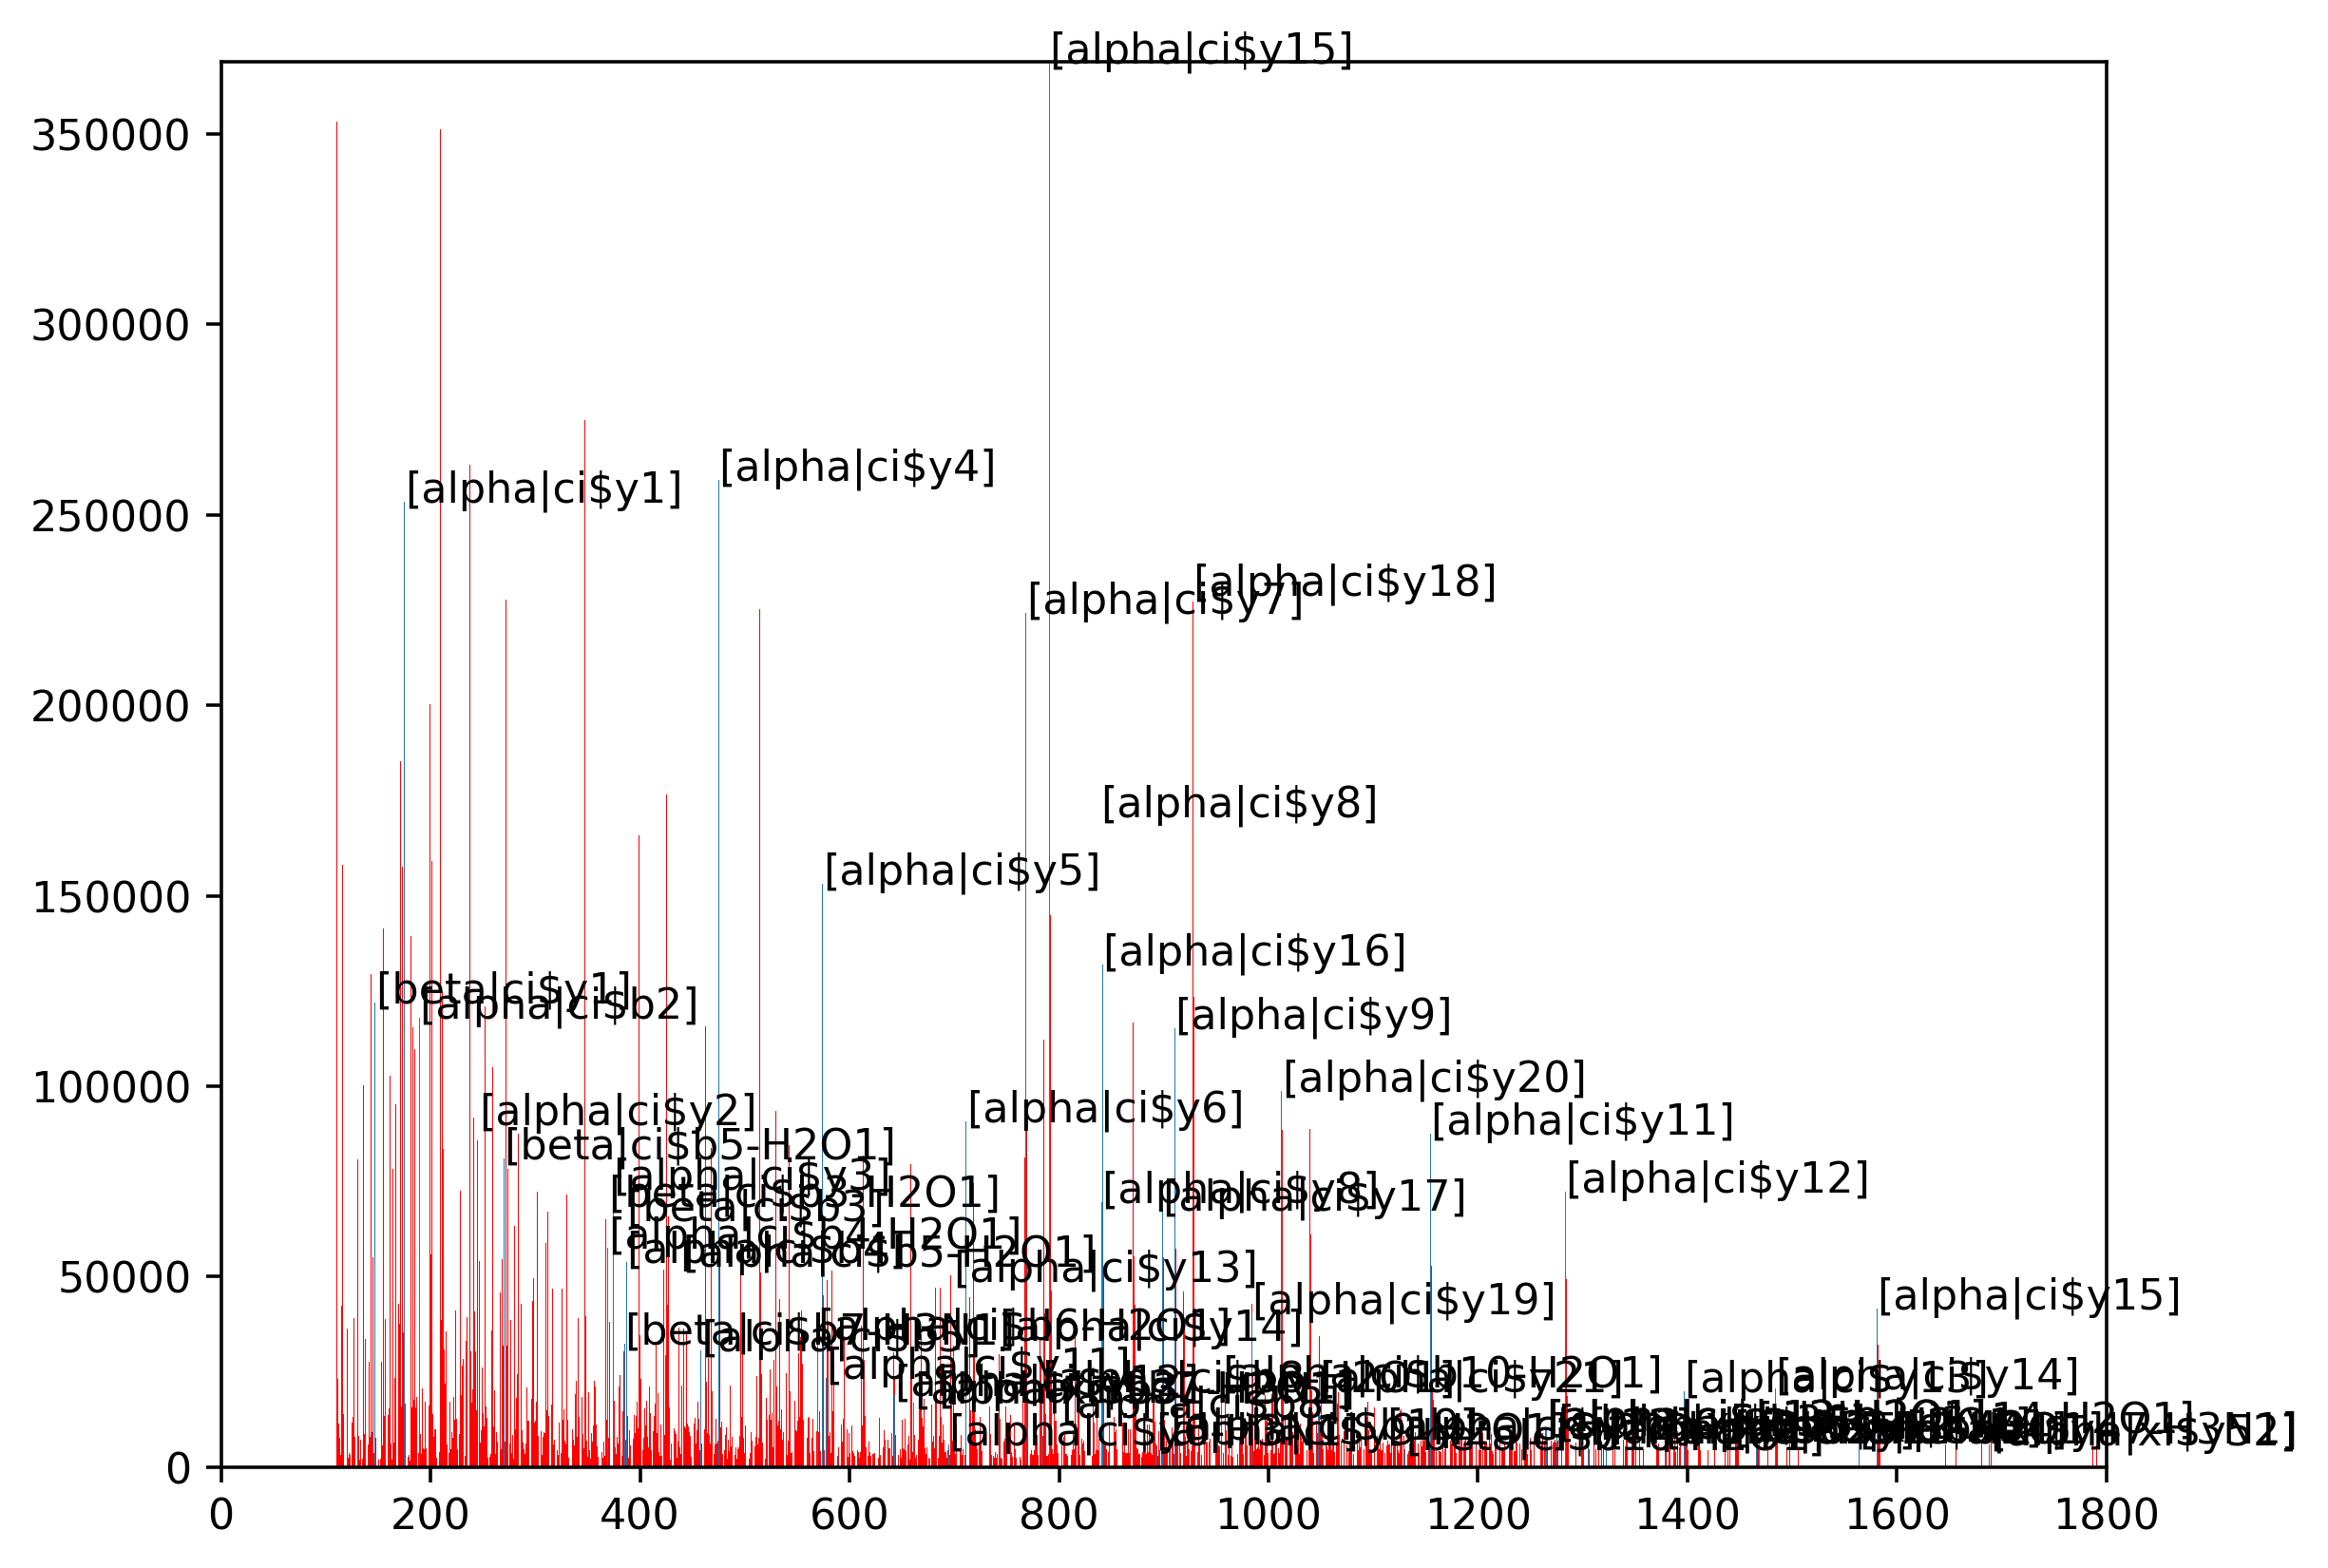

In [55]:
spec_ref = 'controllerType=0 controllerNumber=1 scan=6650'

plt.figure(figsize=[8, 6], dpi=320)
ax = plt.subplot(1, 1, 1)

spec = Spectrum(mzml.find(spec_ref))
spec.plot(1800, ax)

xlms_id = XLMS_id(pepid_high_s2[spec_ref][0])
xlms_id.plot(spec, ax)

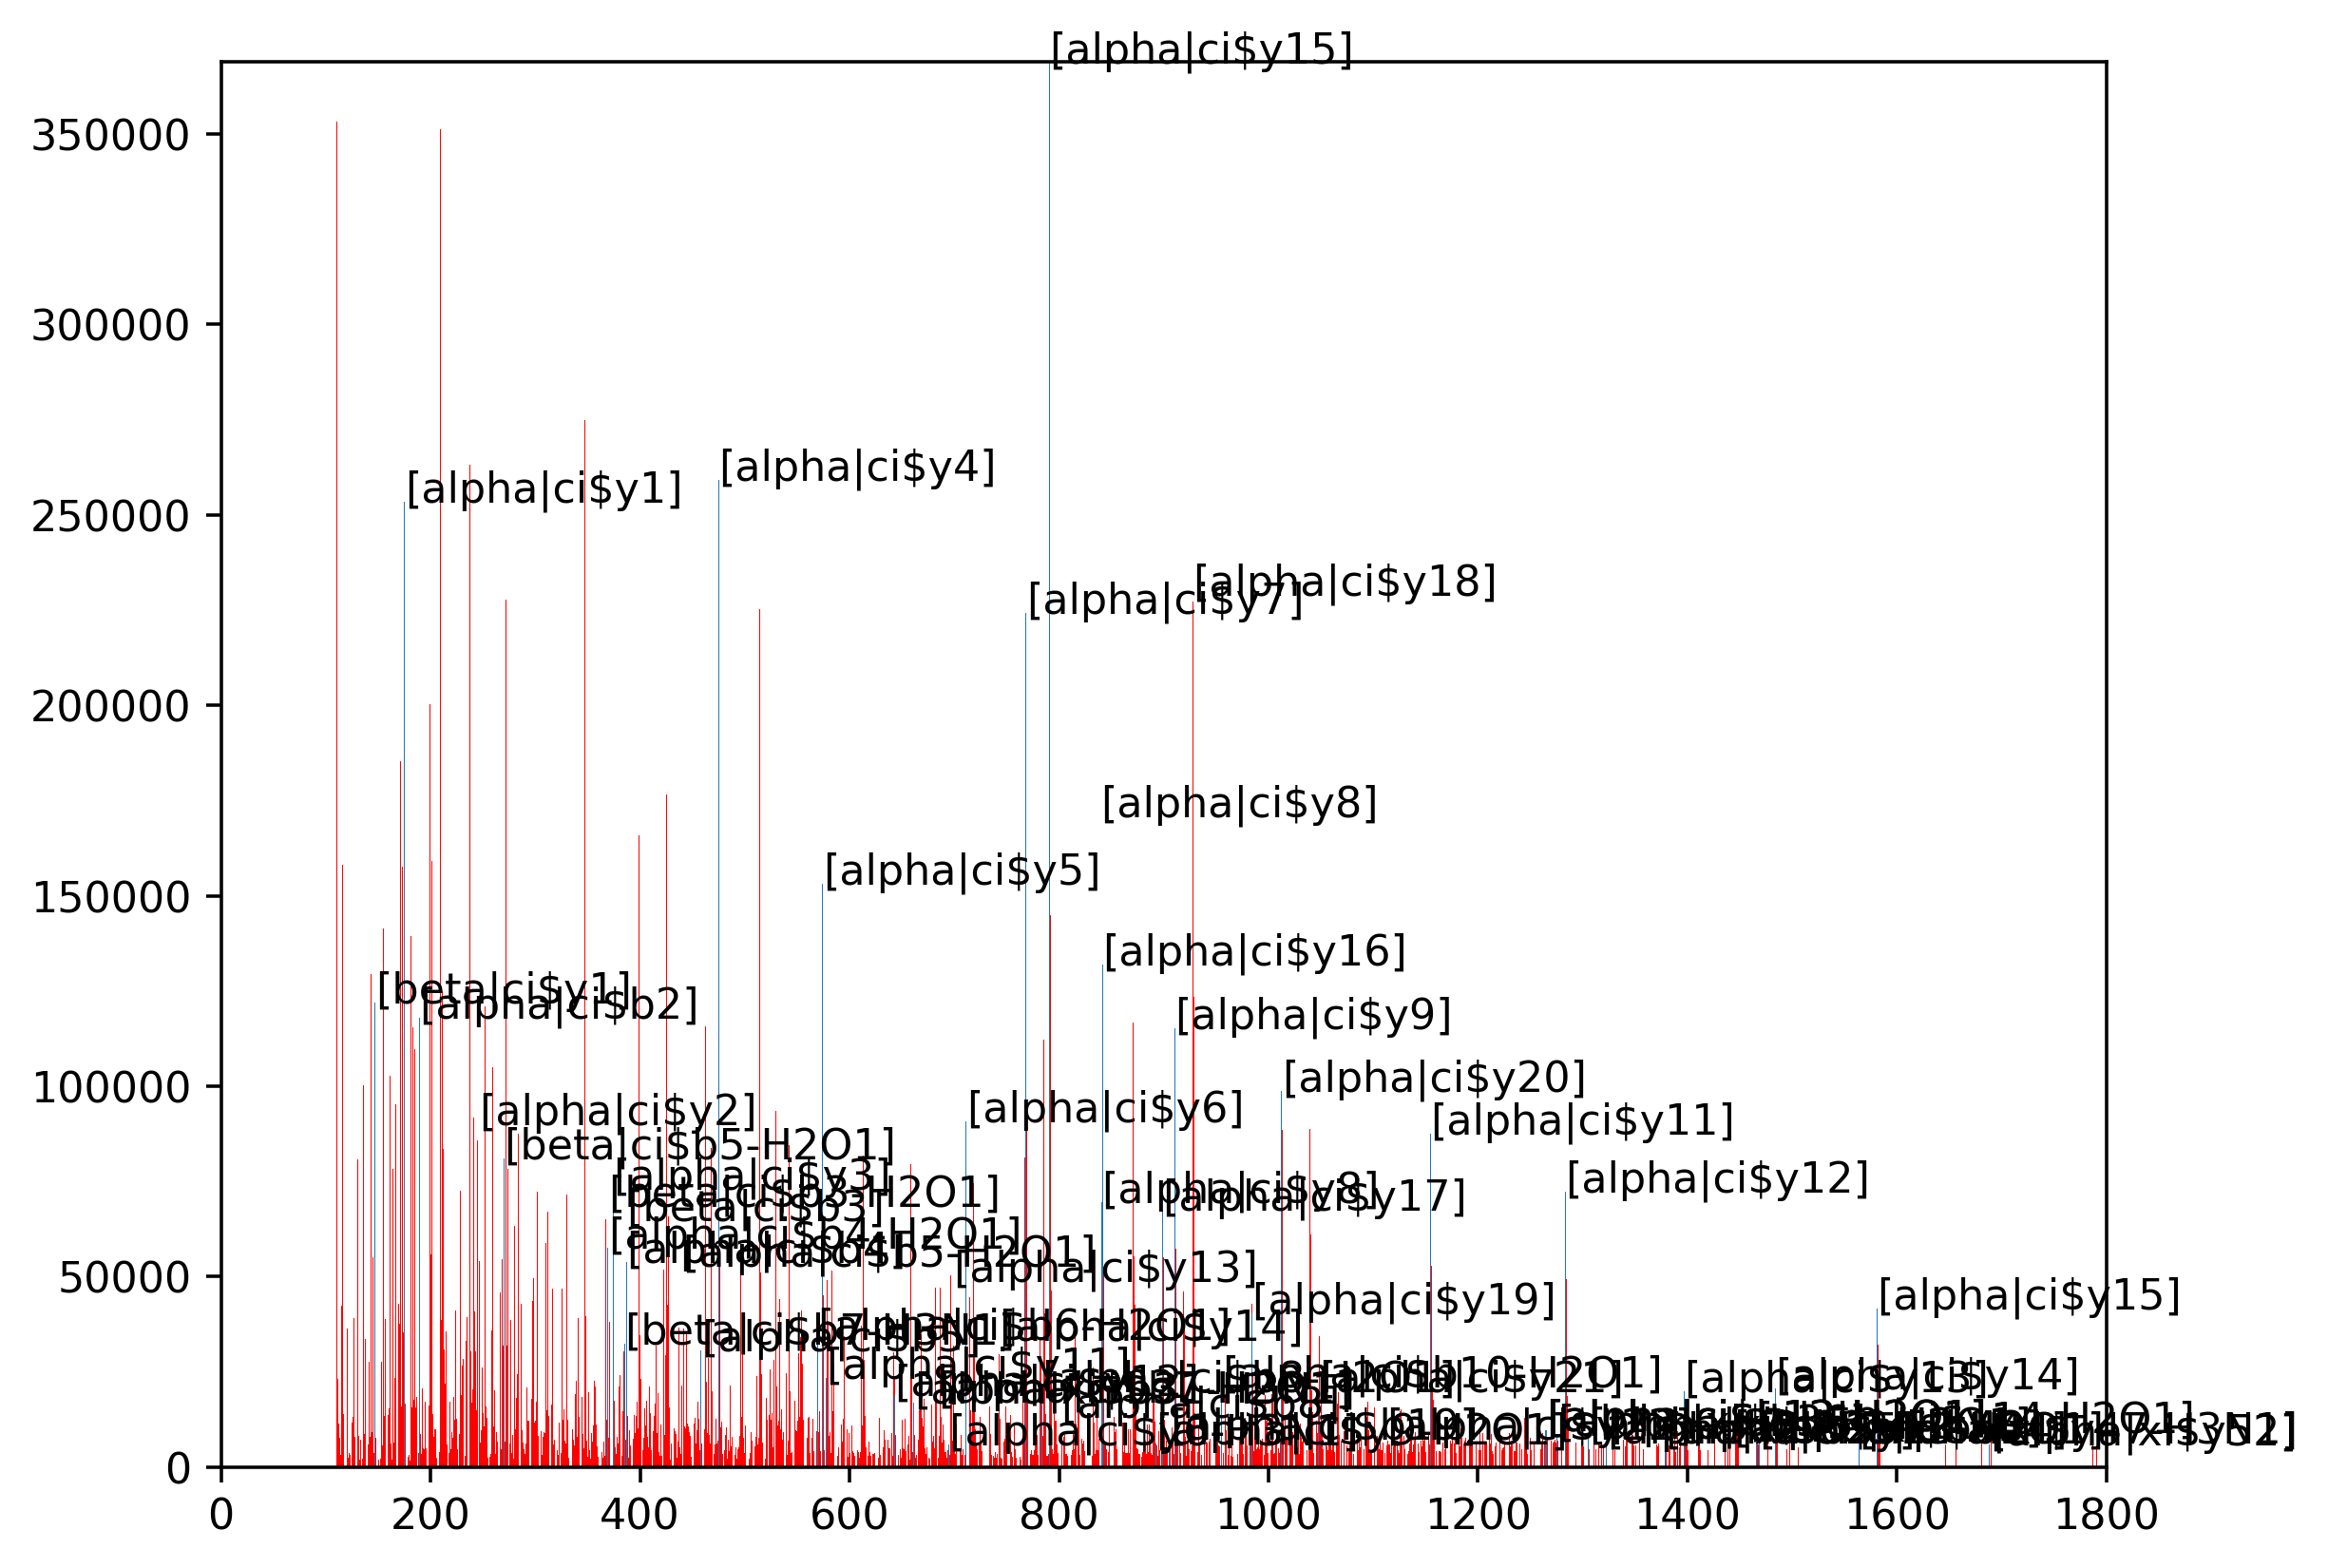

In [56]:
spec_ref = 'controllerType=0 controllerNumber=1 scan=6650'

plt.figure(figsize=[8, 6], dpi=320)
ax = plt.subplot(1, 1, 1)

spec = Spectrum(mzml.find(spec_ref))
spec.plot(1800, ax)

xlms_id = XLMS_id(pepid_high_s2[spec_ref][1])
xlms_id.plot(spec, ax)

## Plot for dataset

In [67]:
def plot_annotated_spec(spec_ref, search_res, mzml):
    plt.figure(figsize=[8, 6], dpi=160)
    ax = plt.subplot(1, 1, 1)
    
    spec = Spectrum(mzml.find(spec_ref))
    spec.plot(1800, ax)
    
    xlms_id = XLMS_id(search_res)
    xlms_id.plot(spec, ax)
    return ax

In [68]:
import os

In [69]:
figure_dir = '../spectrum_plots/'
if not os.path.exists(figure_dir):
    os.makedirs(figure_dir)

def plot_annotated_top2_matches(spec_ref, matches, mzml):
    for i in range(2):
        title = f'{spec_ref.split()[-1]} rank={i + 1}'
        ax = plot_annotated_spec(spec_ref, matches[spec_ref][i], mzml)
        ax.set_title(title)
        plt.savefig(f'{figure_dir}/{title}.png')
        

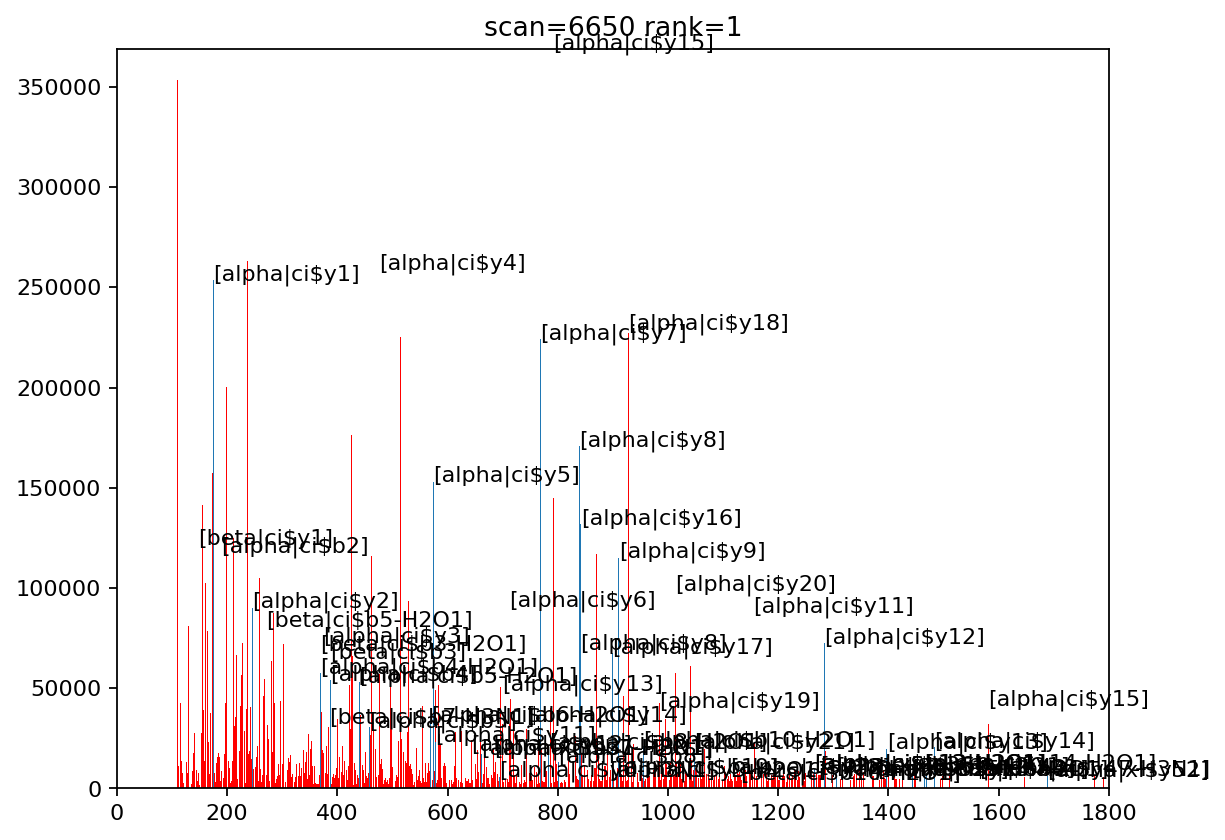

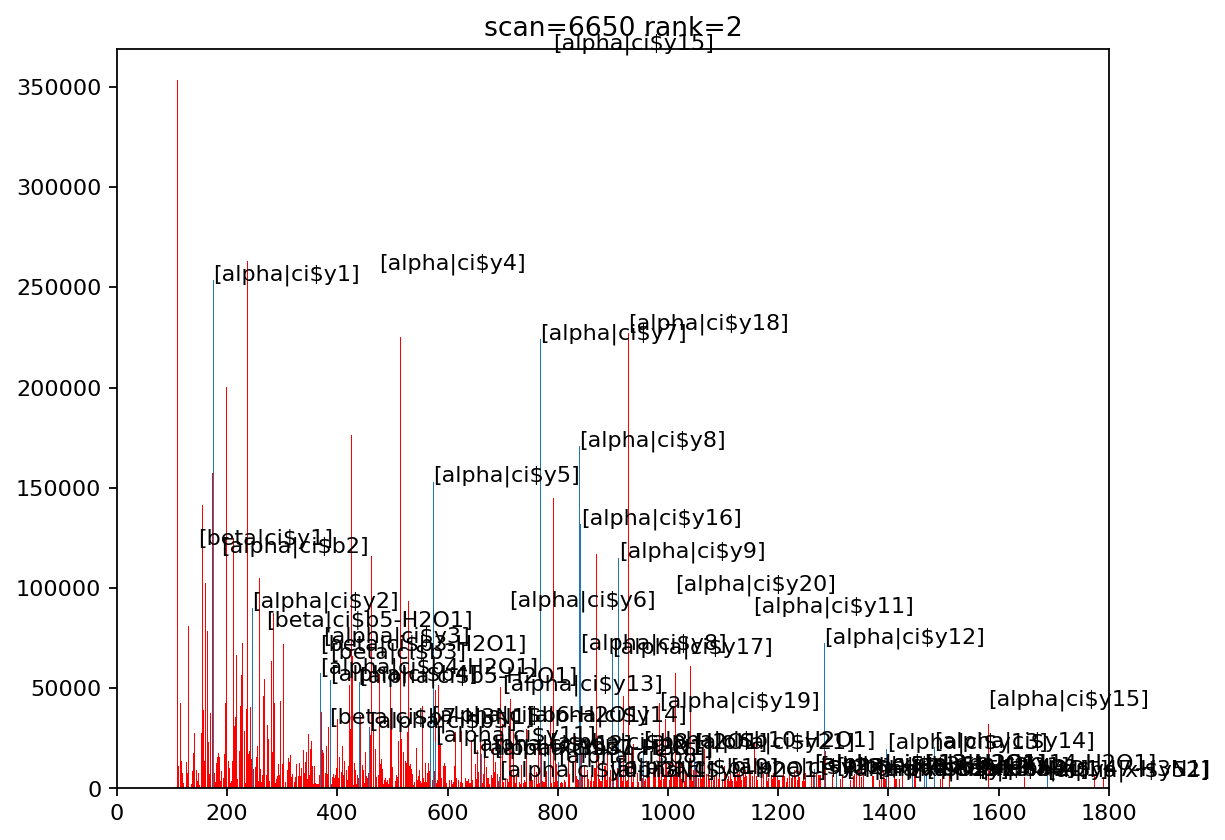

In [70]:
plot_annotated_top2_matches(spec_ref, pepid_high_s2, mzml)

/tmp/ipykernel_132586/4147572800.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=[8, 6], dpi=160)


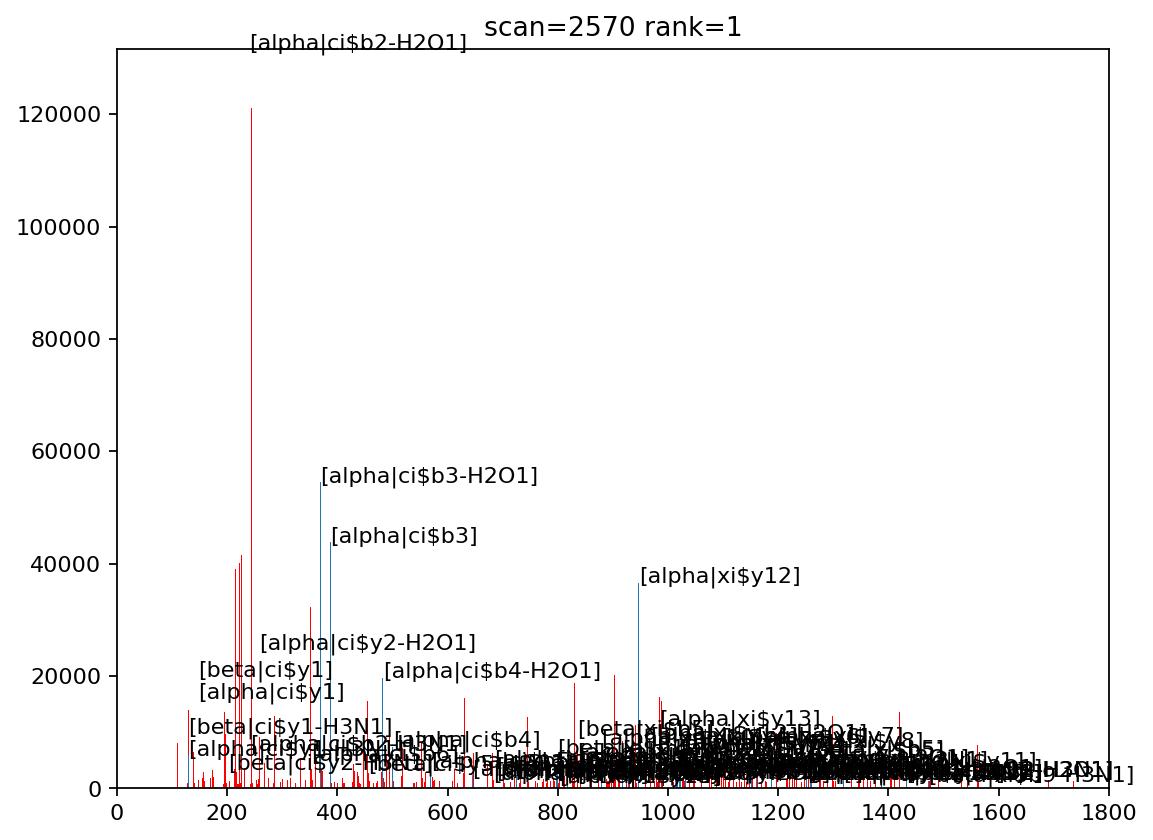

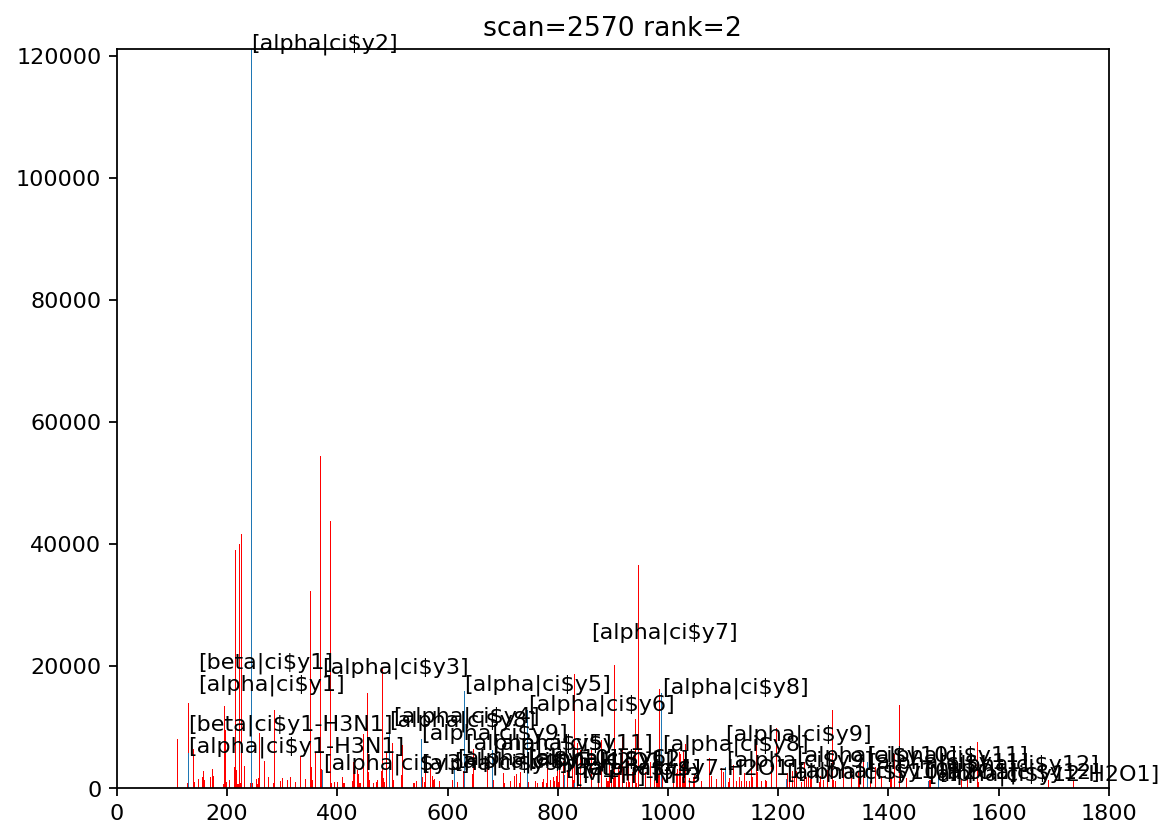

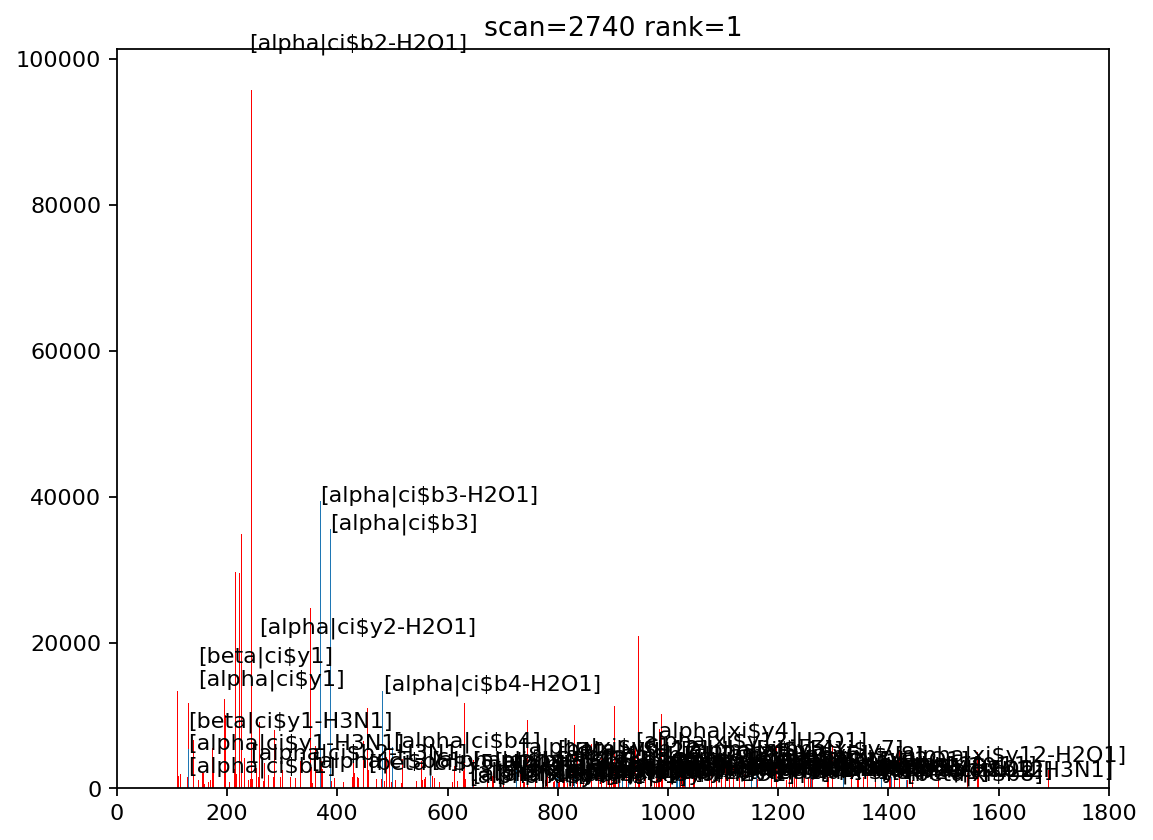

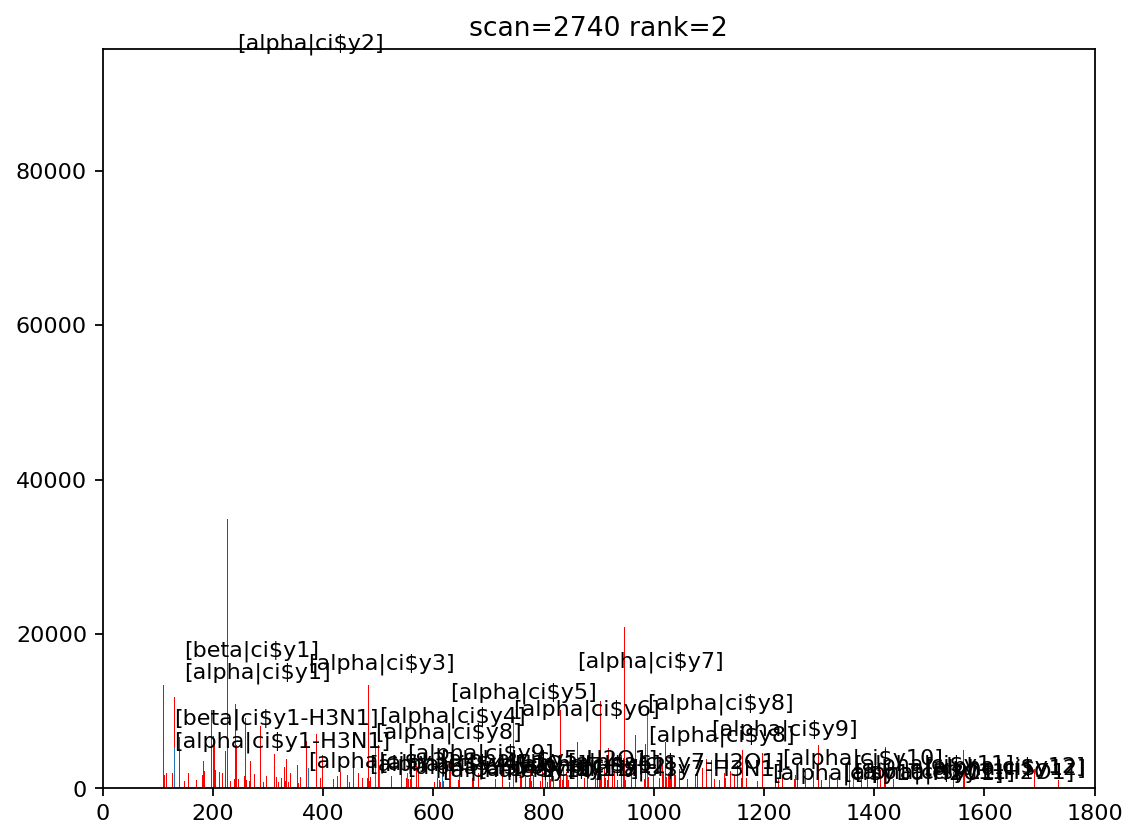

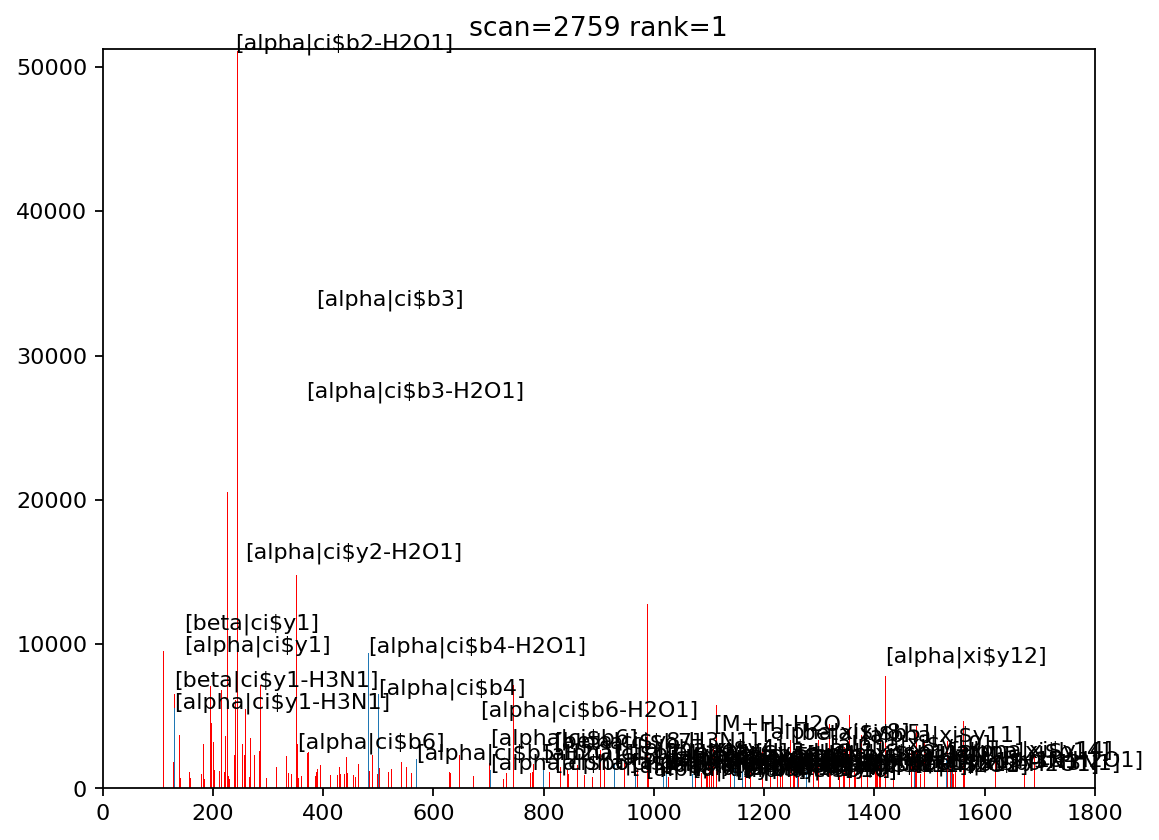

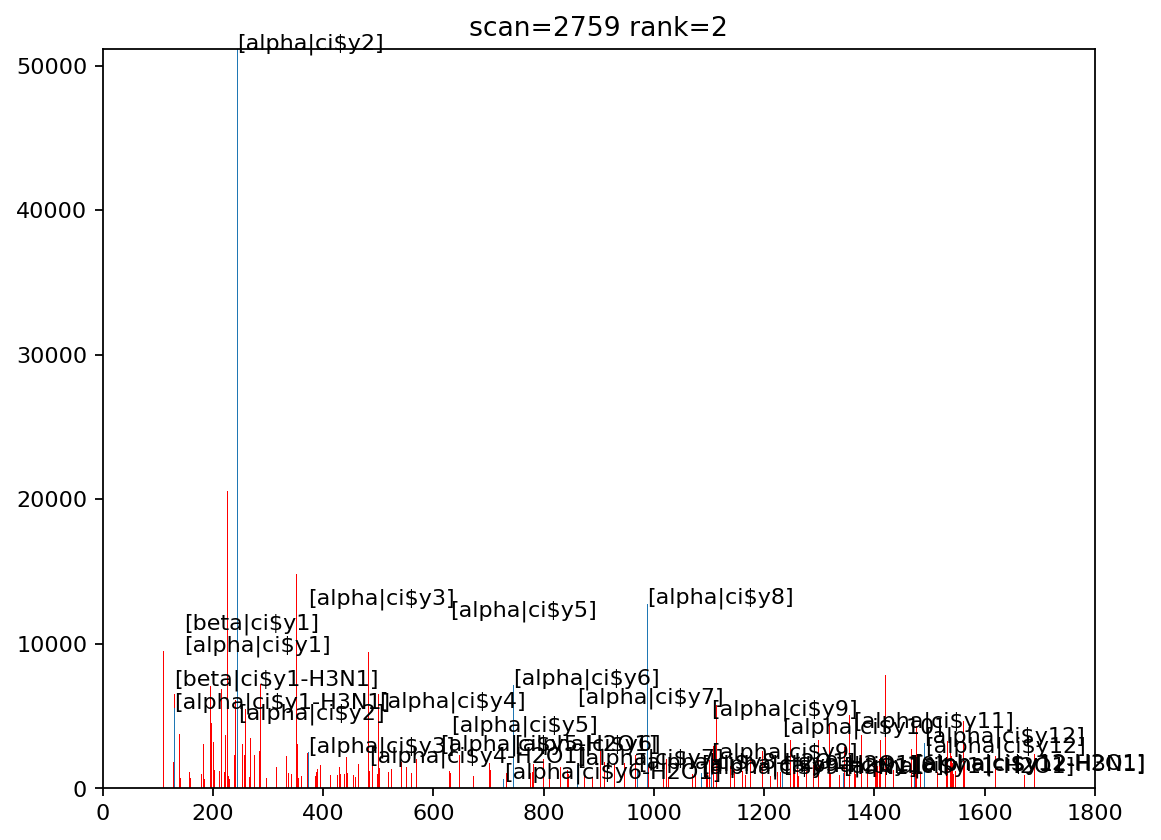

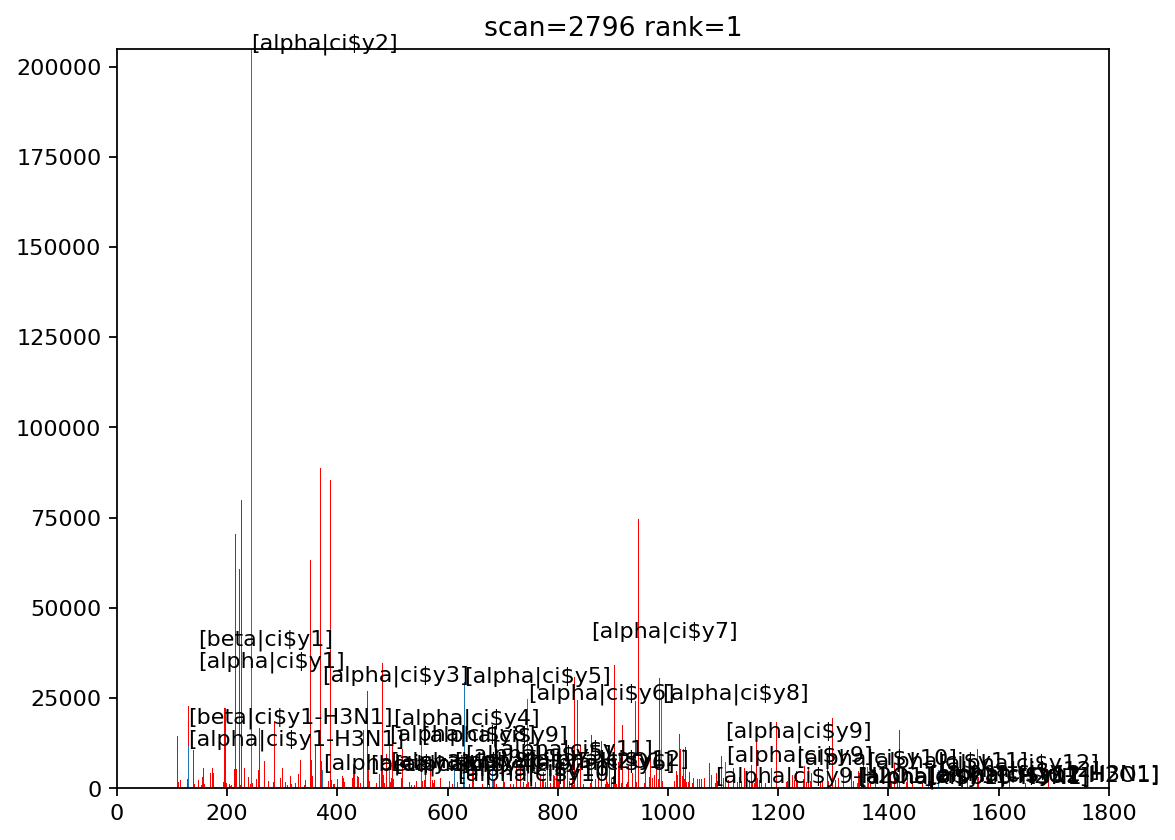

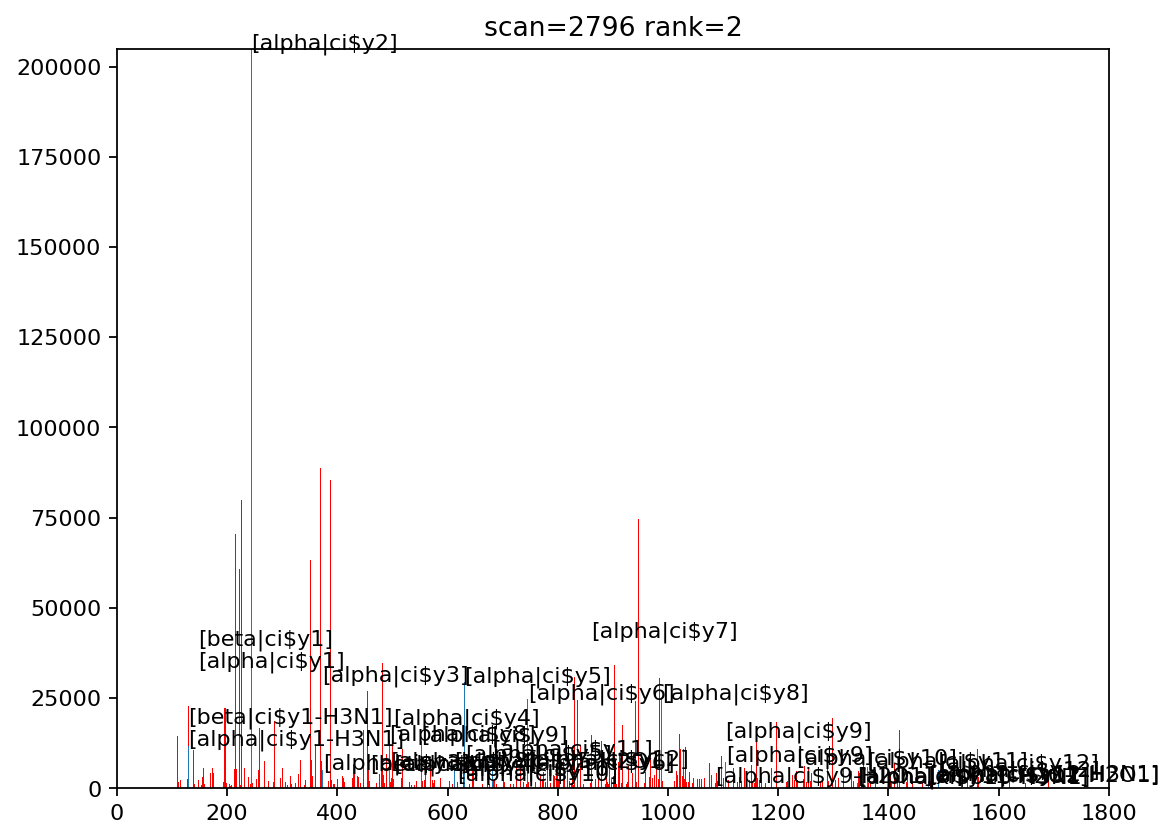

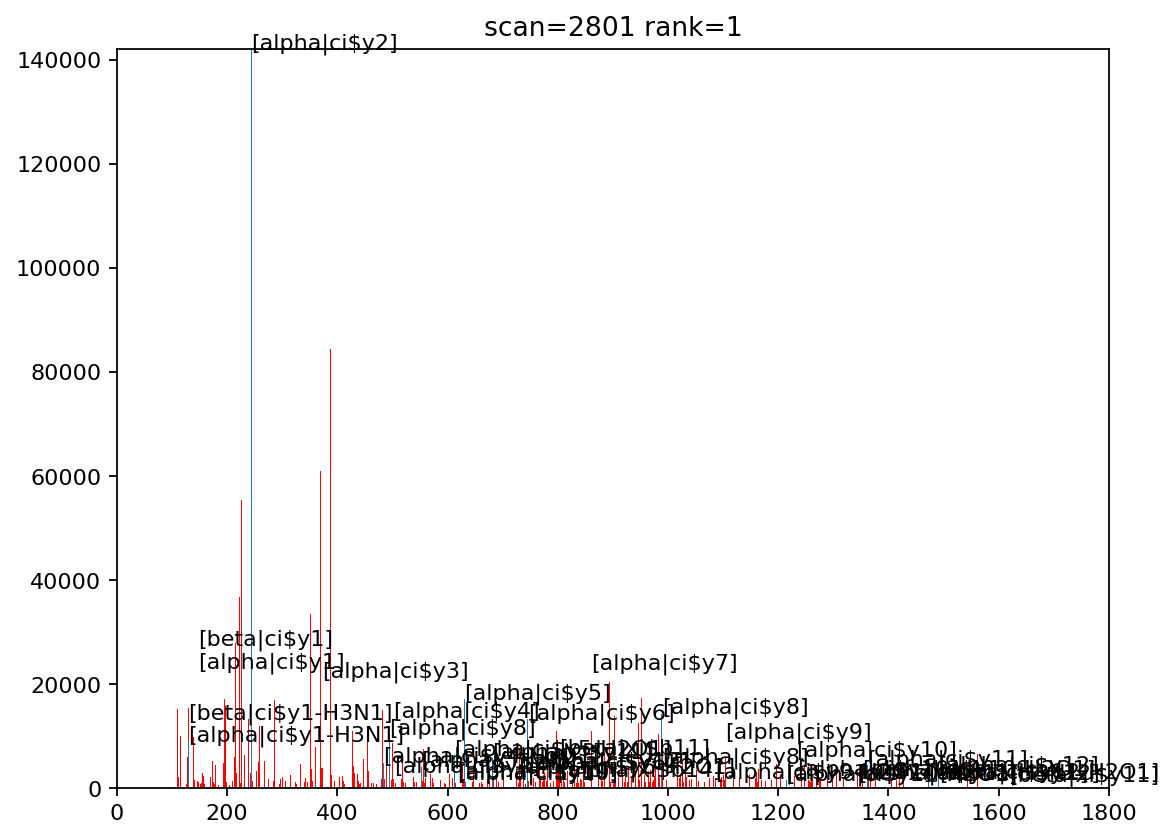

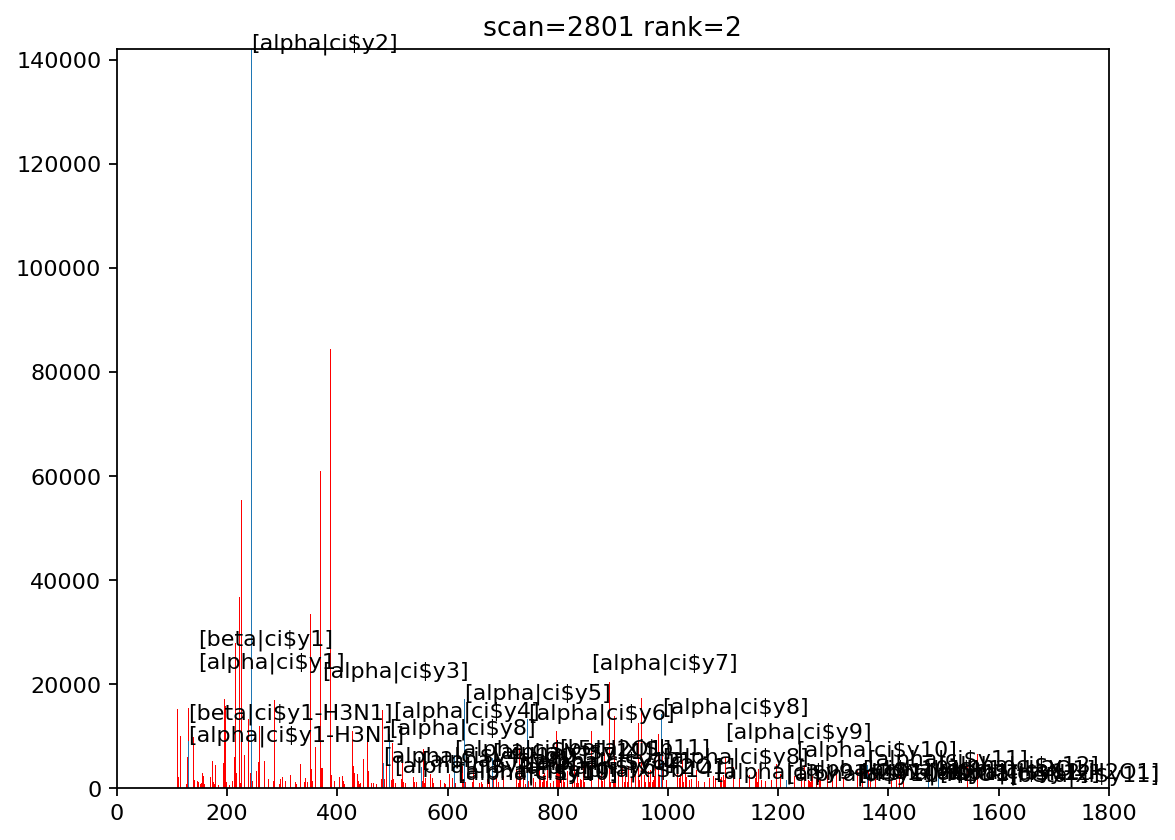

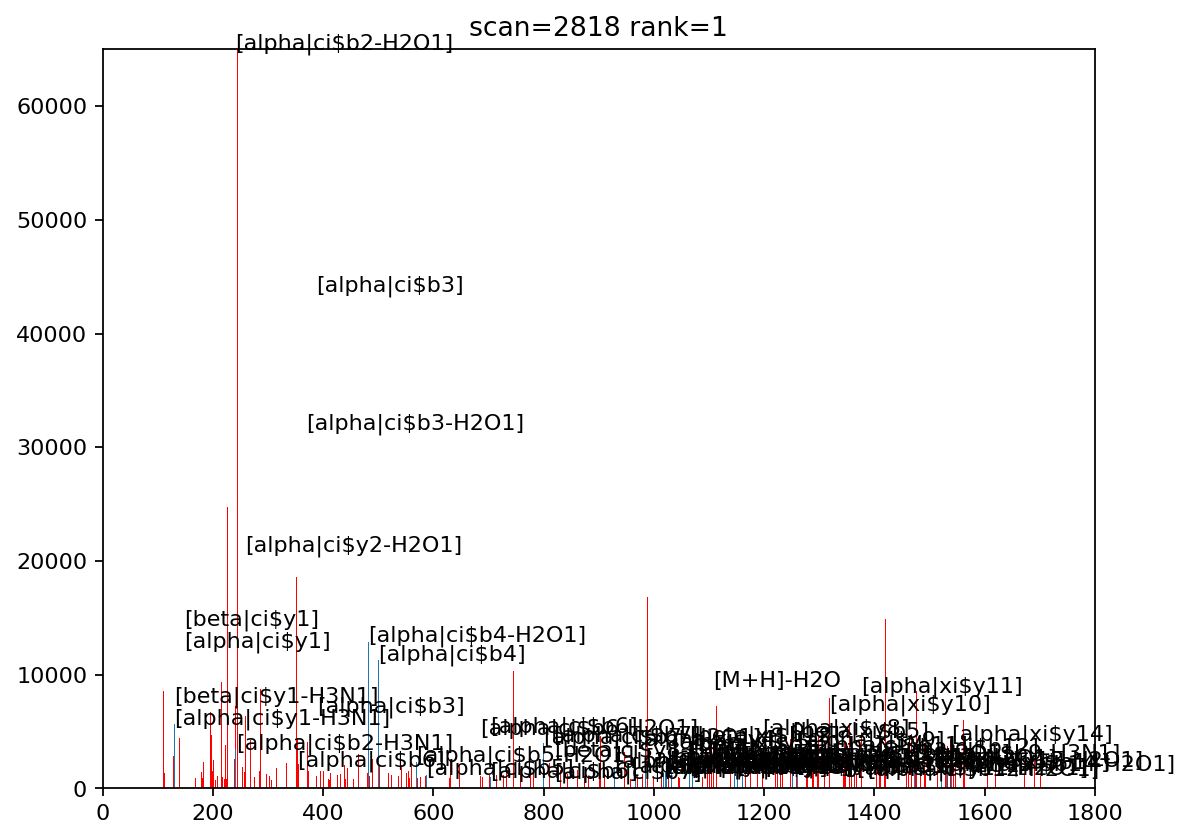

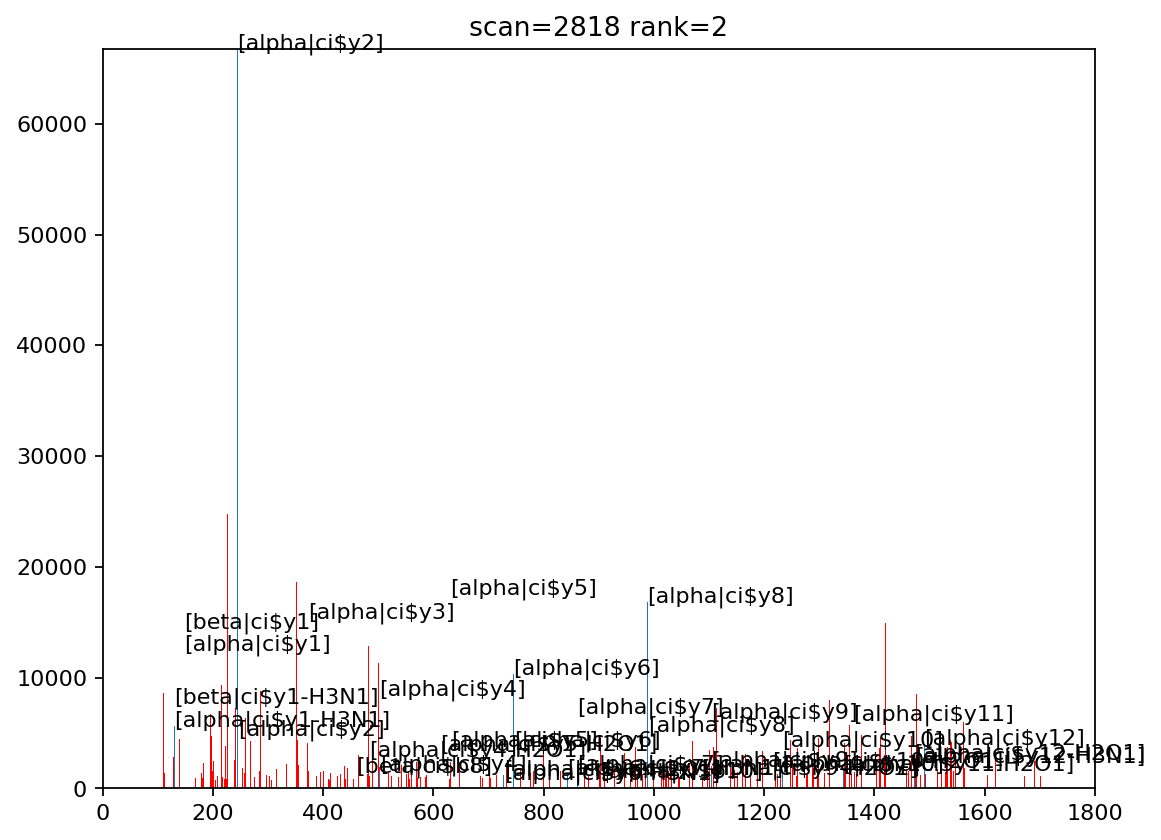

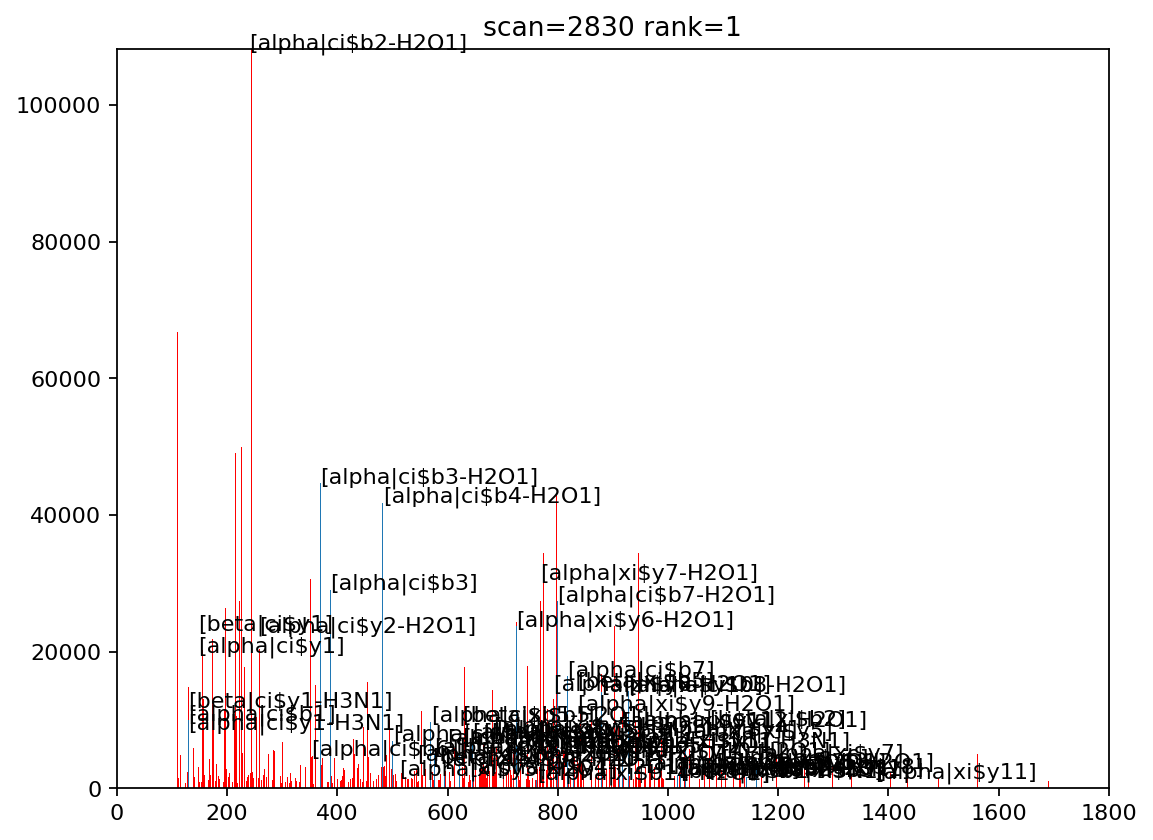

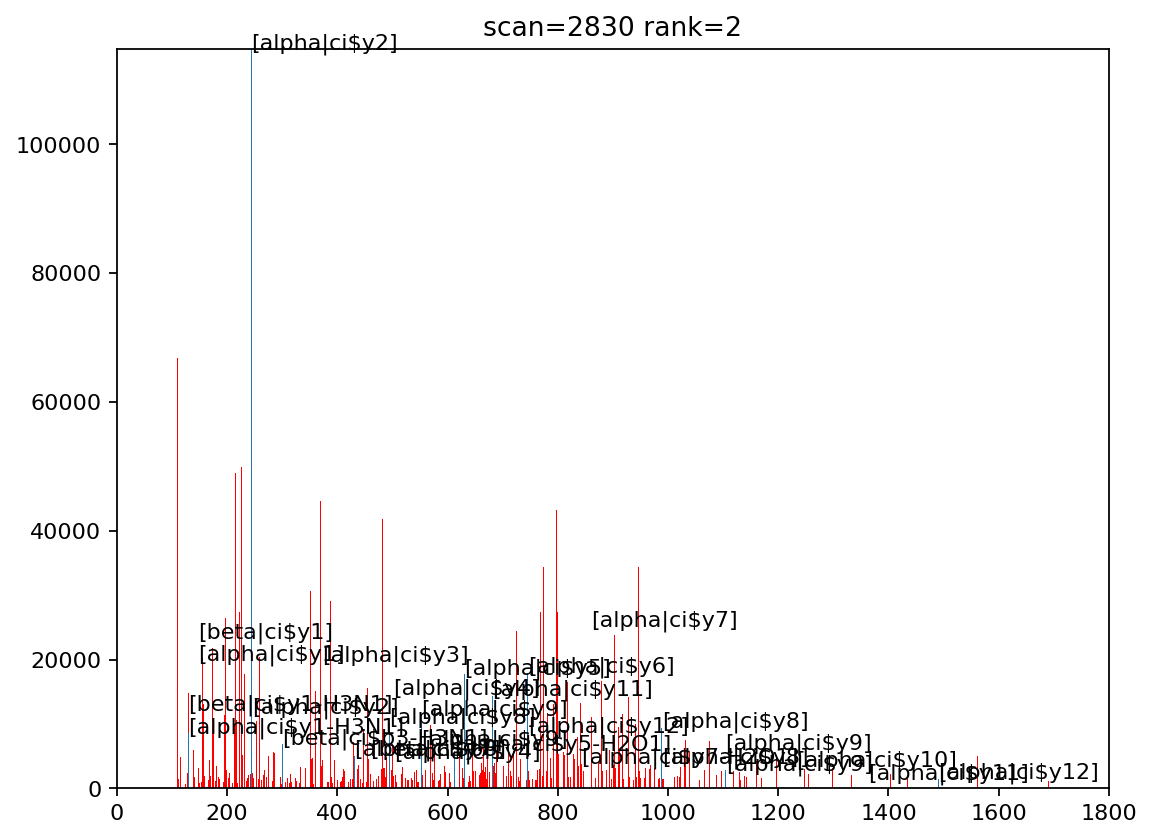

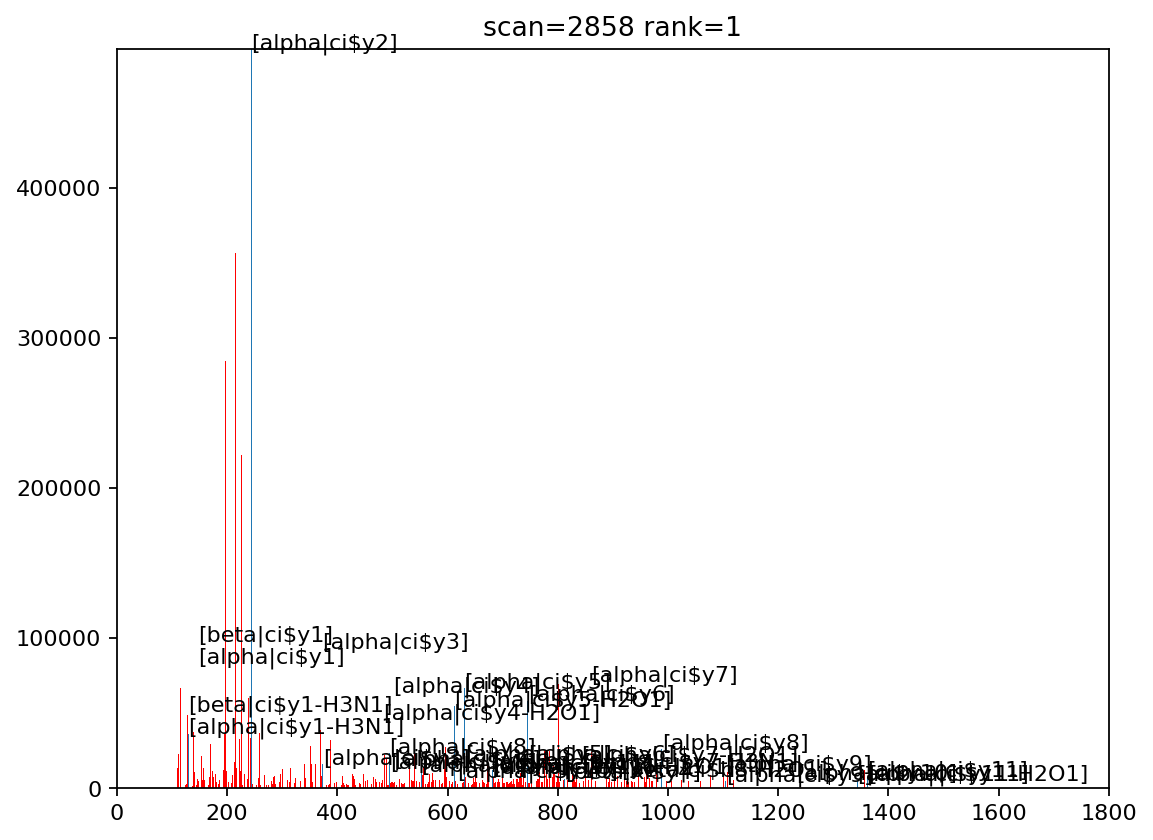

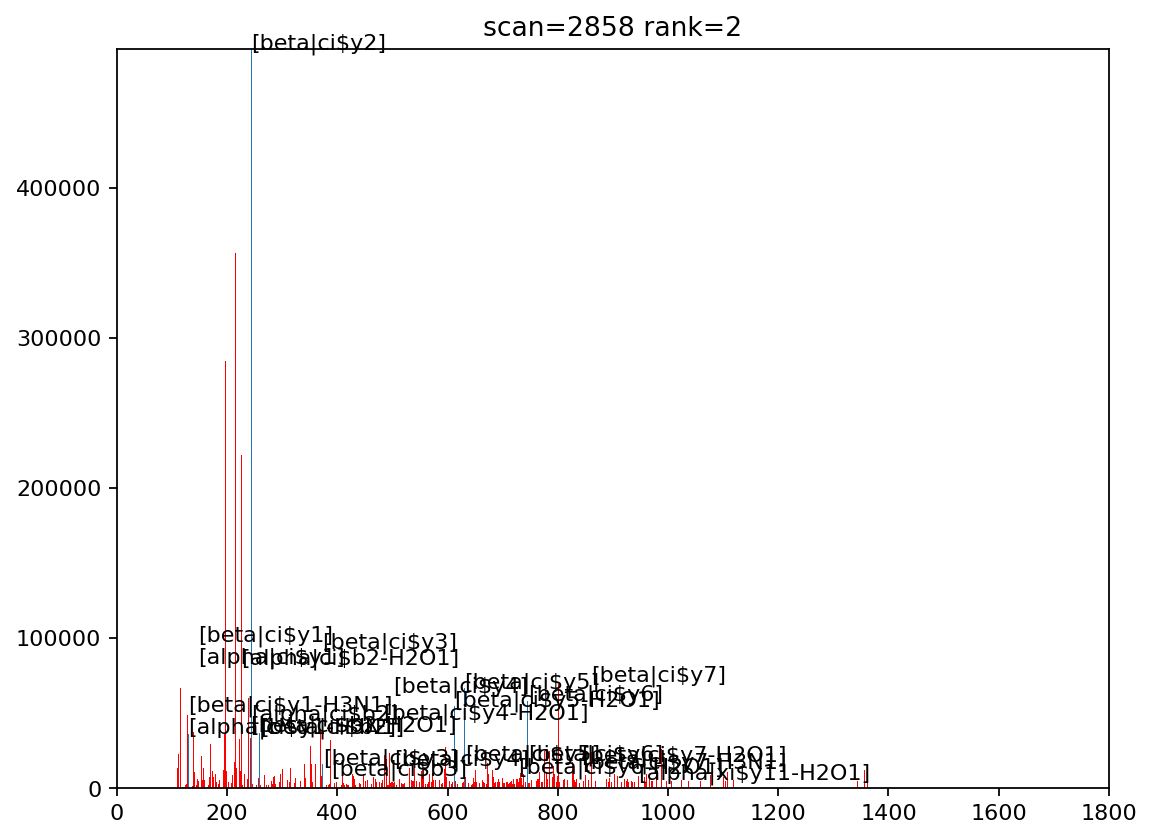

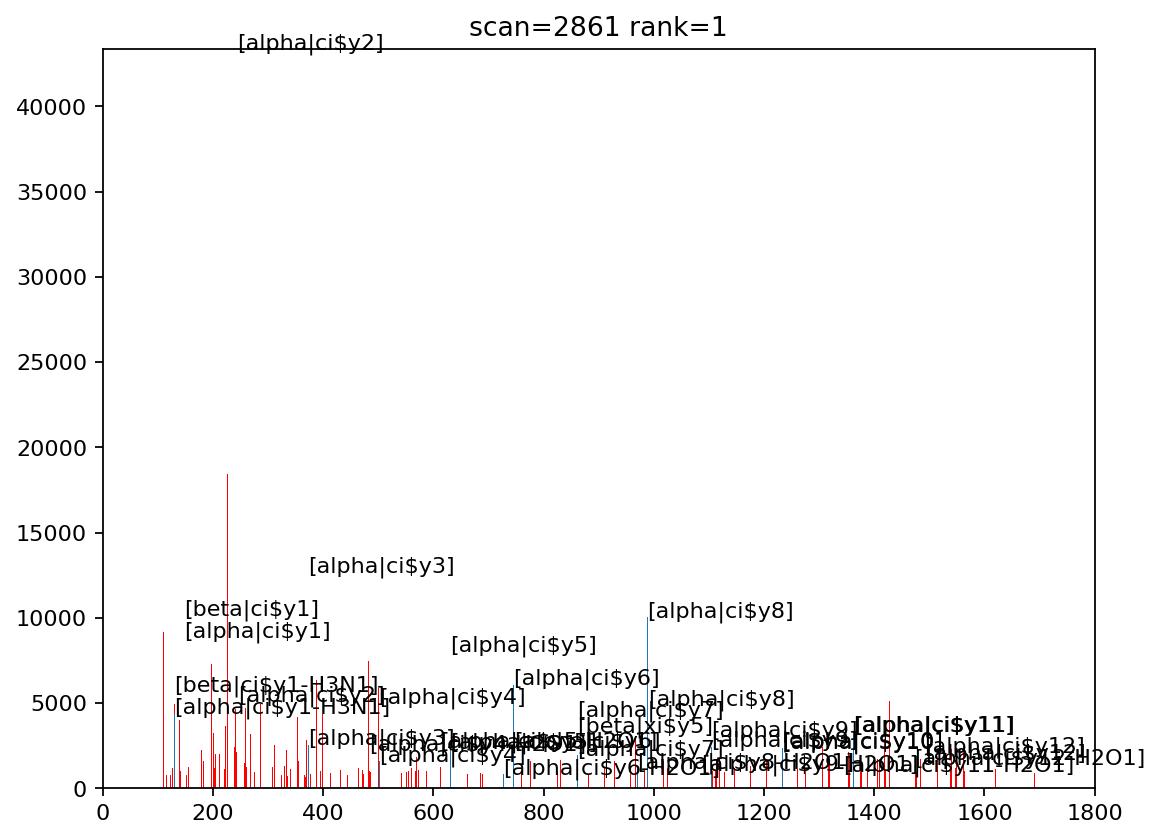

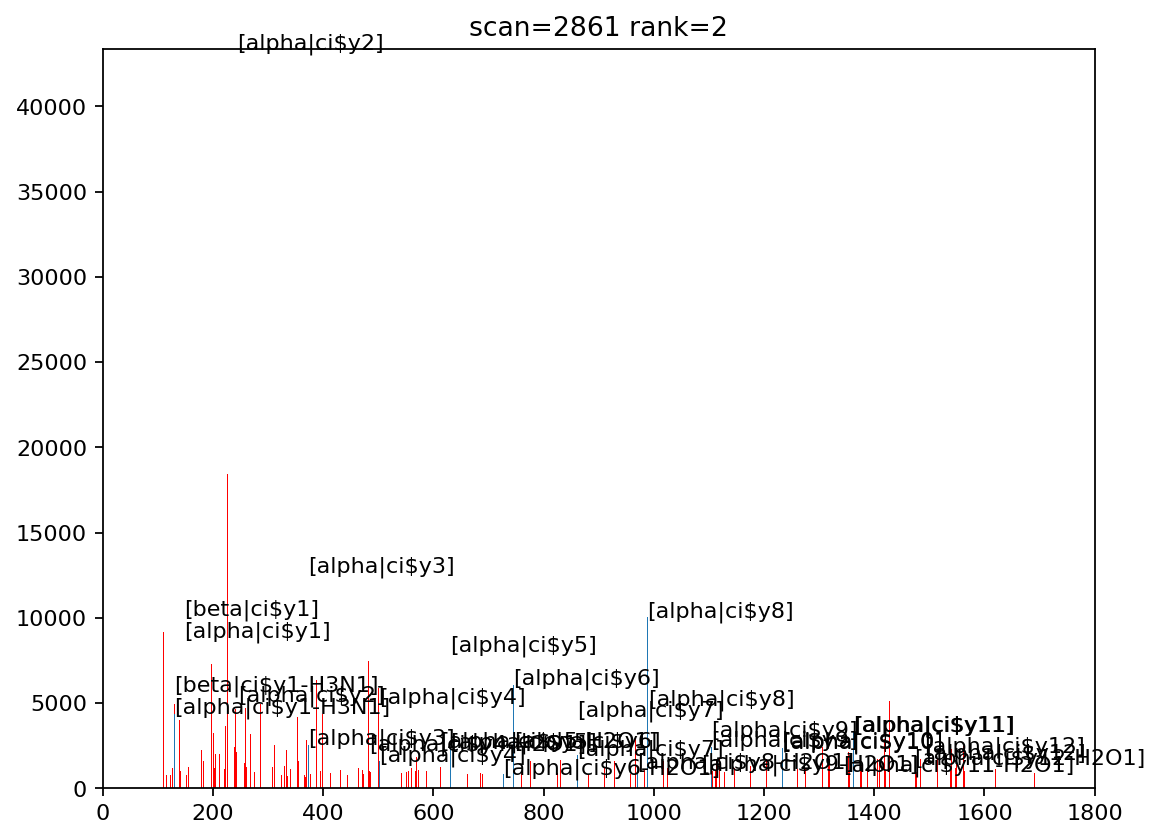

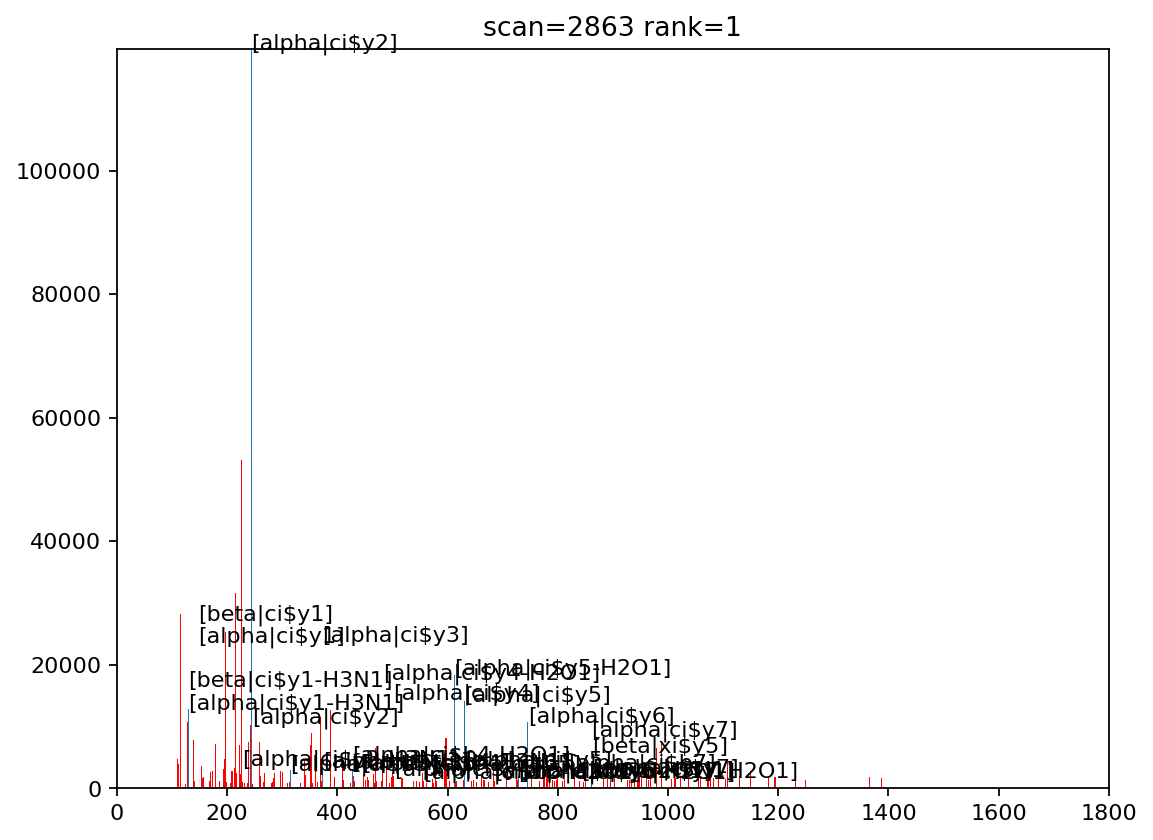

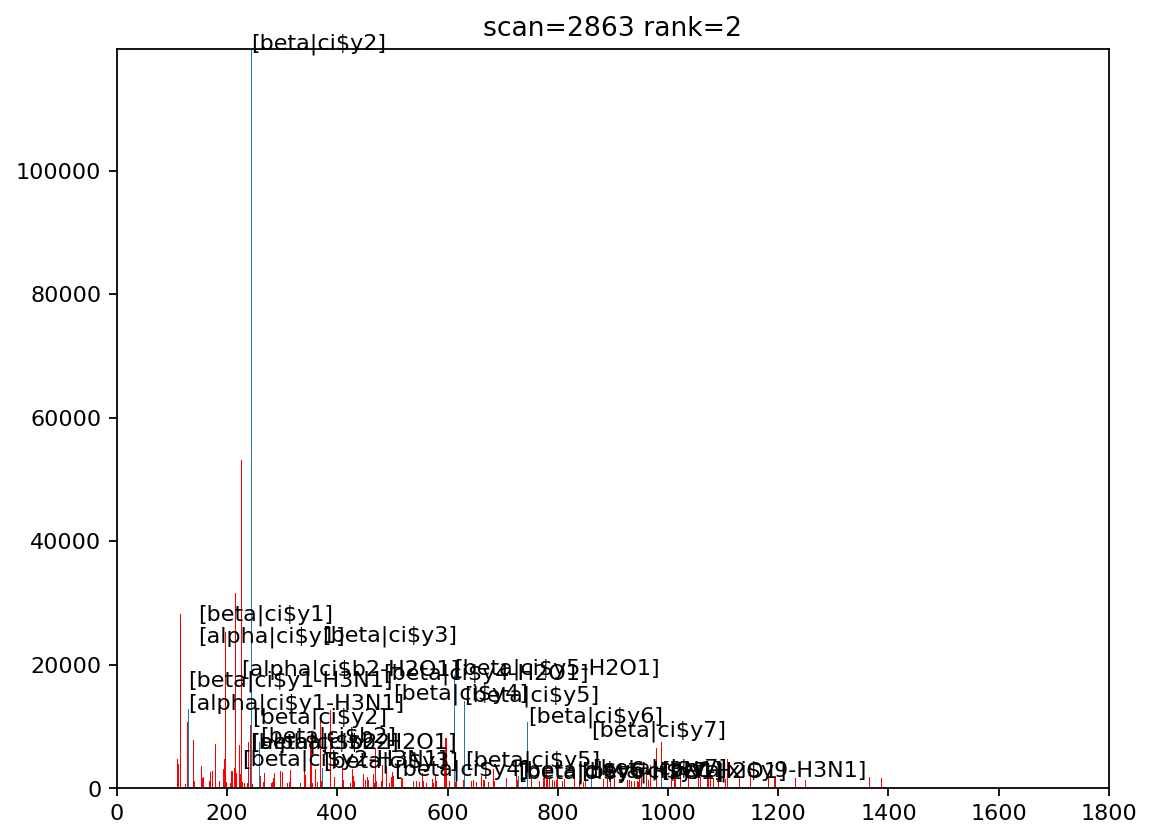

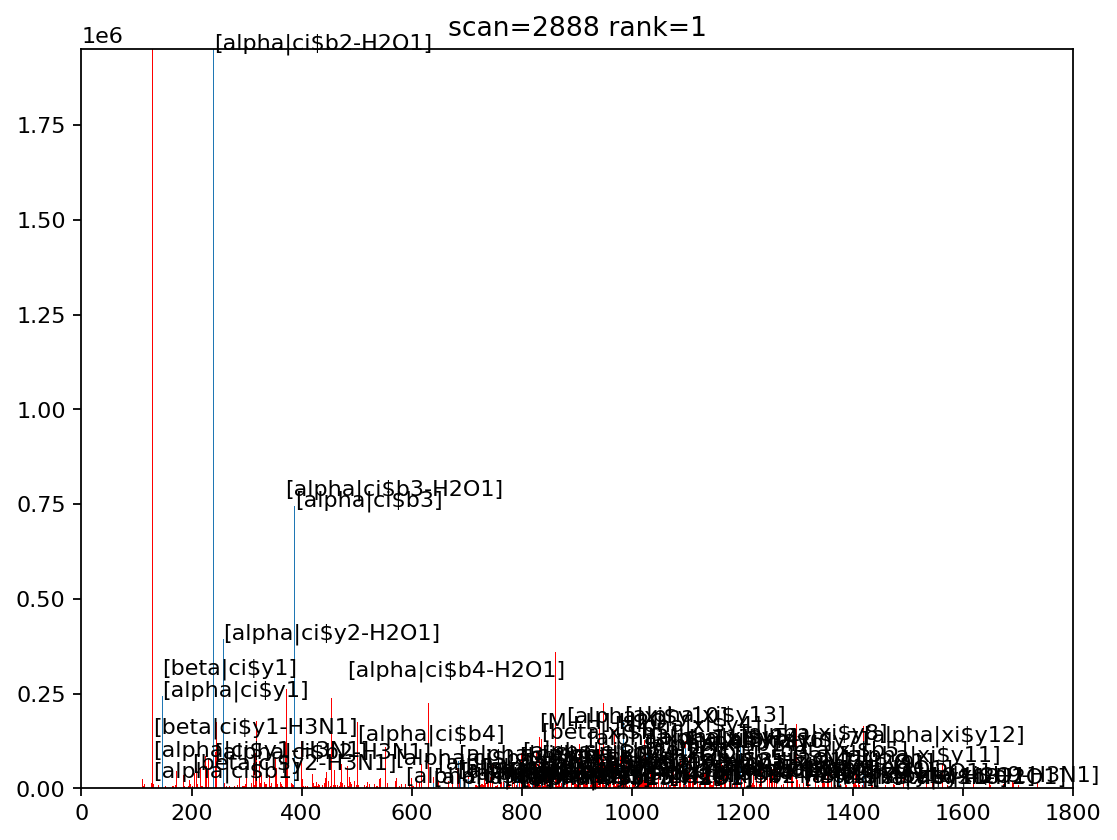

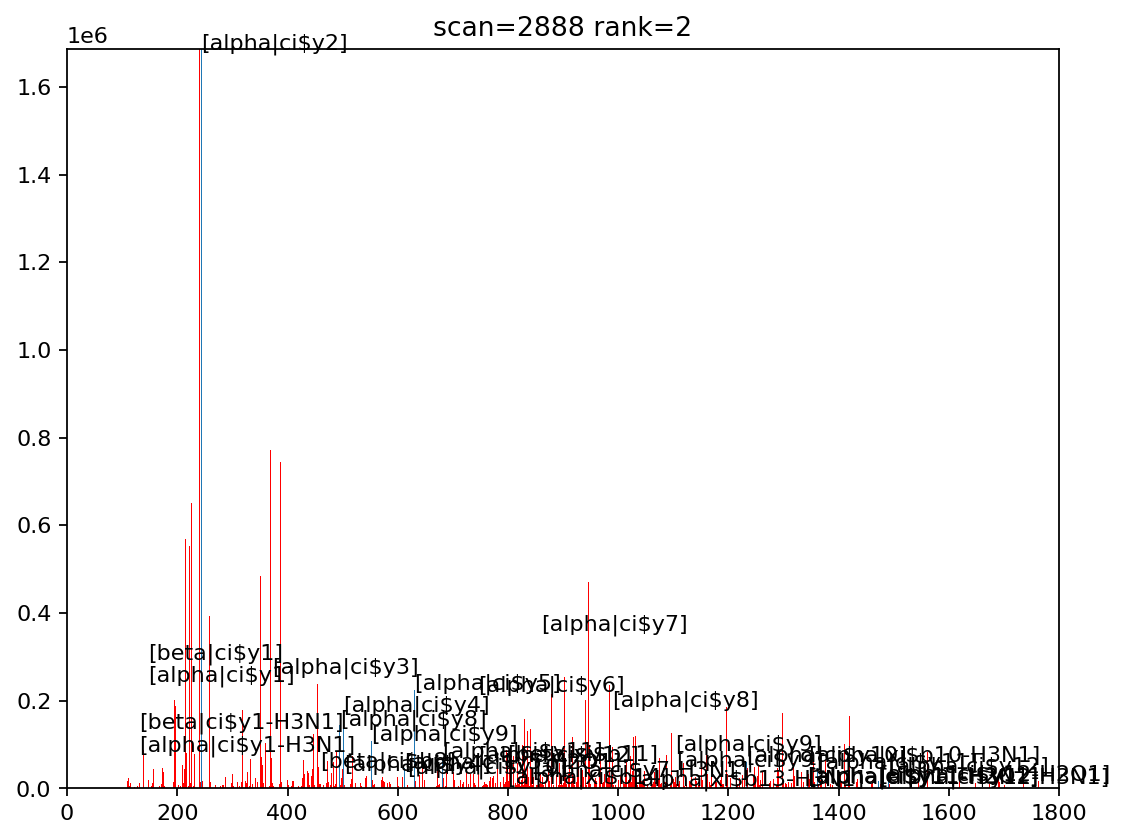

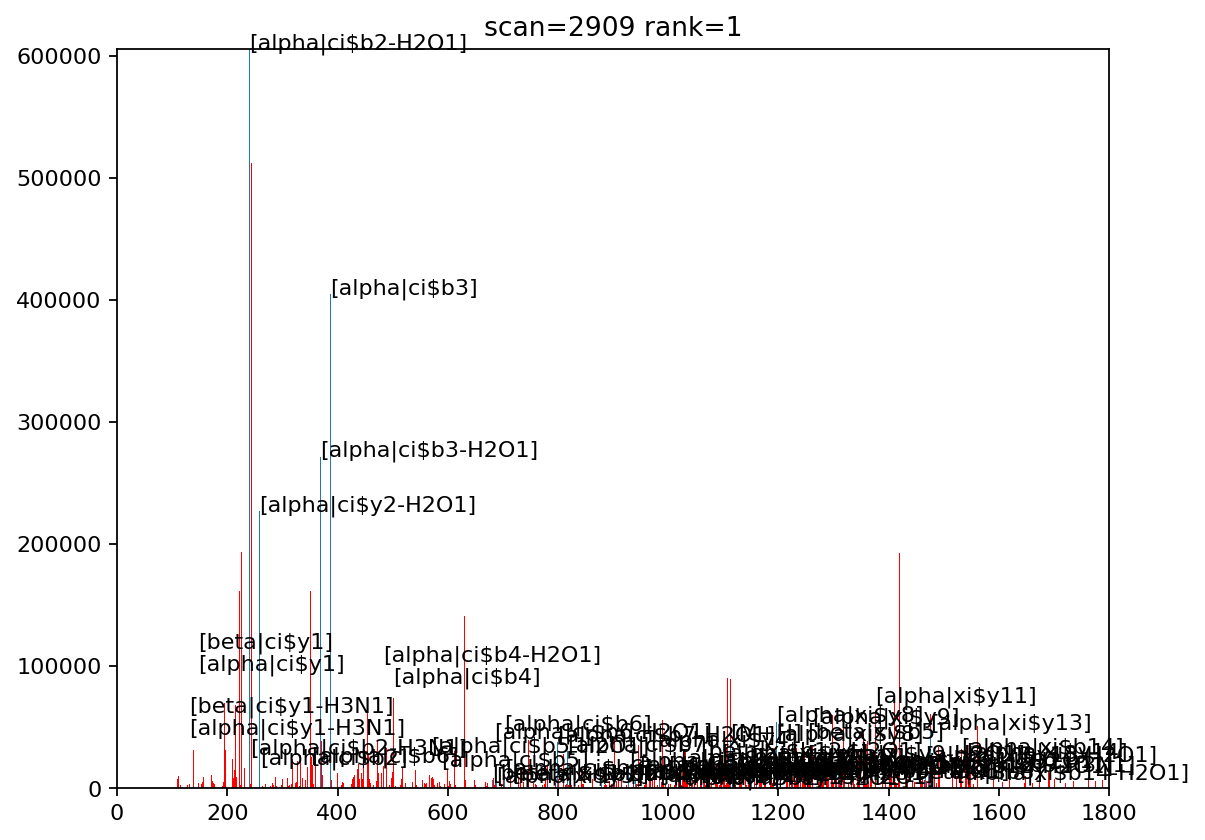

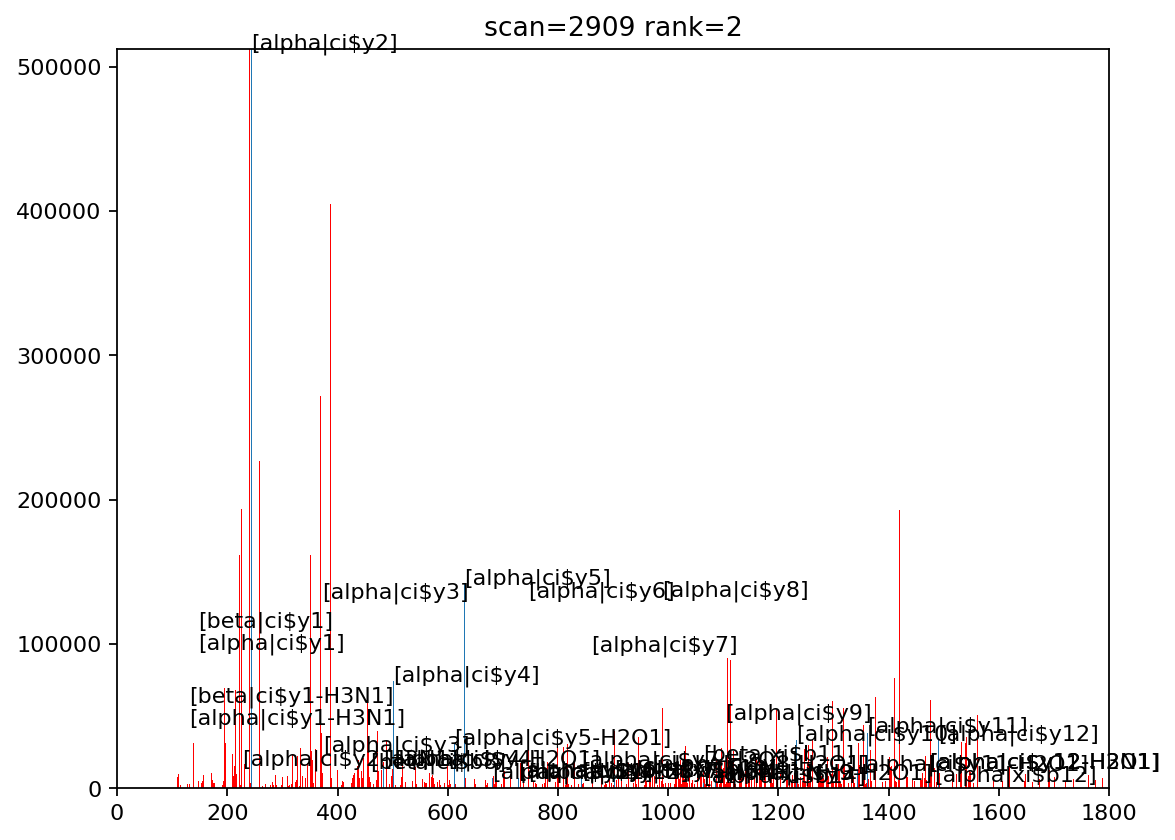

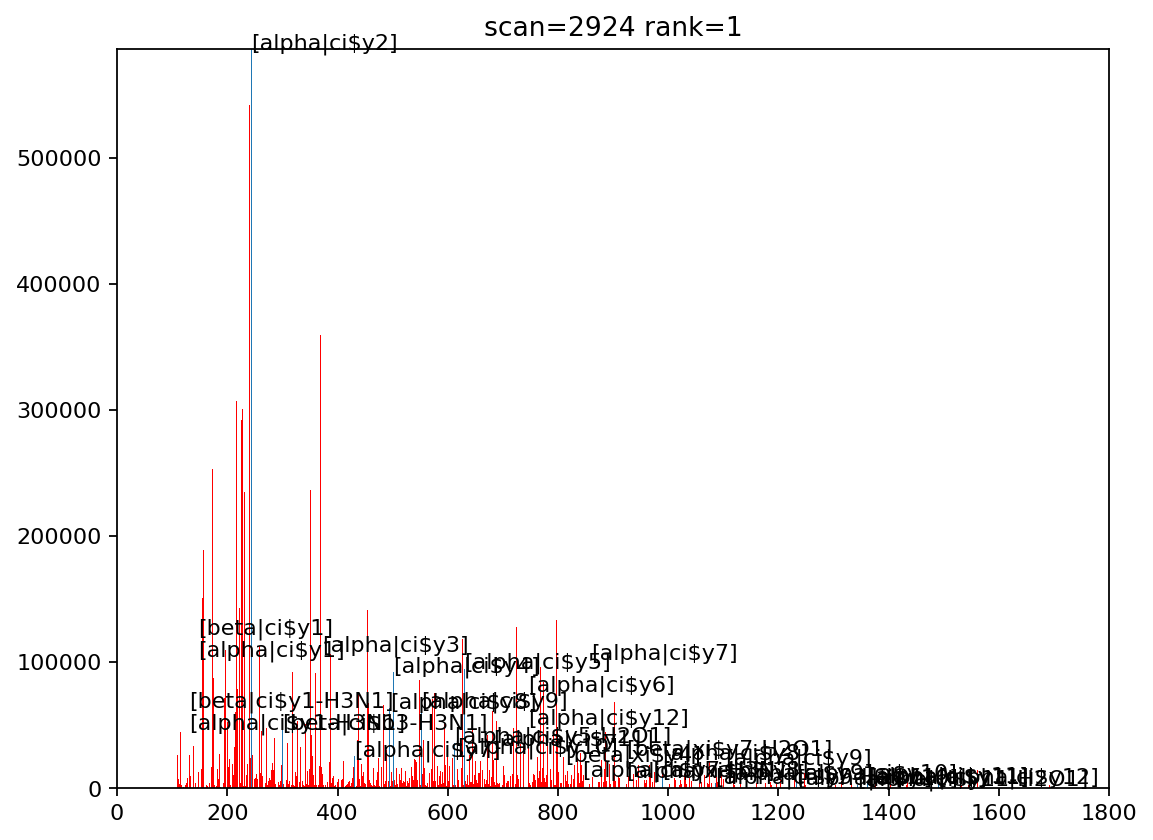

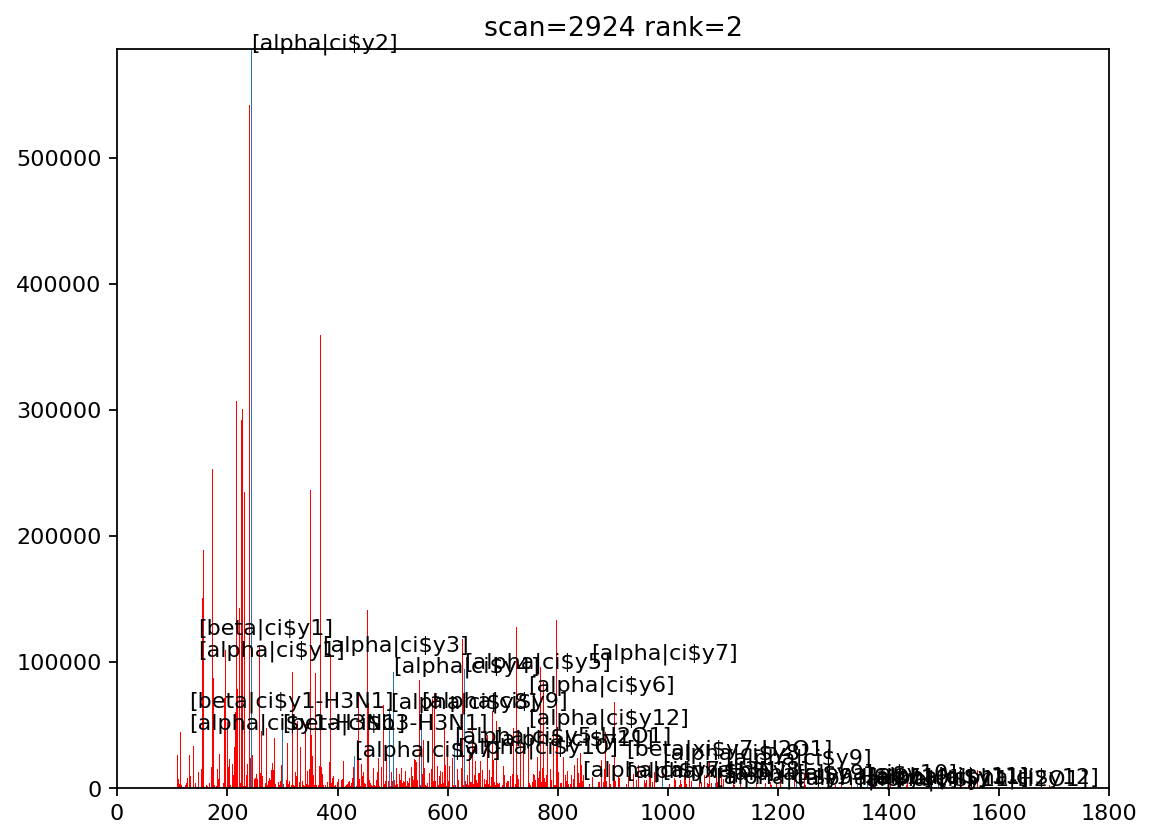

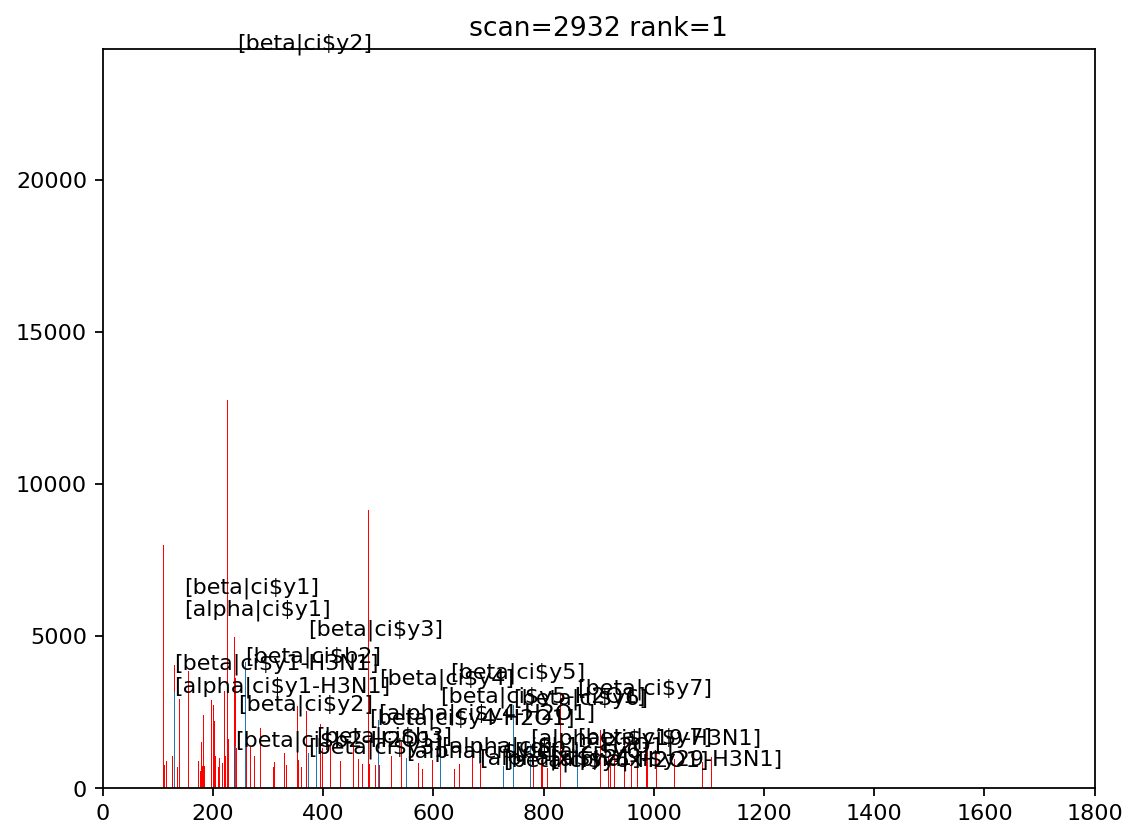

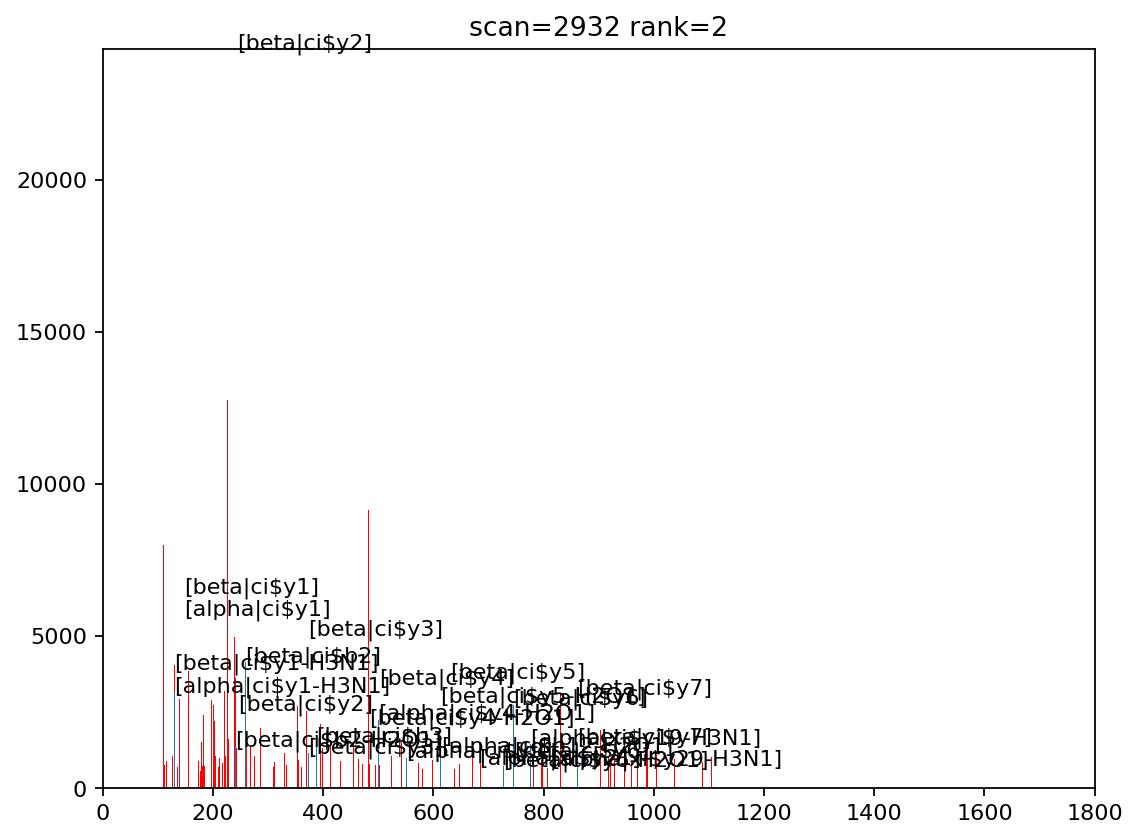

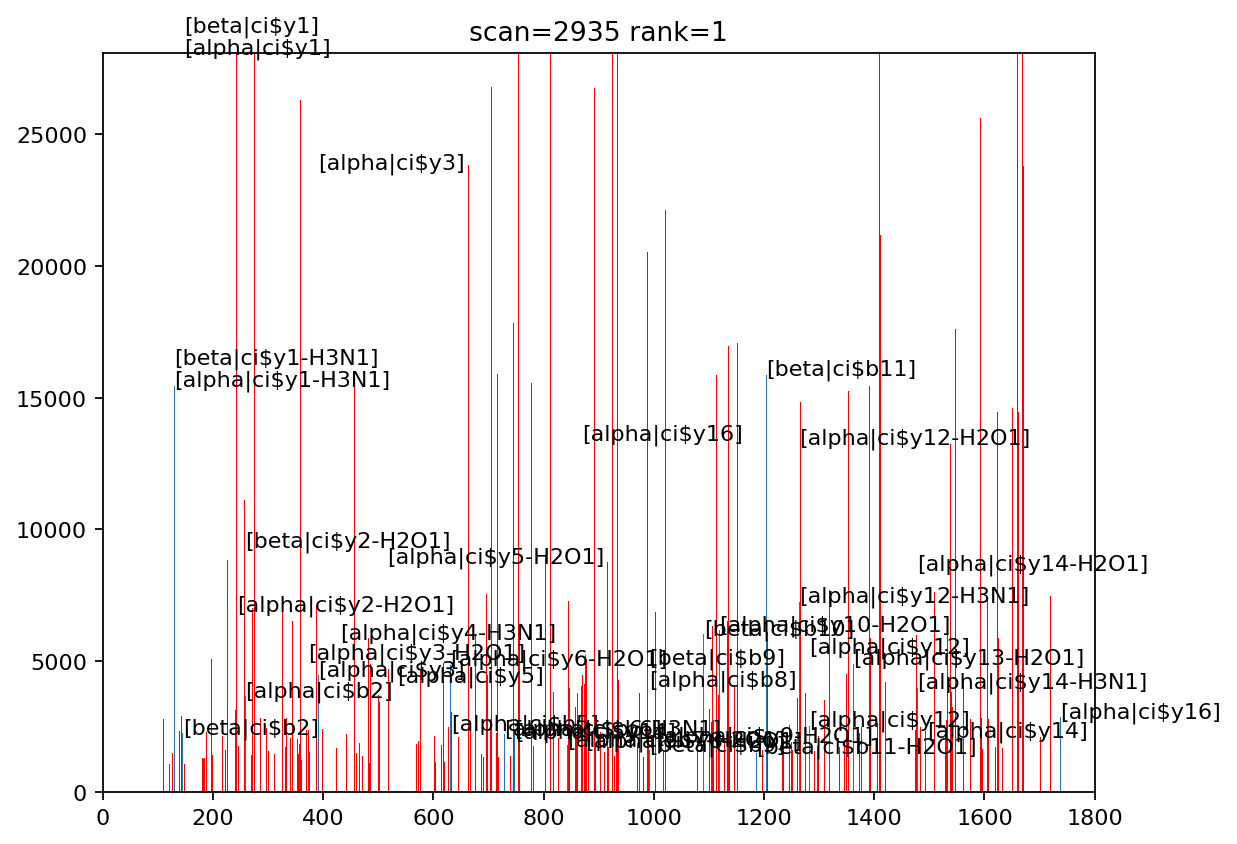

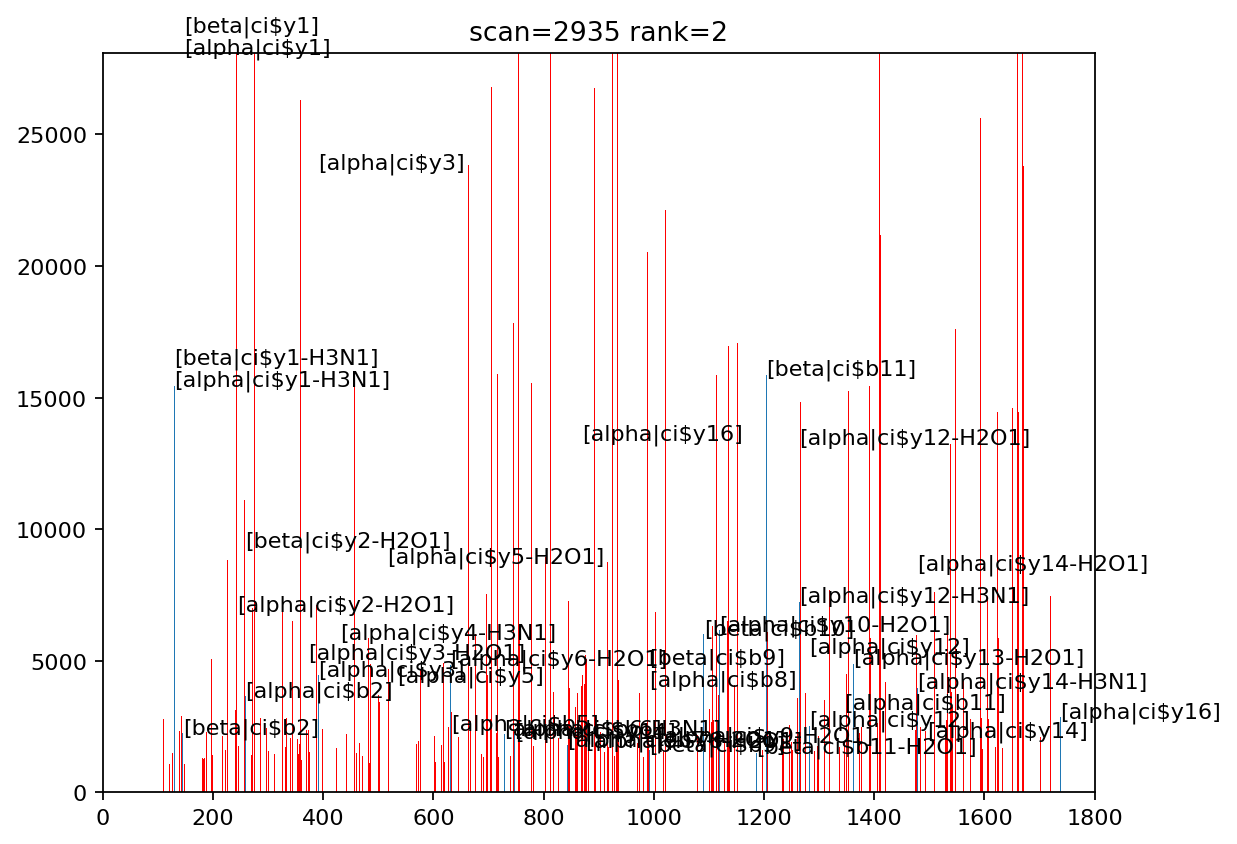

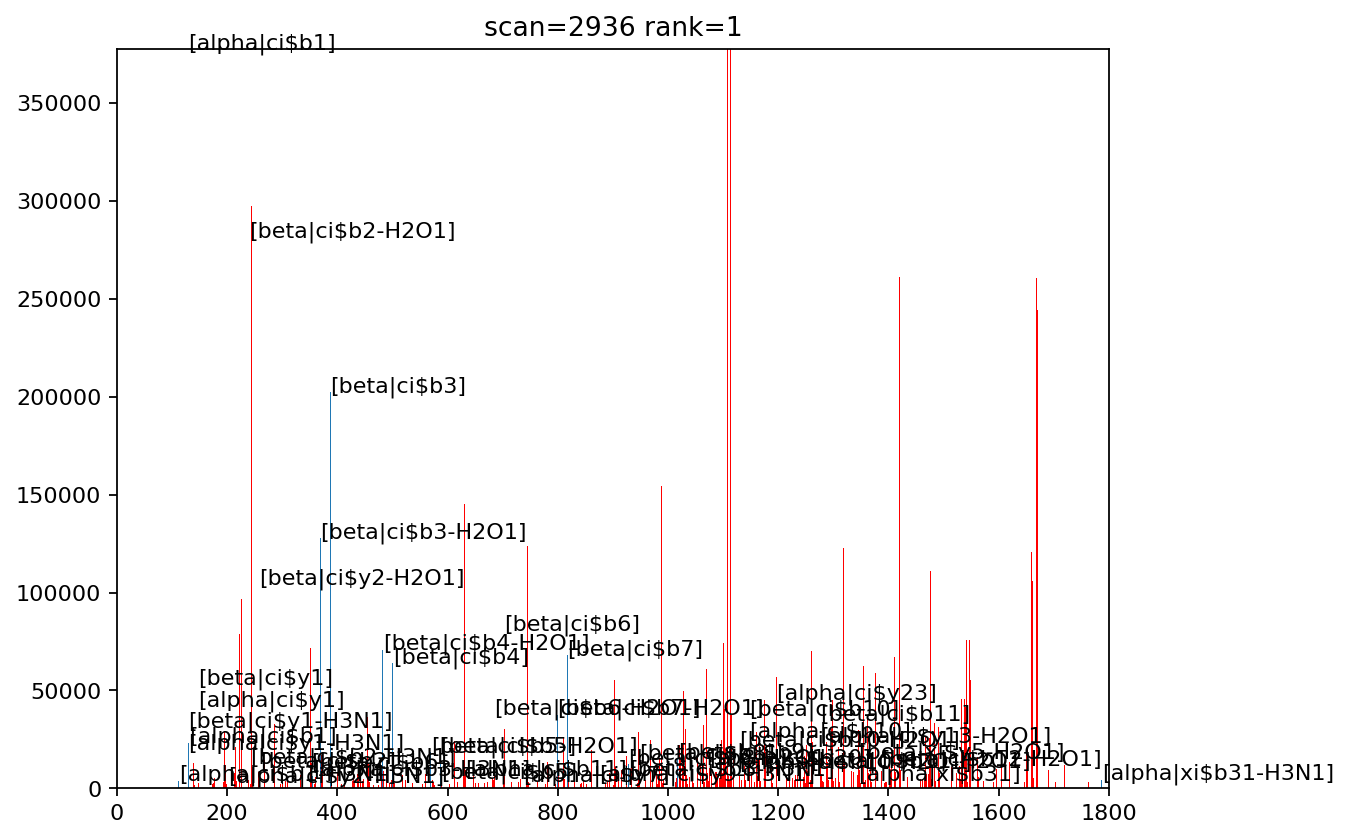

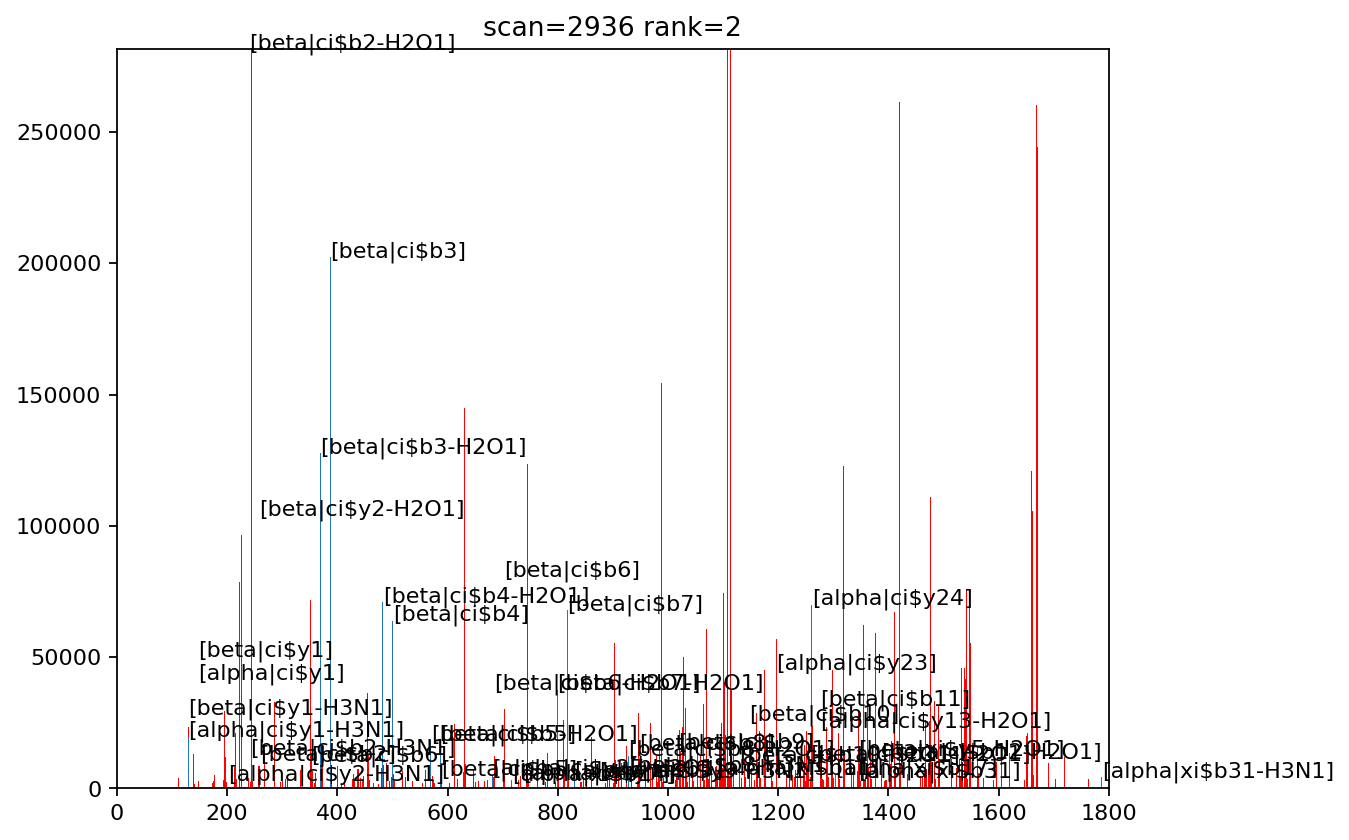

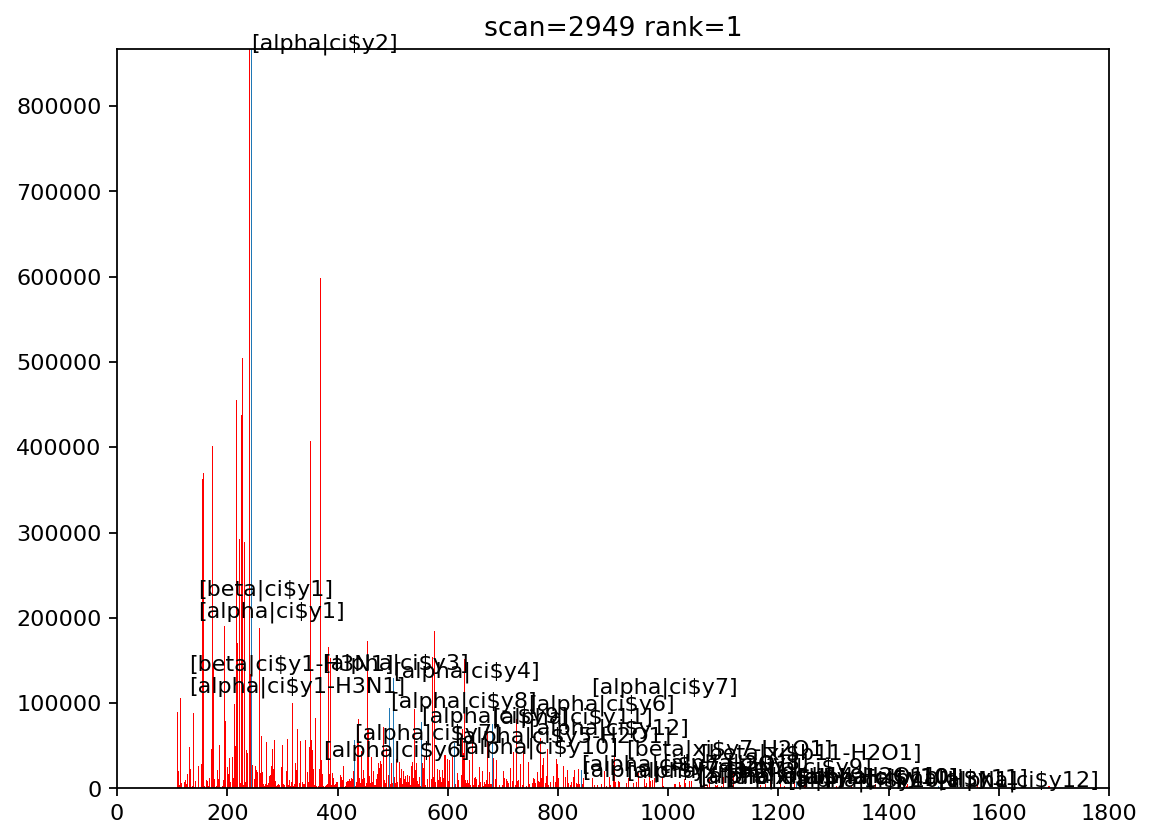

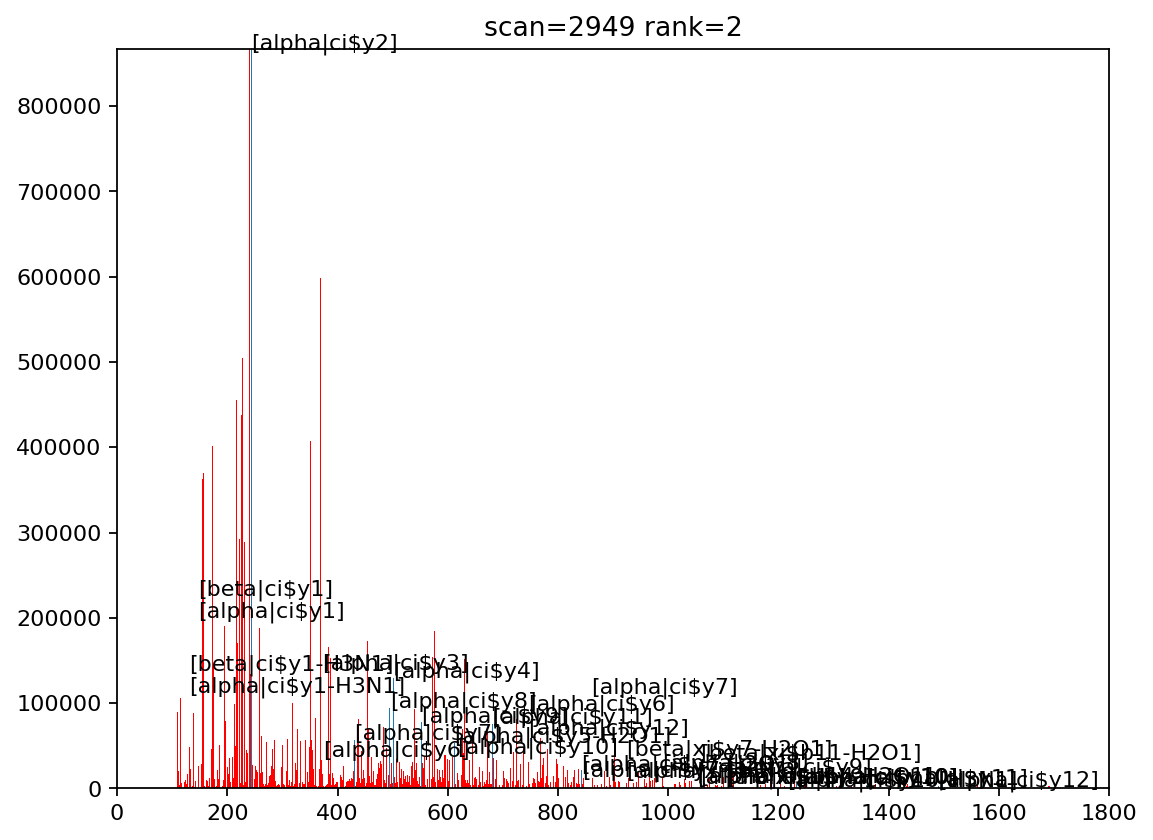

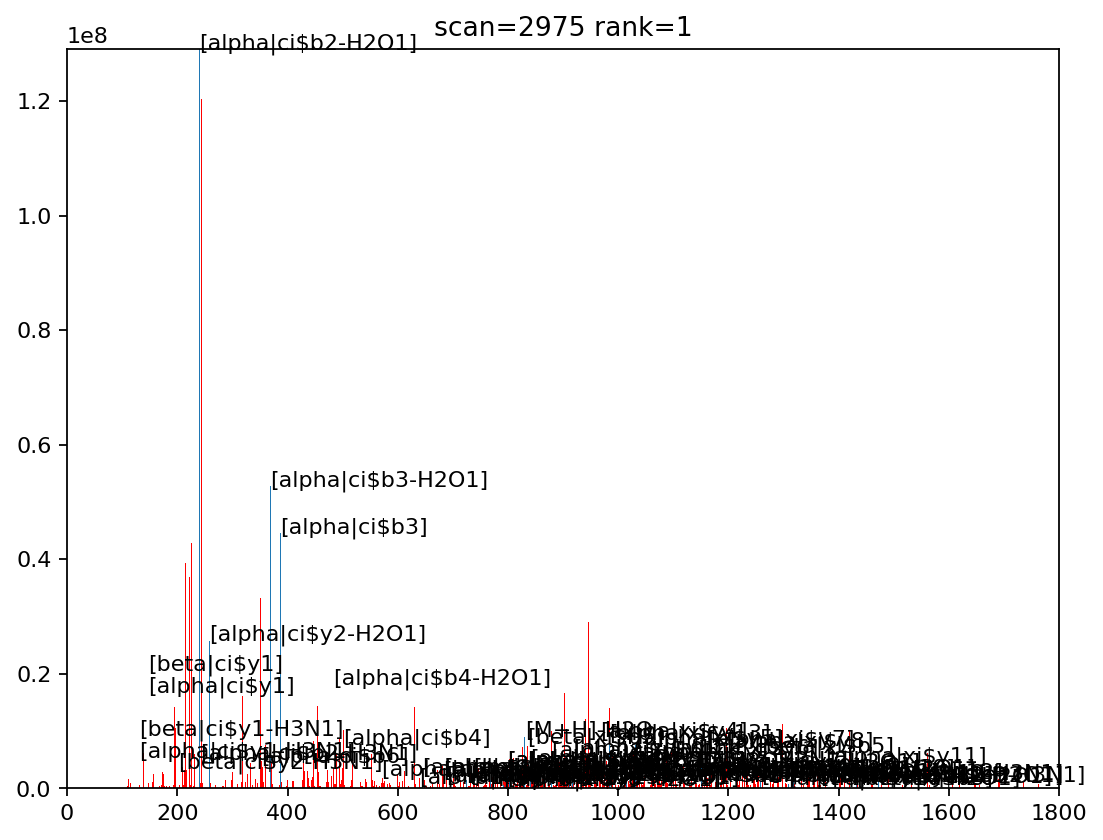

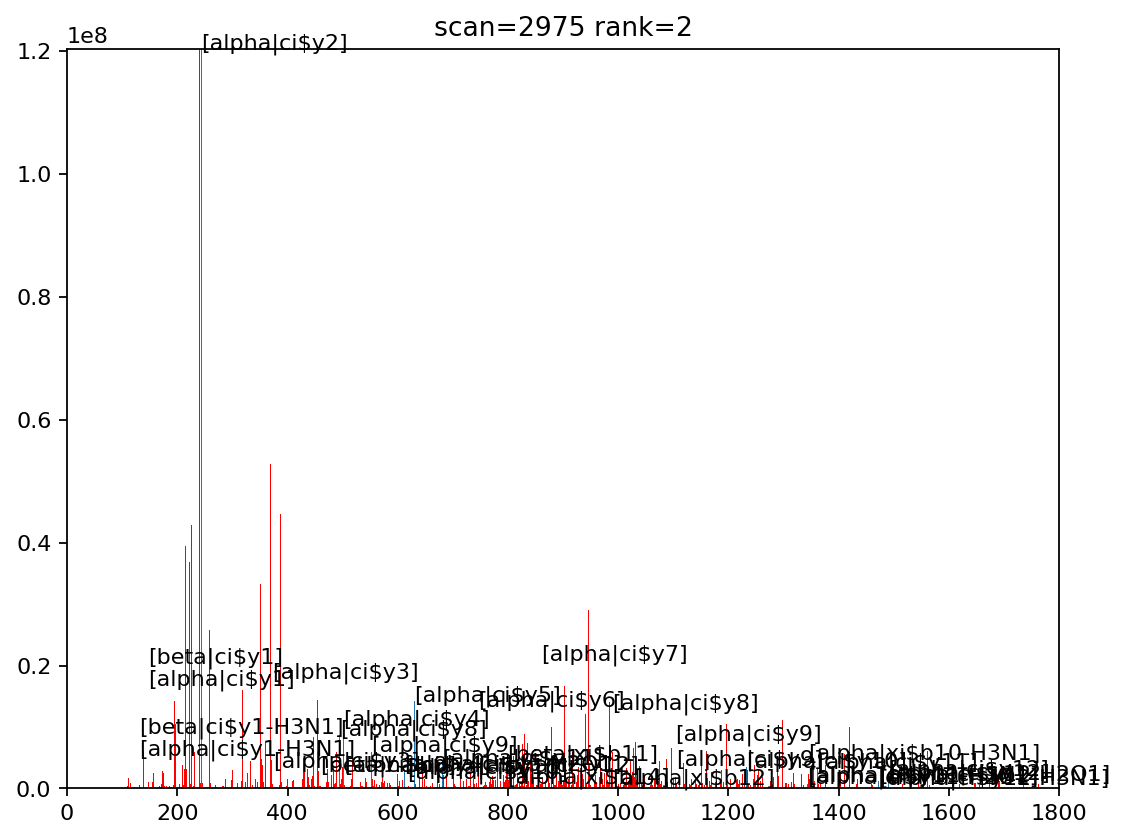

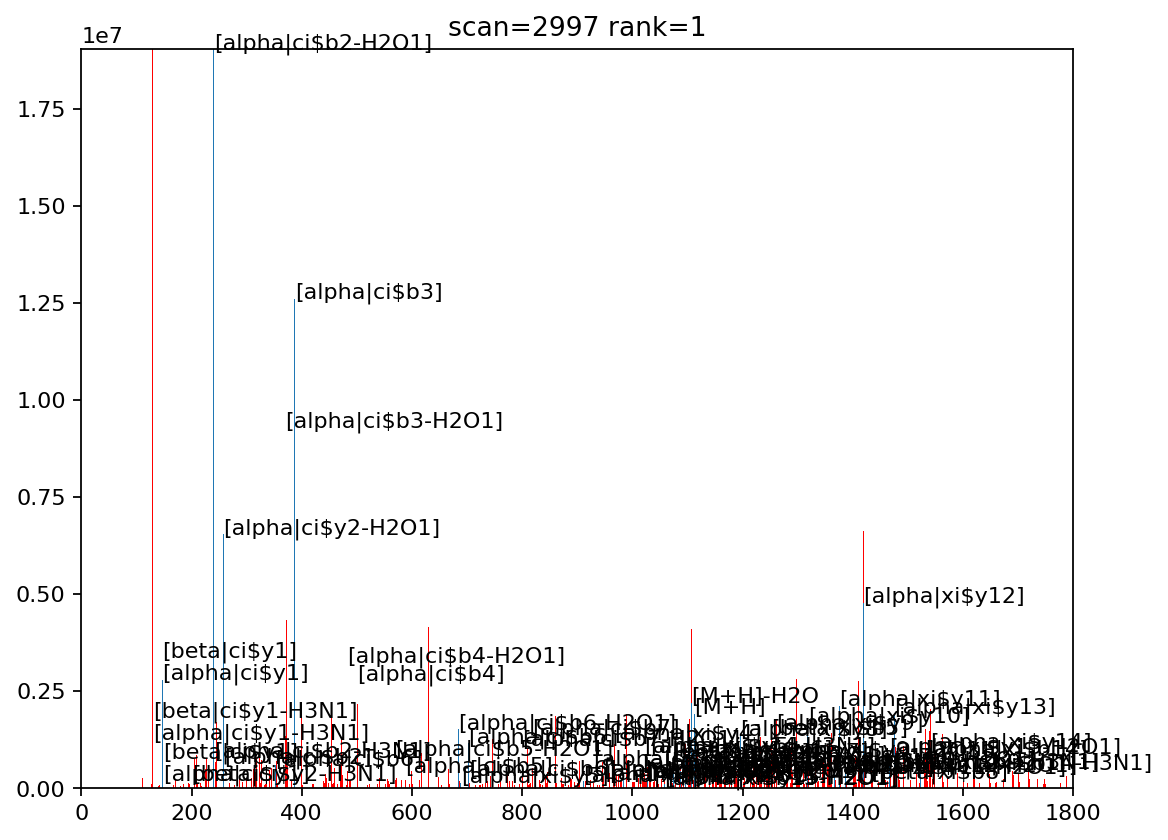

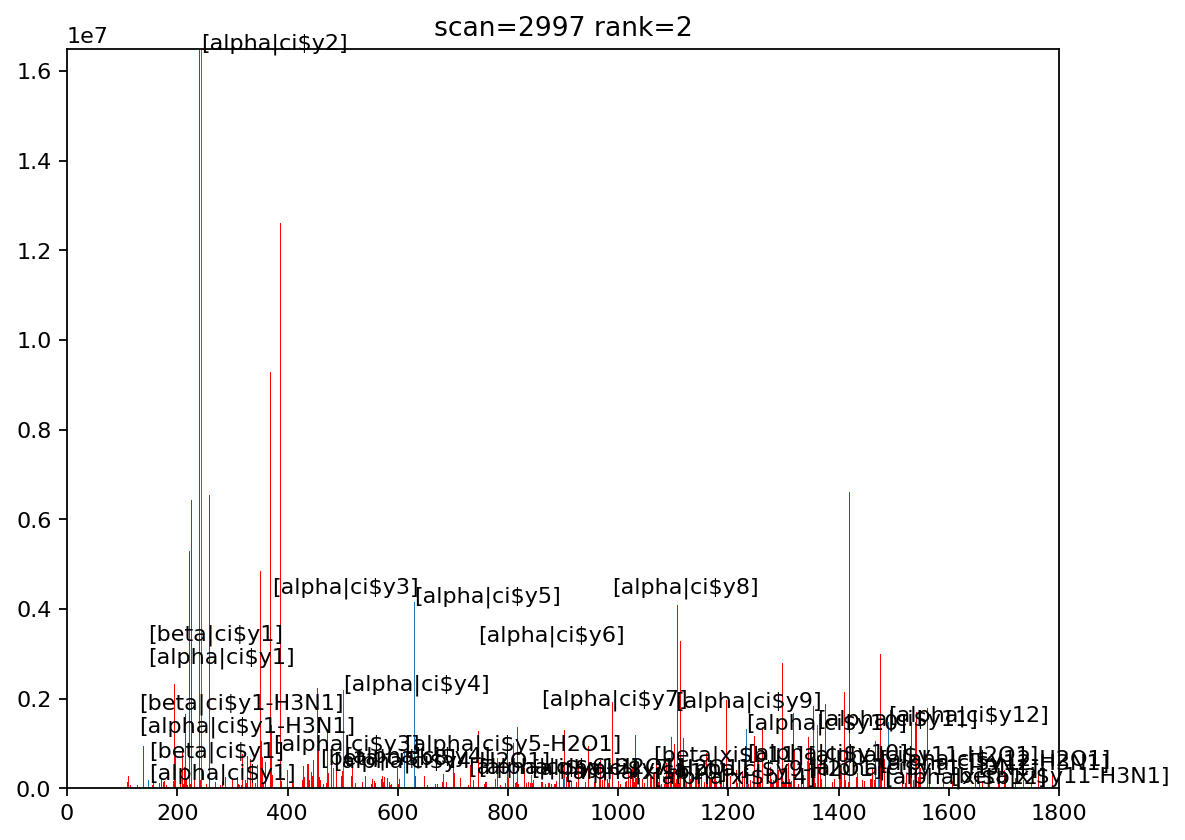

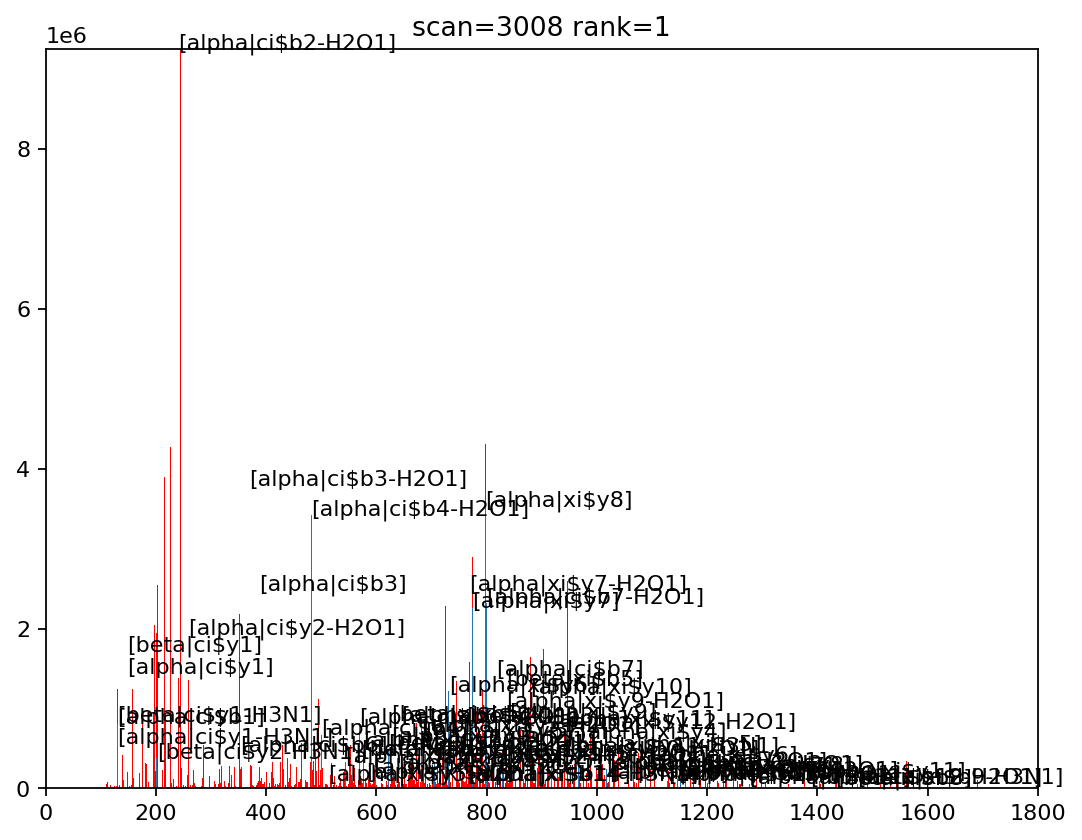

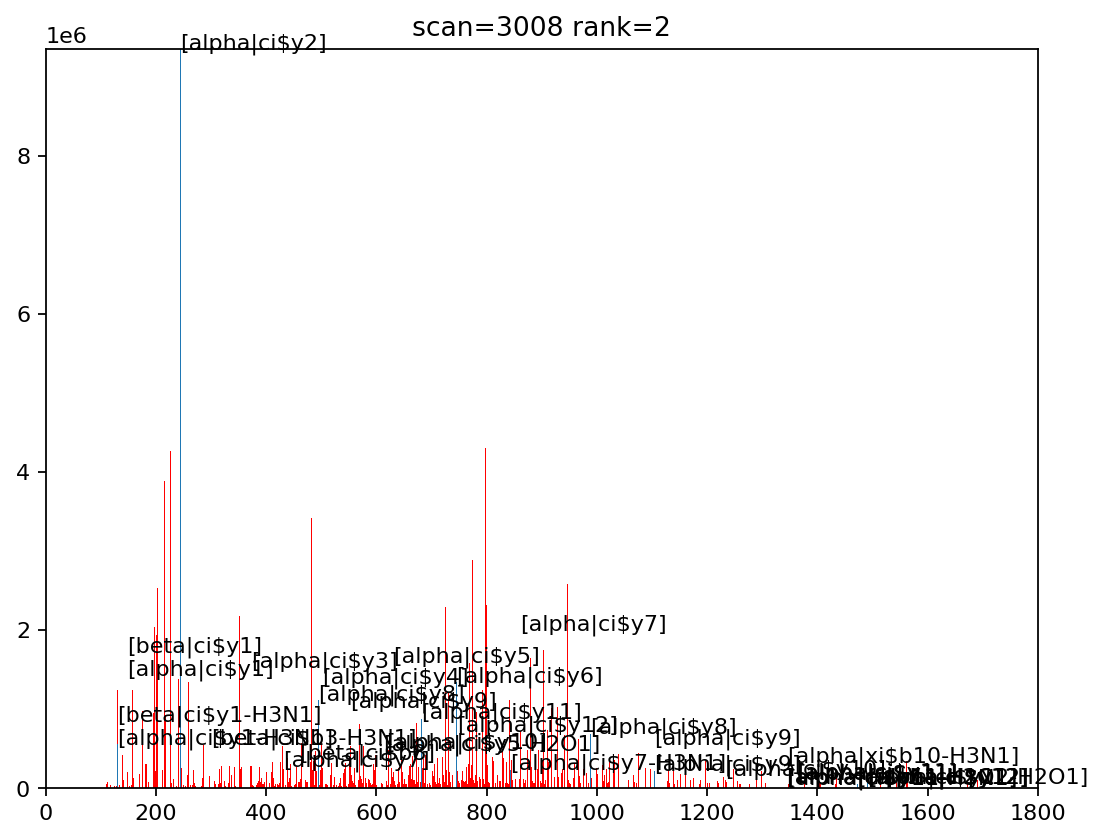

In [71]:
i = 0
for spec_ref in pepid_high_s2.keys():
    plot_annotated_top2_matches(spec_ref, pepid_high_s2, mzml)
    i += 1
    if i >= 20:
        break

In [261]:

xlms_id = XLMS_id(pepid_high_s2[spec_ref][1])
xlms_id.plot(spec, ax)

             0             1                   2
0   130.050095   4265.267578        [beta|ci$b1]
1   130.086517  97807.601562  [alpha|ci$y1-H3N1]
2   130.086517  97807.601562   [beta|ci$y1-H3N1]
3   147.113159  85678.523438       [alpha|ci$y1]
4   147.113159  85678.523438        [beta|ci$y1]
5   148.116745   5871.193359       [alpha|ci$y1]
6   148.116745   5871.193359        [beta|ci$y1]
7   290.118347   5003.562012   [beta|ci$y2-H3N1]
8   307.144623  32367.666016        [beta|ci$y2]
9   448.244904  60104.292969           [M+H]-NH3
10  452.498657   6232.931152               [M+H]
11  495.280457  13086.640625   [beta|xi$b3-H3N1]
12  501.281708  95832.945312        [beta|xi$b3]
13  548.622498  20491.769531  [alpha|xi$b7-H3N1]
14  548.622498  20491.769531   [beta|xi$b4-H3N1]
15  554.296997  31162.712891       [alpha|xi$b7]
16  554.296997  31162.712891        [beta|xi$b4]
17  742.414673  11273.465820   [beta|xi$b3-H3N1]
18  751.417358  34799.320312        [beta|xi$b3]


In [244]:
spec.xml.findall(f'run/spectrumList/spectrum', nsmap)

AttributeError: 'Spectrum' object has no attribute 'xml'

In [ ]:
def 

In [7]:
res = XLMS_res('../results/openpepxllf/alban/20210702_L1_UM5_alban001_SA_EXT00_Ilse_fbn_dss2_450mm.idXML')
res.xml

In [11]:
new_res = XLMS_res.from_old(res)
new_res

In [31]:
root = res.xml
x = root.find('IdentificationRun/PeptideIdentification')

In [127]:
x.find('PeptideHit[1]')

<Element 'PeptideHit' at 0x000001F27FBEA3E0>

In [125]:
x.findall('PeptideHit')

[<Element 'PeptideHit' at 0x000001F27FBEA3E0>,
 <Element 'PeptideHit' at 0x000001F27FBECAE0>]

In [36]:
x.attrib

{'score_type': 'OpenPepXL:score',
 'higher_score_better': 'true',
 'significance_threshold': '0.0',
 'MZ': '655.048889160156023',
 'RT': '756.125406943002076',
 'spectrum_reference': 'controllerType=0 controllerNumber=1 scan=2831'}

## Plot with df

In [ ]:
def plot_df_res(df):
    

## ALott

In [15]:
xlms_res = XLMS_res('../results/openpepxllf/knime4.6/ALott/M_Ninov_ALott_Expl_260620_020720_pSEC_R1_Fr22.idXML')
xlms_res

In [49]:
import xlms
from extract_search_result import load_res
from load_search_result import load_idxmls
import csv

In [50]:
def load_res(name, basedir=''):
    res_csv = f'{basedir}results/info/{name}_res.csv'
    res_csv = csv.DictReader(open(res_csv))
    # data_tab = pd.read_csv(res_csv, index_col=0)
    data_tab = pd.DataFrame(res_csv)
    data_tab = data_tab.set_index('')
    data_tab['xl_rank'] = data_tab['xl_rank'].astype(int)
    data_tab['OpenPepXL:score'] = data_tab['OpenPepXL:score'].astype(float)
    return data_tab


In [51]:
df = load_res('ALott', '../')

In [52]:
df

score_type higher_score_better significance_threshold  \
                                                                      
0        OpenPepXL:score                True                    0.0   
1        OpenPepXL:score                True                    0.0   
2        OpenPepXL:score                True                    0.0   
3        OpenPepXL:score                True                    0.0   
4        OpenPepXL:score                True                    0.0   
...                  ...                 ...                    ...   
2726486  OpenPepXL:score                True                    0.0   
2726487  OpenPepXL:score                True                    0.0   
2726488  OpenPepXL:score                True                    0.0   
2726489  OpenPepXL:score                True                    0.0   
2726490  OpenPepXL:score                True                    0.0   

                       MZ                  RT  \
                                                
0                644.3593     2504.3519223423   
1        620.383361816406    2505.91807038498   
2        620.383361816406    2505.91807038498   
3        620.383361816406    2505.91807038498   
4        620.383361816406    2505.91807038498   
...                   ...                 ...   
2726486  792.736022949219  1794.0042482109059   
2726487          655.6445   1794.469098398208   
2726488          655.6445   1794.469098398208   
2726489          655.6445   1794.469098398208   
2726490          655.6445   1794.469098398208   

                                        spectrum_reference    xl_chain  \
                                                                         
0        file=M_Ninov_ALott_Expl_260620_020720_pSEC_R1_...  MS:1002510   
1        file=M_Ninov_ALott_Expl_260620_020720_pSEC_R1_...  MS:1002510   
2        file=M_Ninov_ALott_Expl_260620_020720_pSEC_R1_...  MS:1002510   
3        file=M_Ninov_ALott_Expl_260620_020720_pSEC_R1_...  MS:1002510   
4        file=M_Ninov_ALott_Expl_260620_020720_pSEC_R1_...  MS:1002510   
...                                                    ...         ...   
2726486  file=M_Ninov_ALott_Expl_260620_020720_pSEC_R1_...  MS:1002510   
2726487  file=M_Ninov_ALott_Expl_260620_020720_pSEC_R1_...  MS:1002510   
2726488  file=M_Ninov_ALott_Expl_260620_020720_pSEC_R1_...  MS:1002509   
2726489  file=M_Ninov_ALott_Expl_260620_020720_pSEC_R1_...  MS:1002509   
2726490  file=M_Ninov_ALott_Expl_260620_020720_pSEC_R1_...  MS:1002509   

        xl_pos1 spectrum_index     xl_type  ...  xl_pos1_protein  \
                                            ...                    
0             4           5454  cross-link  ...              375   
1             2           5458  cross-link  ...              591   
2             2           5458  cross-link  ...              591   
3             7           5458  cross-link  ...              596   
4             2           5458  cross-link  ...              591   
...         ...            ...         ...  ...              ...   
2726486       7           8148  cross-link  ...              588   
2726487       2           8150  cross-link  ...              260   
2726488       7           8150   mono-link  ...              265   
2726489      12           8150   mono-link  ...              270   
2726490       2           8150   mono-link  ...              260   

        xl_pos2_protein        accessions_beta xl_target_decoy_alpha  \
                                                                       
0                   211  sp|P0DMV9|HS71B_HUMAN                target   
1                   433  sp|P08238|HS90B_HUMAN                target   
2                   433  sp|P08238|HS90B_HUMAN                target   
3                   433  sp|P08238|HS90B_HUMAN                target   
4                   590  sp|P0DMV9|HS71B_HUMAN                target   
...                 ...                    ...                   ...   
2726486             580  sp|

In [64]:
df = load_idxmls(f'ALott/*.idXML', '../results/openpepxllf/knime4.6/')

../results/openpepxllf/knime4.6/ALott/M_Ninov_ALott_Expl_260620_020720_pSEC_R1_Fr22.idXML


In [68]:
df

score_type higher_score_better significance_threshold  \
58018  OpenPepXL:score                true                    0.0   
58019  OpenPepXL:score                true                    0.0   
58020  OpenPepXL:score                true                    0.0   
58021  OpenPepXL:score                true                    0.0   
58022  OpenPepXL:score                true                    0.0   
...                ...                 ...                    ...   
58013  OpenPepXL:score                true                    0.0   
58014  OpenPepXL:score                true                    0.0   
58015  OpenPepXL:score                true                    0.0   
58016  OpenPepXL:score                true                    0.0   
58017  OpenPepXL:score                true                    0.0   

                         MZ                    RT  \
58018   802.401306152343977  2614.178996393201942   
58019   802.401306152343977  2614.178996393201942   
58020   802.401306152343977  2614.178996393201942   
58021   802.401306152343977  2614.178996393201942   
58022   802.401306152343977  2614.178996393201942   
...                     ...                   ...   
58013  1165.608199999999897  2613.916369268417839   
58014  1165.608199999999897  2613.916369268417839   
58015  1165.608199999999897  2613.916369268417839   
58016  1165.608199999999897  2613.916369268417839   
58017  1165.608199999999897  2613.916369268417839   

                                      spectrum_reference    xl_chain  xl_pos1  \
58018  file=M_Ninov_ALott_Expl_260620_020720_pSEC_R1_...  MS:1002509       25   
58019  file=M_Ninov_ALott_Expl_260620_020720_pSEC_R1_...  MS:1002509        5   
58020  file=M_Ninov_ALott_Expl_260620_020720_pSEC_R1_...  MS:1002509        3   
58021  file=M_Ninov_ALott_Expl_260620_020720_pSEC_R1_...  MS:1002509       21   
58022  file=M_Ninov_ALott_Expl_260620_020720_pSEC_R1_...  MS:1002509       29   
...                                                  ...         ...      ...   
58013  file=M_Ninov_ALott_Expl_260620_020720_pSEC_R1_...  MS:1002509        7   
58014  file=M_Ninov_ALott_Expl_260620_020720_pSEC_R1_...  MS:1002509       22   
58015  file=M_Ninov_ALott_Expl_260620_020720_pSEC_R1_...  MS:1002509       16   
58016  file=M_Ninov_ALott_Expl_260620_020720_pSEC_R1_...  MS:1002509       16   
58017  file=M_Ninov_ALott_Expl_260620_020720_pSEC_R1_...  MS:1002509       19   

       spectrum_index     xl_type  ...  selected  \
58018            7627  cross-link  ...     false   
58019            7627  cross-link  ...     false   
58020            7627  cross-link  ...     false   
58021            7627  cross-link  ...     false   
58022            7627  cross-link  ...     false   
...               ...         ...  ...       ...   
58013            7626  cross-link  ...     false   
58014            7626  cross-link  ...     false   
58015            7626  cross-link  ...     false   
58016            7626  cross-link  ...     false   
58017            7626  cross-link  ...     false   

                         sequence_beta target_decoy  protein_references  \
58018                 LIGRKFGDPVVQSDMK       target              unique   
58019                 LIGRKFGDPVVQSDMK       target              unique   
58020                 LIGRKFGDPVVQSDMK       target              unique   
58021  DAKLYSNRAAC(Carbamidomethyl)YTK       target              unique   
58022                            EKGNK       target              unique   
...                                ...          ...                 ...   
58013           ILKEQERLAYINPDLALEEKNK       target              unique   
58014   KGDYQKAYEDGC(Carbamidomethyl)K       target              unique   
58015         SIYYITGESKEQVANSAFVERVRK       target              unique   
58016           ILKEQERLAYINPDLALEEKNK       target              unique   
58017                  QALKEKELGNDAYKK       target              unique   

      xl_pos1_protein xl_pos2_protein        ac

In [65]:
g = df.groupby('spectrum_reference')

In [66]:
g.apply(remove_dup_pep)

score_type  \
spectrum_reference                                                          
file=M_Ninov_ALott_Expl_260620_020720_pSEC_R1_F... 58018  OpenPepXL:score   
                                                   58021  OpenPepXL:score   
                                                   58022  OpenPepXL:score   
                                                   58023  OpenPepXL:score   
                                                   58025  OpenPepXL:score   
...                                                                   ...   
file=M_Ninov_ALott_Expl_260620_020720_pSEC_R1_F... 58011  OpenPepXL:score   
                                                   58012  OpenPepXL:score   
                                                   58013  OpenPepXL:score   
                                                   58015  OpenPepXL:score   
                                                   58017  OpenPepXL:score   

                                                         higher_score_better  \
spectrum_reference                                                             
file=M_Ninov_ALott_Expl_260620_020720_pSEC_R1_F... 58018                true   
                                                   58021                true   
                                                   58022                true   
                                                   58023                true   
                                                   58025                true   
...                                                                      ...   
file=M_Ninov_ALott_Expl_260620_020720_pSEC_R1_F... 58011                true   
                                                   58012                true   
                                                   58013                true   
                                                   58015                true   
                                                   58017                true   

                                                         significance_threshold  \
spectrum_reference                                                                
file=M_Ninov_ALott_Expl_260620_020720_pSEC_R1_F... 58018                    0.0   
                                                   58021                    0.0   
                                                   58022                    0.0   
                                                   58023                    0.0   
                                                   58025                    0.0   
...                                                                         ...   
file=M_Ninov_ALott_Expl_260620_020720_pSEC_R1_F... 58011                    0.0   
                                                   58012                    0.0   
                                                   58013                    0.0   
                                                   58015                    0.0   
                                                   58017                    0.0   

                                                                            MZ  \
spectrum_reference                                                               
file=M_Ninov_ALott_Expl_260620_020720_pSEC_R1_F... 58018   802.401306152343977   
                                                   58021   802.401306152343977   
                                                   58022   802.401306152343977   
                                                   58023   802.401306152343977   
                                                   58025   802.401306152343977   
...                                                                        ...   
file=M_Ninov_ALott_Expl_260620_020720_pSEC_R1_F... 58011  1165.608199999999897   
                                                   58012  1165.608199999999897   
                                                   58013  1165.608199999999897   
                                      

In [74]:
nodup = g.apply(remove_dup_pep)
nodup.reset_index(drop = True, inplace = True)
nodup

score_type higher_score_better significance_threshold  \
0      OpenPepXL:score                true                    0.0   
1      OpenPepXL:score                true                    0.0   
2      OpenPepXL:score                true                    0.0   
3      OpenPepXL:score                true                    0.0   
4      OpenPepXL:score                true                    0.0   
...                ...                 ...                    ...   
43306  OpenPepXL:score                true                    0.0   
43307  OpenPepXL:score                true                    0.0   
43308  OpenPepXL:score                true                    0.0   
43309  OpenPepXL:score                true                    0.0   
43310  OpenPepXL:score                true                    0.0   

                         MZ                    RT  \
0       802.401306152343977  2614.178996393201942   
1       802.401306152343977  2614.178996393201942   
2       802.401306152343977  2614.178996393201942   
3       802.401306152343977  2614.178996393201942   
4       802.401306152343977  2614.178996393201942   
...                     ...                   ...   
43306  1165.608199999999897  2613.916369268417839   
43307  1165.608199999999897  2613.916369268417839   
43308  1165.608199999999897  2613.916369268417839   
43309  1165.608199999999897  2613.916369268417839   
43310  1165.608199999999897  2613.916369268417839   

                                      spectrum_reference    xl_chain  xl_pos1  \
0      file=M_Ninov_ALott_Expl_260620_020720_pSEC_R1_...  MS:1002509       25   
1      file=M_Ninov_ALott_Expl_260620_020720_pSEC_R1_...  MS:1002509       21   
2      file=M_Ninov_ALott_Expl_260620_020720_pSEC_R1_...  MS:1002509       29   
3      file=M_Ninov_ALott_Expl_260620_020720_pSEC_R1_...  MS:1002509       21   
4      file=M_Ninov_ALott_Expl_260620_020720_pSEC_R1_...  MS:1002509       15   
...                                                  ...         ...      ...   
43306  file=M_Ninov_ALott_Expl_260620_020720_pSEC_R1_...  MS:1002509       34   
43307  file=M_Ninov_ALott_Expl_260620_020720_pSEC_R1_...  MS:1002509       30   
43308  file=M_Ninov_ALott_Expl_260620_020720_pSEC_R1_...  MS:1002509        7   
43309  file=M_Ninov_ALott_Expl_260620_020720_pSEC_R1_...  MS:1002509       16   
43310  file=M_Ninov_ALott_Expl_260620_020720_pSEC_R1_...  MS:1002509       19   

       spectrum_index     xl_type  ...  selected  \
0                7627  cross-link  ...     false   
1                7627  cross-link  ...     false   
2                7627  cross-link  ...     false   
3                7627  cross-link  ...     false   
4                7627  cross-link  ...     false   
...               ...         ...  ...       ...   
43306            7626  cross-link  ...     false   
43307            7626  cross-link  ...     false   
43308            7626  cross-link  ...     false   
43309            7626  cross-link  ...     false   
43310            7626  cross-link  ...     false   

                                    sequence_beta target_decoy  \
0                                LIGRKFGDPVVQSDMK       target   
1                 DAKLYSNRAAC(Carbamidomethyl)YTK       target   
2                                           EKGNK       target   
3                SKLTFSC(Carbamidomethyl)LGGSDNFK       target   
4      KM(Oxidation)EESKAKFENLC(Carbamidomethyl)K       target   
...                                           ...          ...   
43306              KGDYQKAYEDGC(Carbamidomethyl)K       target   
43307        HLNEIDLFHC(Carbamidomethyl)IDPNDSKHK       target   
43308                      ILKEQERLAYINPDLALEEKNK       target   
43309                    SIYYITGESKEQVANSAFVERVRK       target   
43310                             QALKEKELGNDAYKK       target   

       protein_references xl_pos1_protein xl_pos2_protein  \
0                  unique             295              98   
1                  unique        

In [76]:
top2 = nodup.groupby('spectrum_reference').apply(lambda g: g.iloc[:2])
top2.reset_index(drop = True, inplace = True)
top2

score_type higher_score_better significance_threshold  \
0      OpenPepXL:score                true                    0.0   
1      OpenPepXL:score                true                    0.0   
2      OpenPepXL:score                true                    0.0   
3      OpenPepXL:score                true                    0.0   
4      OpenPepXL:score                true                    0.0   
...                ...                 ...                    ...   
14982  OpenPepXL:score                true                    0.0   
14983  OpenPepXL:score                true                    0.0   
14984  OpenPepXL:score                true                    0.0   
14985  OpenPepXL:score                true                    0.0   
14986  OpenPepXL:score                true                    0.0   

                         MZ                    RT  \
0       802.401306152343977  2614.178996393201942   
1       802.401306152343977  2614.178996393201942   
2          943.128662109375  2614.703935453415852   
3          943.128662109375  2614.703935453415852   
4      1061.148599999999988  2615.040561267851899   
...                     ...                   ...   
14982   975.340881347656023  2613.391121217725868   
14983   940.295532226562955  2613.653747388839747   
14984   940.295532226562955  2613.653747388839747   
14985  1165.608199999999897  2613.916369268417839   
14986  1165.608199999999897  2613.916369268417839   

                                      spectrum_reference    xl_chain  xl_pos1  \
0      file=M_Ninov_ALott_Expl_260620_020720_pSEC_R1_...  MS:1002509       25   
1      file=M_Ninov_ALott_Expl_260620_020720_pSEC_R1_...  MS:1002509       21   
2      file=M_Ninov_ALott_Expl_260620_020720_pSEC_R1_...  MS:1002509       10   
3      file=M_Ninov_ALott_Expl_260620_020720_pSEC_R1_...  MS:1002509        0   
4      file=M_Ninov_ALott_Expl_260620_020720_pSEC_R1_...  MS:1002509        3   
...                                                  ...         ...      ...   
14982  file=M_Ninov_ALott_Expl_260620_020720_pSEC_R1_...  MS:1002509        2   
14983  file=M_Ninov_ALott_Expl_260620_020720_pSEC_R1_...  MS:1002509       14   
14984  file=M_Ninov_ALott_Expl_260620_020720_pSEC_R1_...  MS:1002509        8   
14985  file=M_Ninov_ALott_Expl_260620_020720_pSEC_R1_...  MS:1002509        8   
14986  file=M_Ninov_ALott_Expl_260620_020720_pSEC_R1_...  MS:1002509        3   

       spectrum_index     xl_type  ...  selected  \
0                7627  cross-link  ...     false   
1                7627  cross-link  ...     false   
2                7629  cross-link  ...     false   
3                7629  cross-link  ...     false   
4                7630  cross-link  ...     false   
...               ...         ...  ...       ...   
14982            7624  cross-link  ...     false   
14983            7625  cross-link  ...     false   
14984            7625  cross-link  ...     false   
14985            7626  cross-link  ...     false   
14986            7626  cross-link  ...     false   

                                           sequence_beta target_decoy  \
0                                       LIGRKFGDPVVQSDMK       target   
1                        DAKLYSNRAAC(Carbamidomethyl)YTK       target   
2                                              YKAEDEVQR       target   
3                                                QKAEADK       target   
4               VTSKC(Carbamidomethyl)GSLGNIHHKPGGGQVEVK       target   
...                                                  ...          ...   
14982                                      KGESGQSWPRLTK       target   
14983  AQALRDNSTM(Oxidation)GYM(Oxidation)M(Oxidation...       target   
14984         KAAALEAM(Oxidation)KDYTKAM(Oxidation)DVYQK       target   
14985                                             HYDKAK       target   
14986                                             HYDKAK       target   

       protein_references xl_pos1_protein xl_pos2_protein  \
0         

In [80]:
high_s2 = top2.groupby('spectrum_reference').apply(lambda g: g if len(g) >= 2 and g.iloc[1]['OpenPepXL:score'] * 300 >= 180 else None)
high_s2.reset_index(drop = True, inplace = True)
high_s2

score_type higher_score_better significance_threshold  \
0   OpenPepXL:score                true                    0.0   
1   OpenPepXL:score                true                    0.0   
2   OpenPepXL:score                true                    0.0   
3   OpenPepXL:score                true                    0.0   
4   OpenPepXL:score                true                    0.0   
..              ...                 ...                    ...   
63  OpenPepXL:score                true                    0.0   
64  OpenPepXL:score                true                    0.0   
65  OpenPepXL:score                true                    0.0   
66  OpenPepXL:score                true                    0.0   
67  OpenPepXL:score                true                    0.0   

                      MZ                    RT  \
0     956.20150000000001   671.234574386598069   
1     956.20150000000001   671.234574386598069   
2    765.162719726562955   687.471920320512027   
3    765.162719726562955   687.471920320512027   
4       862.057373046875   750.874579259874054   
..                   ...                   ...   
63  1210.385199999999941  1985.837503263473991   
64  1642.583100000000059  2133.946664402009901   
65  1642.583100000000059  2133.946664402009901   
66  1008.630899999999997  2346.022415229797843   
67  1008.630899999999997  2346.022415229797843   

                                   spectrum_reference    xl_chain  xl_pos1  \
0   file=M_Ninov_ALott_Expl_260620_020720_pSEC_R1_...  MS:1002509       10   
1   file=M_Ninov_ALott_Expl_260620_020720_pSEC_R1_...  MS:1002509       10   
2   file=M_Ninov_ALott_Expl_260620_020720_pSEC_R1_...  MS:1002509       10   
3   file=M_Ninov_ALott_Expl_260620_020720_pSEC_R1_...  MS:1002509       10   
4   file=M_Ninov_ALott_Expl_260620_020720_pSEC_R1_...  MS:1002509       10   
..                                                ...         ...      ...   
63  file=M_Ninov_ALott_Expl_260620_020720_pSEC_R1_...  MS:1002509       19   
64  file=M_Ninov_ALott_Expl_260620_020720_pSEC_R1_...  MS:1002509       19   
65  file=M_Ninov_ALott_Expl_260620_020720_pSEC_R1_...  MS:1002509       19   
66  file=M_Ninov_ALott_Expl_260620_020720_pSEC_R1_...  MS:1002509        0   
67  file=M_Ninov_ALott_Expl_260620_020720_pSEC_R1_...  MS:1002509        0   

    spectrum_index     xl_type  ...  selected  \
0              776  cross-link  ...     false   
1              776  cross-link  ...     false   
2              833  cross-link  ...     false   
3              833  cross-link  ...     false   
4             1059  cross-link  ...     false   
..             ...         ...  ...       ...   
63            5426   mono-link  ...     false   
64            5942  cross-link  ...     false   
65            5942  cross-link  ...     false   
66            6681  cross-link  ...     false   
67            6681  cross-link  ...     false   

                                        sequence_beta target_decoy  \
0                                               EVVKK       target   
1                                               KVLDK       target   
2                                               KVLDK       target   
3                                               EVVKK       target   
4             AQALRDNSTM(Oxidation)GYMM(Oxidation)AKK       target   
..                                                ...          ...   
63                                                  -       target   
64          AAALEAM(Oxidation)KDYTKAM(Oxidation)DVYQK       target   
65                     IM(Oxidation)KAQALRDNSTMGYMMAK       target   
66  KELEQVC(Carbamidomethyl)NPIISGLYQGAGGPGPGGFGAQGPK       target   
67  KELEQVC(Carbamidomethyl)NPIISGLYQGAGGPGPGGFGAQGPK       target   

    protein_references xl_pos1_protein xl_pos2_protein        accessions_beta  \
0               unique             257             226  sp|P08238|HS90B_HUMAN   
1               unique             257             590  sp|P0DMV9|HS71B_HUMAN   
2    

In [81]:
def remove_dup_pep(g):
    return g.drop_duplicates(['sequence', 'sequence_beta'])
    

In [86]:
mzml = mzML('../spec/ALott/M_Ninov_ALott_Expl_260620_020720_pSEC_R1_Fr22.mzML')
mzml

[Warning] Not index found and build_index_from_scratch is False


In [83]:
spec_ref = high_s2.iloc[0]['spectrum_reference']
spec_ref

'file=M_Ninov_ALott_Expl_260620_020720_pSEC_R1_Fr22.idXML scan=2464'

In [91]:
high_s2[['xl_rank', 'sequence', 'sequence_beta']]

xl_rank                                           sequence  \
0         1                         EISDDEAEEEKGEKEEEDKDDEEKPK   
1         2                         EISDDEAEEEKGEKEEEDKDDEEKPK   
2         1                         EISDDEAEEEKGEKEEEDKDDEEKPK   
3         2                         EISDDEAEEEKGEKEEEDKDDEEKPK   
4         1                         EISDDEAEEEKGEKEEEDKDDEEKPK   
..      ...                                                ...   
63        2  STPTAEDVTAPLVDEGAPGK(Xlink:DSS[156])QAAAQPHTEI...   
64        1  STPTAEDVTAPLVDEGAPGKQAAAQPHTEIPEGTTAEEAGIGDTPS...   
65        3  STPTAEDVTAPLVDEGAPGKQAAAQPHTEIPEGTTAEEAGIGDTPS...   
66        1  MGSSHHHHHHSSGLVPRGSHM(Oxidation)ASM(Oxidation)...   
67        2  M(Oxidation)GSSHHHHHHSSGLVPRGSHMASM(Oxidation)...   

                                        sequence_beta  
0                                               EVVKK  
1                                               KVLDK  
2                                               KVLDK  
3                                               EVVKK  
4             AQALRDNSTM(Oxidation)GYMM(Oxidation)AKK  
..                                                ...  
63                                                  -  
64          AAALEAM(Oxidation)KDYTKAM(Oxidation)DVYQK  
65                     IM(Oxidation)KAQALRDNSTMGYMMAK  
66  KELEQVC(Carbamidomethyl)NPIISGLYQGAGGPGPGGFGAQGPK  
67  KELEQVC(Carbamidomethyl)NPIISGLYQGAGGPGPGGFGAQGPK  

[68 rows x 3 columns]

              0             1                    2
0    130.086212   2594.023438   [alpha|ci$y1-H3N1]
1    130.086212   2594.023438    [beta|ci$y1-H3N1]
2    147.112671   6351.116211        [alpha|ci$y1]
3    147.112671   6351.116211         [beta|ci$y1]
4    243.135391    568.337097        [alpha|ci$b2]
5    244.165649  26264.248047        [alpha|ci$y2]
6    245.169739   2648.971436        [alpha|ci$y2]
7    372.260529   4180.717285        [alpha|ci$y3]
8    373.264099    676.379822        [alpha|ci$y3]
9    494.751099   2937.376953        [alpha|ci$y8]
10   495.252197   1308.903198        [alpha|ci$y8]
11   501.303375   1962.345093        [alpha|ci$y4]
12   502.307526    738.176270        [alpha|ci$y4]
13   542.211182    501.175201   [alpha|ci$b5-H2O1]
14   552.266235   2140.084717        [alpha|ci$y9]
15   552.768005    728.145142        [alpha|ci$y9]
16   630.347046   3064.094971        [alpha|ci$y5]
17   681.305847   1606.548706       [alpha|ci$y11]
18   681.805054    725.764771  

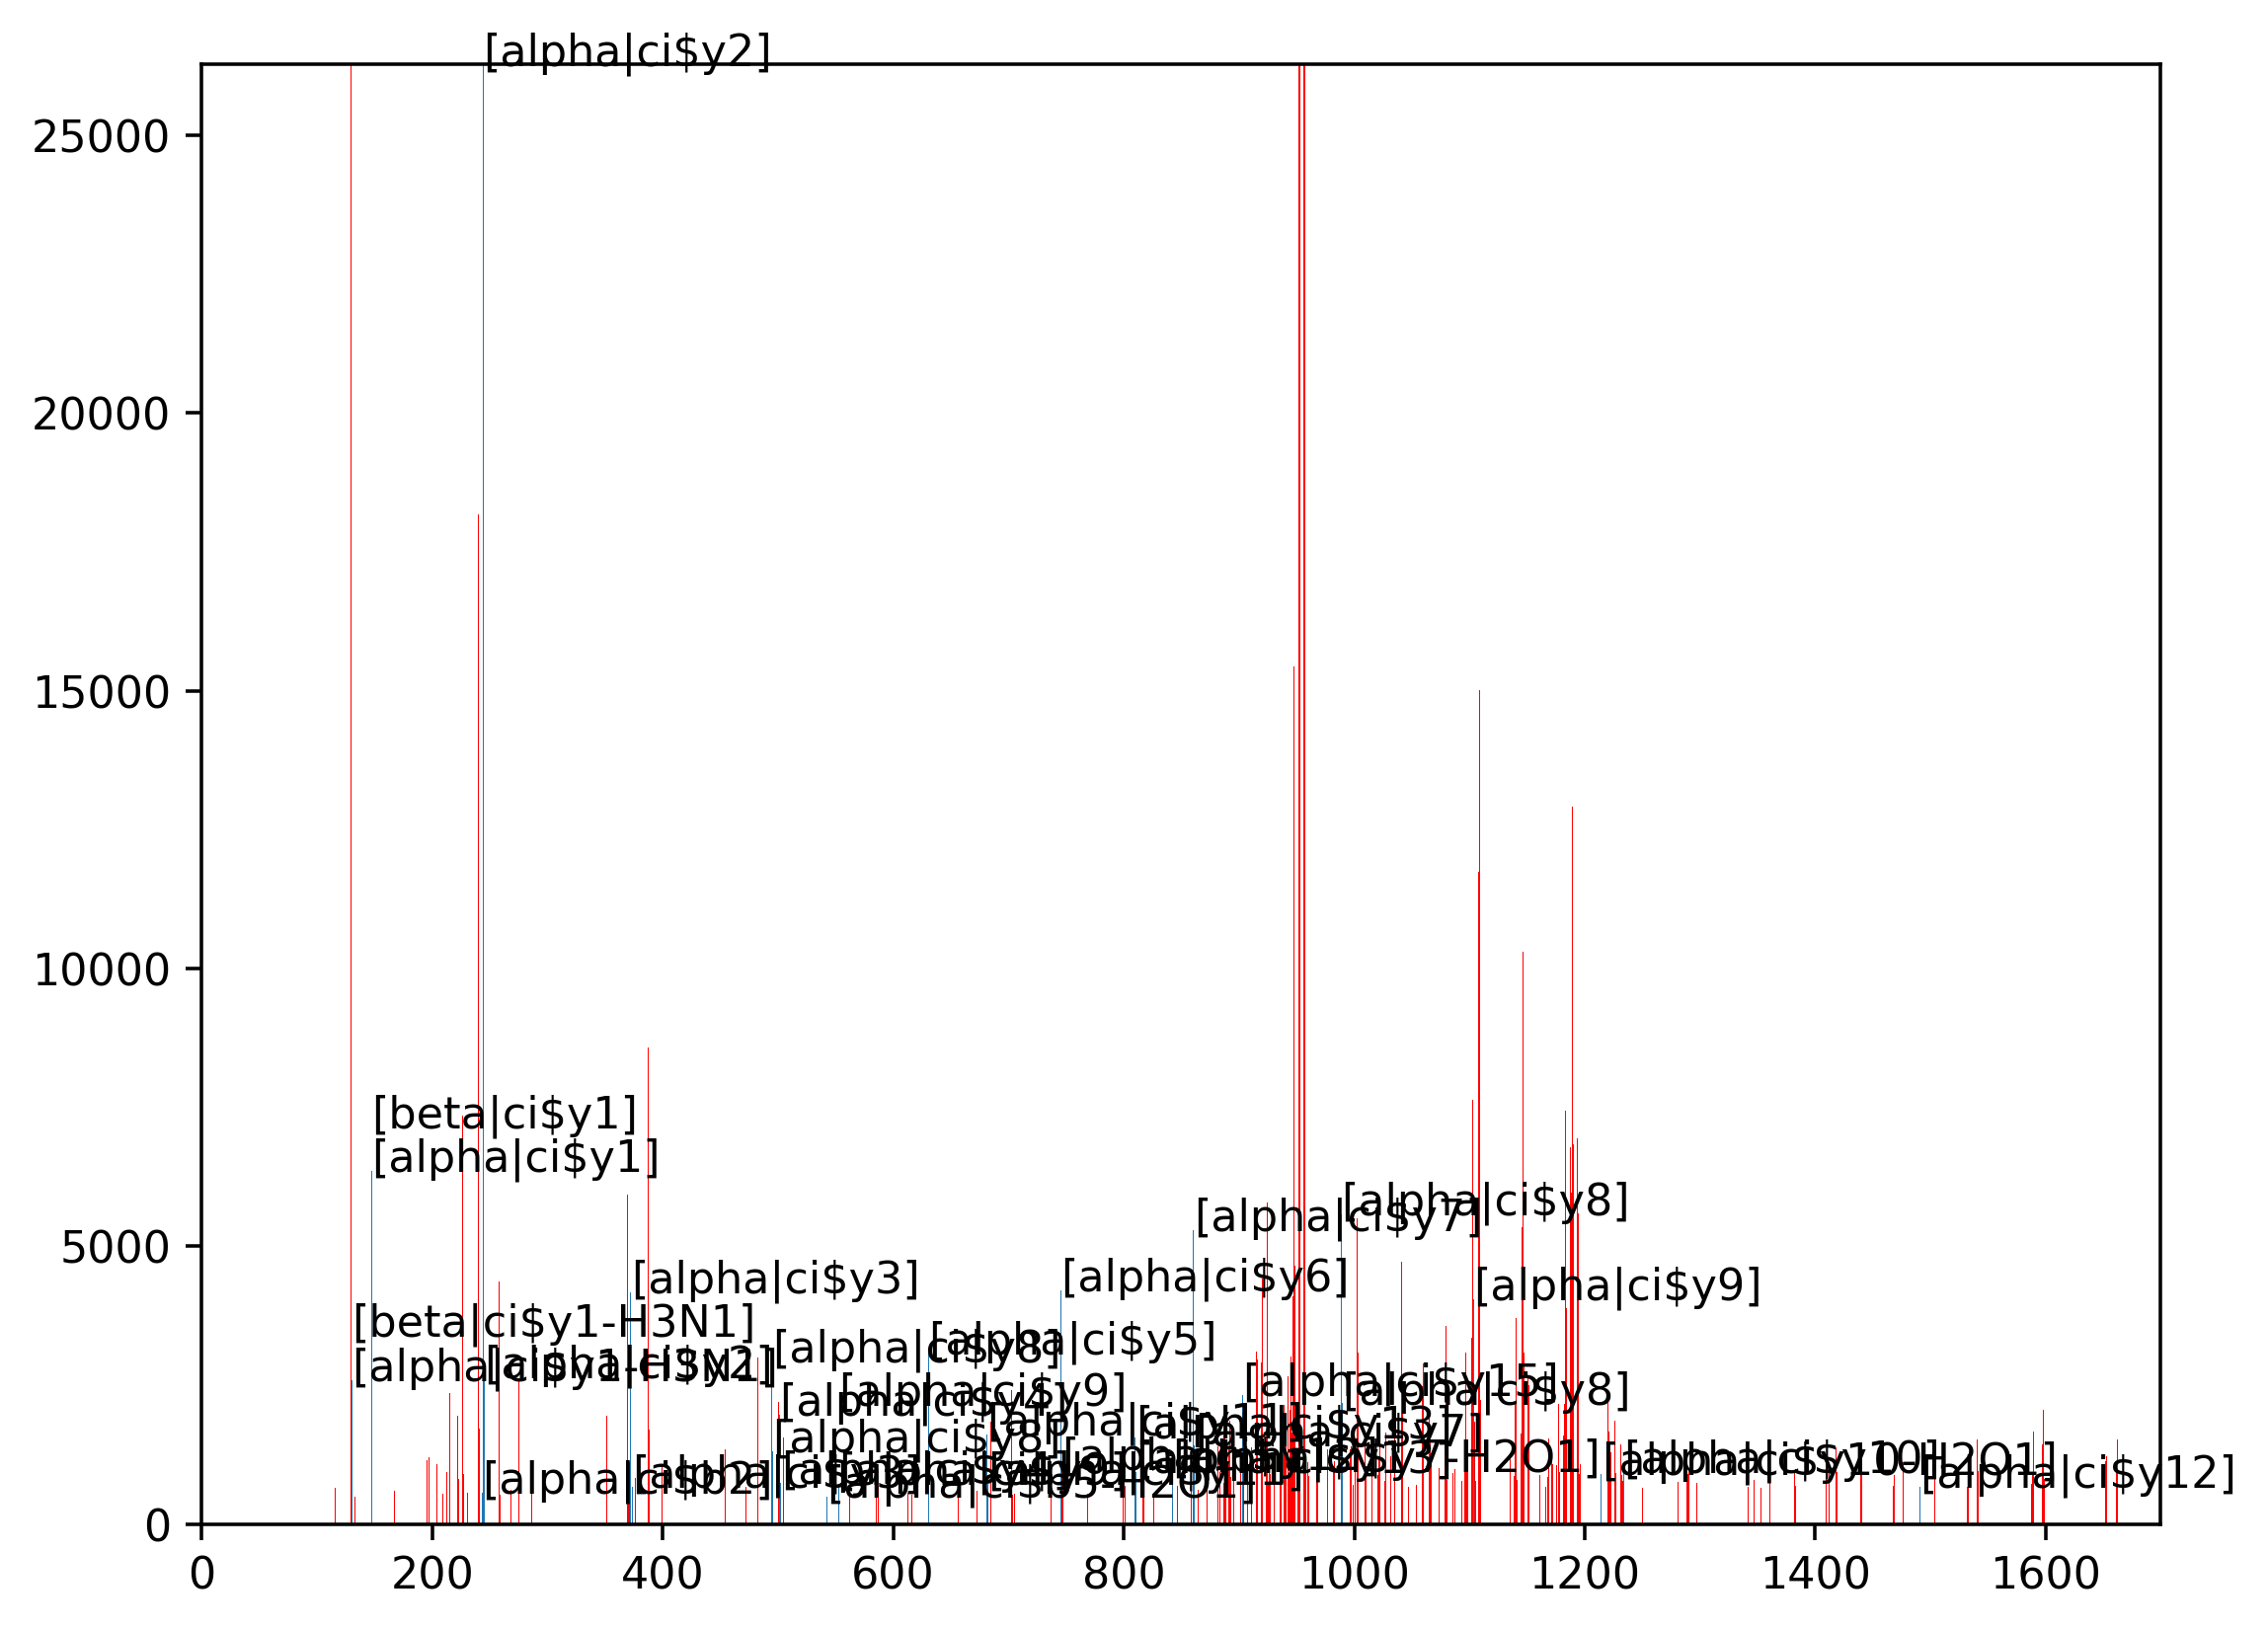

In [90]:
i = 0

spec_ref = high_s2.iloc[i]['spectrum_reference']

spec_ref = f'controllerType=0 controllerNumber=1 {spec_ref.split()[1]}'

plt.figure(figsize=[8, 6], dpi=320)
ax = plt.subplot(1, 1, 1)

spec = Spectrum(mzml.find(spec_ref))
spec.plot(1700, ax)

spec.plot_ann(high_s2.iloc[i]['fragment_annotation'], ax)
# xlms_id = XLMS_id(pepid_high_s2[spec_ref][0])
# xlms_id.plot(spec, ax)

## Find Spec with dup

### ecoli_xl

In [93]:
df = load_idxmls(f'ecoli_xl/*.idXML', '../results/openpepxllf/knime4.6/')

../results/openpepxllf/knime4.6/ecoli_xl/DESTRibo_092010exp2_LEF10.idXML
../results/openpepxllf/knime4.6/ecoli_xl/DESTRibo_092010exp2_LEF1_101012172356.idXML
../results/openpepxllf/knime4.6/ecoli_xl/DESTRibo_092010exp2_LEF2.idXML
../results/openpepxllf/knime4.6/ecoli_xl/DESTRibo_092010exp2_LEF3.idXML
../results/openpepxllf/knime4.6/ecoli_xl/DESTRibo_092010exp2_LEF4.idXML
../results/openpepxllf/knime4.6/ecoli_xl/DESTRibo_092010exp2_LEF5.idXML
../results/openpepxllf/knime4.6/ecoli_xl/DESTRibo_092010exp2_LEF6.idXML
../results/openpepxllf/knime4.6/ecoli_xl/DESTRibo_092010exp2_LEF7.idXML
../results/openpepxllf/knime4.6/ecoli_xl/DESTRibo_092010exp2_LEF8.idXML
../results/openpepxllf/knime4.6/ecoli_xl/DESTRibo_092010exp2_LEF9.idXML
../results/openpepxllf/knime4.6/ecoli_xl/DESTRibo_092010exp2_LE_1and2rejected.idXML
../results/openpepxllf/knime4.6/ecoli_xl/DESTRibo_092010exp2_WD_1and2rejected.idXML
../results/openpepxllf/knime4.6/ecoli_xl/DESTRibo_092210exp2_LEF1.idXML
../results/openpepxllf/kni

In [94]:
df

score_type higher_score_better significance_threshold  \
0      OpenPepXL:score                true                    0.0   
1      OpenPepXL:score                true                    0.0   
2      OpenPepXL:score                true                    0.0   
3      OpenPepXL:score                true                    0.0   
4      OpenPepXL:score                true                    0.0   
...                ...                 ...                    ...   
50245  OpenPepXL:score                true                    0.0   
50246  OpenPepXL:score                true                    0.0   
50247  OpenPepXL:score                true                    0.0   
50248  OpenPepXL:score                true                    0.0   
50249  OpenPepXL:score                true                    0.0   

                        MZ                    RT  \
0      426.238403320313012  3846.603199999997742   
1      338.804700000000025   3938.11409999999978   
2      338.804700000000025   3938.11409999999978   
3      338.804700000000025   3938.11409999999978   
4      338.804700000000025   3938.11409999999978   
...                    ...                   ...   
50245  452.261169433593977  2540.009500000001935   
50246  452.261169433593977  2540.009500000001935   
50247  352.933197021483977  2561.170399999998153   
50248  352.933197021483977  2561.170399999998153   
50249  352.933197021483977  2561.170399999998153   

                                   spectrum_reference    xl_chain  xl_pos1  \
0      file=DESTRibo_092010exp2_LEF10.idXML scan=3223  MS:1002509        7   
1      file=DESTRibo_092010exp2_LEF10.idXML scan=3285  MS:1002509        0   
2      file=DESTRibo_092010exp2_LEF10.idXML scan=3285  MS:1002509        0   
3      file=DESTRibo_092010exp2_LEF10.idXML scan=3285  MS:1002509        4   
4      file=DESTRibo_092010exp2_LEF10.idXML scan=3285  MS:1002509        9   
...                                               ...         ...      ...   
50245   file=DESTRibo_noLEFwo2+_071510.idXML scan=979  MS:1002509        7   
50246   file=DESTRibo_noLEFwo2+_071510.idXML scan=979  MS:1002509        6   
50247   file=DESTRibo_noLEFwo2+_071510.idXML scan=989  MS:1002509        5   
50248   file=DESTRibo_noLEFwo2+_071510.idXML scan=989  MS:1002509        5   
50249   file=DESTRibo_noLEFwo2+_071510.idXML scan=989  MS:1002509        5   

       spectrum_index     xl_type  ...      sequence_beta target_decoy  \
0                  45   mono-link  ...                  -       target   
1                  68  cross-link  ...              IKTVR       target   
2                  68  cross-link  ...              LKLSR       target   
3                  68  cross-link  ...  SKRGM(Oxidation)R       target   
4                  68   mono-link  ...                  -       target   
...               ...         ...  ...                ...          ...   
50245             272   mono-link  ...                  -       target   
50246             272   mono-link  ...                  -       target   
50247             280   mono-link  ...                  -       target   
50248             280   mono-link  ...                  -       target   
50249             280   mono-link  ...                  -       target   

      protein_references  xl_pos1_protein xl_pos2_protein  \
0                 unique               78               -   
1                 unique                1               5   
2                 unique                1              10   
3                 unique              120              12   
4                 unique               10               -   
...                  ...              ...             ...   
50245             unique               29               -   
50246             unique               28               -   
50247             unique              144               -   
50248             unique              144               -   
50249             unique               75               -   


In [102]:
(df.groupby('spectrum_reference')['spectrum_reference'].count() > 1).sum()

8461

In [100]:
(df.groupby('spectrum_reference')['spectrum_reference'].count() == 1).sum()

3983

In [96]:
def sigle_left_after_remove_dup(df):
    if len(df) == 1:
        return None
    df = remove_dup_pep(df)
    if len(df) > 1:
        return None
    return df

In [97]:
spec_wdup = df.groupby('spectrum_reference').apply(sigle_left_after_remove_dup)
spec_wdup.reset_index(drop = True, inplace = True)
spec_wdup

score_type higher_score_better significance_threshold  \
0    OpenPepXL:score                true                    0.0   
1    OpenPepXL:score                true                    0.0   
2    OpenPepXL:score                true                    0.0   
3    OpenPepXL:score                true                    0.0   
4    OpenPepXL:score                true                    0.0   
..               ...                 ...                    ...   
652  OpenPepXL:score                true                    0.0   
653  OpenPepXL:score                true                    0.0   
654  OpenPepXL:score                true                    0.0   
655  OpenPepXL:score                true                    0.0   
656  OpenPepXL:score                true                    0.0   

                      MZ                    RT  \
0    401.058380126953011  4753.133200000002034   
1    457.696500000000015  4837.013200000002143   
2    917.176100000000019  6466.539199999980156   
3    422.022299999999973  6516.753300000000309   
4    428.252900000000011  2169.506200000002082   
..                   ...                   ...   
652  776.101400000000012  5474.489500000002408   
653  945.232300000000009  6145.445099999999911   
654  872.715799999999945  6254.450400000000627   
655  818.109100000000012  7658.219699999999648   
656     325.205810546875  2173.129699999998138   

                                    spectrum_reference    xl_chain  xl_pos1  \
0       file=DESTRibo_092010exp2_LEF10.idXML scan=3910  MS:1002509        0   
1       file=DESTRibo_092010exp2_LEF10.idXML scan=3987  MS:1002509        0   
2       file=DESTRibo_092010exp2_LEF10.idXML scan=5286  MS:1002509        0   
3       file=DESTRibo_092010exp2_LEF10.idXML scan=5336  MS:1002509        3   
4    file=DESTRibo_092010exp2_LEF1_101012172356.idX...  MS:1002509        2   
..                                                 ...         ...      ...   
652     file=DESTRibo_noLEFwo2+_071510.idXML scan=2439  MS:1002509        0   
653     file=DESTRibo_noLEFwo2+_071510.idXML scan=2776  MS:1002509        5   
654     file=DESTRibo_noLEFwo2+_071510.idXML scan=2831  MS:1002509        6   
655     file=DESTRibo_noLEFwo2+_071510.idXML scan=3579  MS:1002509        0   
656      file=DESTRibo_noLEFwo2+_071510.idXML scan=807  MS:1002509        0   

     spectrum_index     xl_type  ...              sequence_beta target_decoy  \
0               282  cross-link  ...                    VKIVKFR       target   
1               301  cross-link  ...                     KATKRK       target   
2               719   mono-link  ...                          -       target   
3               728  cross-link  ...                      GKKTR       target   
4                31  cross-link  ...                    MAKAPIR       target   
..              ...         ...  ...                        ...          ...   
652            1366  cross-link  ...                   KPLRTWSR       target   
653            1618  cross-link  ...  M(Oxidation)AKLHDYYKDEVVK       target   
654            1659  cross-link  ...                 QSMKAREVKR       target   
655            2159   mono-link  ...                          -       target   
656             143  cross-link  ...                     GHKGQK       target   

    protein_references  xl_pos1_protein xl_pos2_protein       accessions_beta  \
0               unique               70              76  sp|P0AG48|RL21_ECOLI   
1               unique               54              36  sp|P0A7Q1|RL35_ECOLI   
2               unique                1               -                     -   
3               unique               49             255   sp|P60422|RL2_ECOLI   
4               unique                3               1  sp|P0A7R9|RS11_ECOLI   
..                 ...              ...             ...                   ...   
652             unique                1              29  sp|P0A7U3|RS19_ECOLI   
653             unique               43       

In [101]:
spec_wdup.groupby('spectrum_reference').count()

score_type  \
spectrum_reference                                               
file=DESTRibo_092010exp2_LEF10.idXML scan=3910               1   
file=DESTRibo_092010exp2_LEF10.idXML scan=3987               1   
file=DESTRibo_092010exp2_LEF10.idXML scan=5286               1   
file=DESTRibo_092010exp2_LEF10.idXML scan=5336               1   
file=DESTRibo_092010exp2_LEF1_101012172356.idXM...           1   
...                                                        ...   
file=DESTRibo_noLEFwo2+_071510.idXML scan=2439               1   
file=DESTRibo_noLEFwo2+_071510.idXML scan=2776               1   
file=DESTRibo_noLEFwo2+_071510.idXML scan=2831               1   
file=DESTRibo_noLEFwo2+_071510.idXML scan=3579               1   
file=DESTRibo_noLEFwo2+_071510.idXML scan=807                1   

                                                    higher_score_better  \
spectrum_reference                                                        
file=DESTRibo_092010exp2_LEF10.idXML scan=3910                        1   
file=DESTRibo_092010exp2_LEF10.idXML scan=3987                        1   
file=DESTRibo_092010exp2_LEF10.idXML scan=5286                        1   
file=DESTRibo_092010exp2_LEF10.idXML scan=5336                        1   
file=DESTRibo_092010exp2_LEF1_101012172356.idXM...                    1   
...                                                                 ...   
file=DESTRibo_noLEFwo2+_071510.idXML scan=2439                        1   
file=DESTRibo_noLEFwo2+_071510.idXML scan=2776                        1   
file=DESTRibo_noLEFwo2+_071510.idXML scan=2831                        1   
file=DESTRibo_noLEFwo2+_071510.idXML scan=3579                        1   
file=DESTRibo_noLEFwo2+_071510.idXML scan=807                         1   

                                                    significance_threshold  \
spectrum_reference                                                           
file=DESTRibo_092010exp2_LEF10.idXML scan=3910                           1   
file=DESTRibo_092010exp2_LEF10.idXML scan=3987                           1   
file=DESTRibo_092010exp2_LEF10.idXML scan=5286                           1   
file=DESTRibo_092010exp2_LEF10.idXML scan=5336                           1   
file=DESTRibo_092010exp2_LEF1_101012172356.idXM...                       1   
...                                                                    ...   
file=DESTRibo_noLEFwo2+_071510.idXML scan=2439                           1   
file=DESTRibo_noLEFwo2+_071510.idXML scan=2776                           1   
file=DESTRibo_noLEFwo2+_071510.idXML scan=2831                           1   
file=DESTRibo_noLEFwo2+_071510.idXML scan=3579                           1   
file=DESTRibo_noLEFwo2+_071510.idXML scan=807                            1   

                                                    MZ  RT  xl_chain  xl_pos1  \
spectrum_reference                                                              
file=DESTRibo_092010exp2_LEF10.idXML scan=3910       1   1         1        1   
file=DESTRibo_092010exp2_LEF10.idXML scan=3987       1   1         1        1   
file=DESTRibo_092010exp2_LEF10.idXML scan=5286       1   1         1        1   
file=DESTRibo_092010exp2_LEF10.idXML scan=5336       1   1         1        1   
file=DESTRibo_092010exp2_LEF1_101012172356.idXM...   1   1         1        1   
...                                                 ..  ..       ...      ...   
file=DESTRibo_noLEFwo2+_071510.idXML scan=2439       1   1         1        1   
file=DESTRibo_noLEFwo2+_071510.idXML scan=2776       1   1         1        1   
file=DESTRibo_noLEFwo2+_071510.idXML scan=2831       1   1         1        1   
file=DESTRibo_noLEFwo2+_071510.idXML scan=3579       1   1         1        1   
file=DESTRibo_noLEFwo2+_071510.idXML scan=807        1   1         1        1   

                                                    spectrum_index  xl_type  \
spectrum_reference                                                   

In [103]:
nodup = df.groupby('spectrum_reference').apply(remove_dup_pep)
nodup.reset_index(drop = True, inplace = True)
nodup

score_type higher_score_better significance_threshold  \
0      OpenPepXL:score                true                    0.0   
1      OpenPepXL:score                true                    0.0   
2      OpenPepXL:score                true                    0.0   
3      OpenPepXL:score                true                    0.0   
4      OpenPepXL:score                true                    0.0   
...                ...                 ...                    ...   
38856  OpenPepXL:score                true                    0.0   
38857  OpenPepXL:score                true                    0.0   
38858  OpenPepXL:score                true                    0.0   
38859  OpenPepXL:score                true                    0.0   
38860  OpenPepXL:score                true                    0.0   

                        MZ                    RT  \
0      426.238403320313012  3846.603199999997742   
1      338.804700000000025   3938.11409999999978   
2      338.804700000000025   3938.11409999999978   
3      338.804700000000025   3938.11409999999978   
4      338.804700000000025   3938.11409999999978   
...                    ...                   ...   
38856  452.261169433593977  2540.009500000001935   
38857  452.261169433593977  2540.009500000001935   
38858  352.933197021483977  2561.170399999998153   
38859  352.933197021483977  2561.170399999998153   
38860  352.933197021483977  2561.170399999998153   

                                   spectrum_reference    xl_chain  xl_pos1  \
0      file=DESTRibo_092010exp2_LEF10.idXML scan=3223  MS:1002509        7   
1      file=DESTRibo_092010exp2_LEF10.idXML scan=3285  MS:1002509        0   
2      file=DESTRibo_092010exp2_LEF10.idXML scan=3285  MS:1002509        0   
3      file=DESTRibo_092010exp2_LEF10.idXML scan=3285  MS:1002509        4   
4      file=DESTRibo_092010exp2_LEF10.idXML scan=3285  MS:1002509        9   
...                                               ...         ...      ...   
38856   file=DESTRibo_noLEFwo2+_071510.idXML scan=979  MS:1002509        7   
38857   file=DESTRibo_noLEFwo2+_071510.idXML scan=979  MS:1002509        6   
38858   file=DESTRibo_noLEFwo2+_071510.idXML scan=989  MS:1002509        5   
38859   file=DESTRibo_noLEFwo2+_071510.idXML scan=989  MS:1002509        5   
38860   file=DESTRibo_noLEFwo2+_071510.idXML scan=989  MS:1002509        5   

       spectrum_index     xl_type  ...      sequence_beta target_decoy  \
0                  45   mono-link  ...                  -       target   
1                  68  cross-link  ...              IKTVR       target   
2                  68  cross-link  ...              LKLSR       target   
3                  68  cross-link  ...  SKRGM(Oxidation)R       target   
4                  68   mono-link  ...                  -       target   
...               ...         ...  ...                ...          ...   
38856             272   mono-link  ...                  -       target   
38857             272   mono-link  ...                  -       target   
38858             280   mono-link  ...                  -       target   
38859             280   mono-link  ...                  -       target   
38860             280   mono-link  ...                  -       target   

      protein_references  xl_pos1_protein xl_pos2_protein  \
0                 unique               78               -   
1                 unique                1               5   
2                 unique                1              10   
3                 unique              120              12   
4                 unique               10               -   
...                  ...              ...             ...   
38856             unique               29               -   
38857             unique               28               -   
38858             unique              144               -   
38859             unique              144               -   
38860             unique               75               -   


In [104]:
nodup.groupby('spectrum_reference').count()

score_type  \
spectrum_reference                                           
file=DESTRibo_092010exp2_LEF10.idXML scan=3223           1   
file=DESTRibo_092010exp2_LEF10.idXML scan=3285           9   
file=DESTRibo_092010exp2_LEF10.idXML scan=3295           3   
file=DESTRibo_092010exp2_LEF10.idXML scan=3297           6   
file=DESTRibo_092010exp2_LEF10.idXML scan=3299           1   
...                                                    ...   
file=DESTRibo_noLEFwo2+_071510.idXML scan=955            1   
file=DESTRibo_noLEFwo2+_071510.idXML scan=959           10   
file=DESTRibo_noLEFwo2+_071510.idXML scan=960            1   
file=DESTRibo_noLEFwo2+_071510.idXML scan=979            2   
file=DESTRibo_noLEFwo2+_071510.idXML scan=989            3   

                                                higher_score_better  \
spectrum_reference                                                    
file=DESTRibo_092010exp2_LEF10.idXML scan=3223                    1   
file=DESTRibo_092010exp2_LEF10.idXML scan=3285                    9   
file=DESTRibo_092010exp2_LEF10.idXML scan=3295                    3   
file=DESTRibo_092010exp2_LEF10.idXML scan=3297                    6   
file=DESTRibo_092010exp2_LEF10.idXML scan=3299                    1   
...                                                             ...   
file=DESTRibo_noLEFwo2+_071510.idXML scan=955                     1   
file=DESTRibo_noLEFwo2+_071510.idXML scan=959                    10   
file=DESTRibo_noLEFwo2+_071510.idXML scan=960                     1   
file=DESTRibo_noLEFwo2+_071510.idXML scan=979                     2   
file=DESTRibo_noLEFwo2+_071510.idXML scan=989                     3   

                                                significance_threshold  MZ  \
spectrum_reference                                                           
file=DESTRibo_092010exp2_LEF10.idXML scan=3223                       1   1   
file=DESTRibo_092010exp2_LEF10.idXML scan=3285                       9   9   
file=DESTRibo_092010exp2_LEF10.idXML scan=3295                       3   3   
file=DESTRibo_092010exp2_LEF10.idXML scan=3297                       6   6   
file=DESTRibo_092010exp2_LEF10.idXML scan=3299                       1   1   
...                                                                ...  ..   
file=DESTRibo_noLEFwo2+_071510.idXML scan=955                        1   1   
file=DESTRibo_noLEFwo2+_071510.idXML scan=959                       10  10   
file=DESTRibo_noLEFwo2+_071510.idXML scan=960                        1   1   
file=DESTRibo_noLEFwo2+_071510.idXML scan=979                        2   2   
file=DESTRibo_noLEFwo2+_071510.idXML scan=989                        3   3   

                                                RT  xl_chain  xl_pos1  \
spectrum_reference                                                      
file=DESTRibo_092010exp2_LEF10.idXML scan=3223   1         1        1   
file=DESTRibo_092010exp2_LEF10.idXML scan=3285   9         9        9   
file=DESTRibo_092010exp2_LEF10.idXML scan=3295   3         3        3   
file=DESTRibo_092010exp2_LEF10.idXML scan=3297   6         6        6   
file=DESTRibo_092010exp2_LEF10.idXML scan=3299   1         1        1   
...                                             ..       ...      ...   
file=DESTRibo_noLEFwo2+_071510.idXML scan=955    1         1        1   
file=DESTRibo_noLEFwo2+_071510.idXML scan=959   10        10       10   
file=DESTRibo_noLEFwo2+_071510.idXML scan=960    1         1        1   
file=DESTRibo_noLEFwo2+_071510.idXML scan=979    2         2        2   
file=DESTRibo_noLEFwo2+_071510.idXML scan=989    3         3        3   

                                                spectrum_index  xl_type  \
spectrum_reference                                                        
file=DESTRibo_092010exp2_LEF10.idXML scan=3223               1        1   
file=DESTRibo_092010exp2_LEF10.idXML scan=3285               9        9   
file=DESTRibo_092010exp2_LEF10.idXML scan=3295      

In [105]:
(nodup.groupby('spectrum_reference')['spectrum_reference'].count() > 1).sum()

7804

In [106]:
(nodup.groupby('spectrum_reference')['spectrum_reference'].count() == 1).sum()

4640

In [107]:
import xlms

In [108]:
ds = xlms.XLMS_Dataset('ecoli_xl', nodup=True)
ds

{'mat': array([[ 4.22730708, 65.46571838,  2.48143805, ..., 89.83498406,
        75.89800946, 35.66559364],
       [ 0.        ,  0.        ,  0.        , ..., 47.82038944,
         0.        , 28.71999922]])}
dict_keys(['ndecoy', 'ndd', 'ntarget', 'fdr_thres', 'scores', 'curve_fdr', 'curve_decoy', 'curve_dd', 'curve_matches'])


In [109]:
ds.mat.shape

(2, 12444)

In [110]:
(ds.mat[1, :] == 0).sum()

6511

In [111]:
ds = xlms.XLMS_Dataset('ecoli_xl', nodup=False)
ds

{'mat': array([[151.61368928, 160.92758708, 123.76551537, ...,  13.89332551,
         28.74313144,  54.9176574 ],
       [126.9950329 , 136.83976499, 119.62039244, ...,   8.65671932,
          0.        ,   0.        ]]), 'variable2': array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 

In [112]:
ds.mat.shape

(2, 12444)

In [113]:
(ds.mat[1, :] == 0).sum()

3983

### D1810

In [114]:
ds = xlms.XLMS_Dataset('D1810', nodup=True)
ds

{'mat': array([[ 24.67499277,  67.15312977,  64.03008604, ...,  24.75380828,
         -4.765542  ,  84.53840794],
       [  0.        ,   0.        ,   0.        , ..., -15.79262513,
        -19.60065632,  18.24828308]])}
dict_keys(['ndecoy', 'ndd', 'ntarget', 'fdr_thres', 'scores', 'curve_fdr', 'curve_decoy', 'curve_dd', 'curve_matches'])


In [115]:
ds.mat.shape

(2, 53083)

In [116]:
(ds.mat[1, :] == 0).sum()

32846

In [117]:
ds = xlms.XLMS_Dataset('D1810', nodup=False)
ds

{'mat': array([[ 24.67499277,  67.15312977,  64.03008604, ...,  24.75380828,
         -4.765542  ,  84.53840794],
       [  4.07039486,   0.        ,  21.43503893, ..., -15.79262513,
        -19.60065632,  77.18479075]])}
dict_keys(['ndecoy', 'ndd', 'ntarget', 'fdr_thres', 'scores', 'curve_fdr', 'curve_decoy', 'curve_dd', 'curve_matches'])


In [118]:
ds.mat.shape

(2, 53083)

In [119]:
(ds.mat[1, :] == 0).sum()

18369